In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
from coffea import hist
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
print(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]


In [3]:
import matplotlib as mpl
mpl.style.use('seaborn-bright')

In [4]:
web_dir = '/publicweb/m/mreid/iDM_AN_Plots/RecoStudies'

# Define functions

In [5]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

In [6]:
import scipy.special
from scipy.optimize import curve_fit, fsolve
from scipy import odr

def fsigmoid(z, p0, p1):
    return 1.0 / (1.0 + np.exp(-p0*(z-p1)))
def ferf_cf(z, p0, p1, p2, p3):
    return p2 + p3*scipy.special.erf((z-p0)/p1)
def f98percentile_cf(z, p):
    return ferf_cf(z, *p) - (p[2]+p[3])*0.98
def ferf_odr(p, z):
    return p[2] + p[3]*scipy.special.erf((z-p[0])/p[1])
def f98percentile_odr(z, p):
    return ferf_odr(p, z) - (p[2]+p[3])*0.98

def make_plot(ax, sample, objs, variable, plot_props, event_selection='df'):
    h0 = ROOT.TH1F(f'h0_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    h1 = ROOT.TH1F(f'h1_{sample}', '', len(plot_props['axis'])-1, plot_props['axis'])
    for l,x in objs[event_selection][variable].iteritems():
        h0.Fill(x)
    for l,x in objs[event_selection][objs[event_selection]['nMatched']==2][variable].iteritems():
        h1.Fill(x)
    eff = ROOT.TEfficiency(h1, h0)
    data = extract_teffi(eff)

    x_err = np.diff(plot_props['axis'])/2
    if len(data['x']) != len(plot_props['axis'])-1:
        recover = np.add(np.diff(plot_props['axis'])/2,plot_props['axis'][:-1])
       # print(data)
      #  print("recover: %s"%recover)
        #print(len(data['x']),len(plot_props['axis']))
        data['x']= np.append(data['x'],recover[len(data['x']):])
        data['y']= np.append(data['y'],np.full(len(recover)-len(data['y']),0))
        data['yerr']= np.append(data['yerr'],np.full((2,len(recover)-len(data['yerr'][0])),0),axis=1)
     
      #  print(data)

    ax.errorbar(x=data['x'], y=data['y'], xerr=x_err, yerr=data['yerr'], 
                label=f'{props["label"]}', markersize=3, fmt='o', c=objs['color'])
                #label=f'{props["label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    #ax.plot(x=data['x'],y=data['y'])#, label=f'{props["label"]}', markersize=3, alpha=0.3, fmt='o', c=objs['color'])
    selection_string = 'dsa' if event_selection == 'dsa_df' else 'gbm'
    units = '[GeV]' if 'Pt'in variable else '[cm]'
    ax.set_title(f'{selection_string} muon reconstruction as a function of {variable} (over Gen Muons)')
    ax.set_xlabel(f'{variable} {units}')
    ax.set_ylabel('Muon Reconstruction efficiency')
    ax.set_ylim((0,1))
    ax.legend()
    
    return data

def make_plot_fit_cf(ax, sample, objs, variable, plot_props, event_selection='df'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    popt, pcov = curve_fit(ferf_cf, data['x'][minbin:maxbin], data['y'][minbin:maxbin], sigma=data['yerr'][1][minbin:maxbin],
                           bounds=([50,0,-10,-10],[250,100,10,10]))
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {pcov[i,i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_cf, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_cf(fit_range, *popt), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    ax.legend()
    
def make_plot_fit_odr(ax, sample, objs, variable, plot_props, event_selection='df'):
    data = make_plot(ax, sample, objs, variable, plot_props, event_selection)

    minbin = 0 if data['y'][0] < 0.1 else 1
    maxbin = -1
    
    model = odr.Model(ferf_odr)
    xerror = np.repeat(data['x'][1]-data['x'][0], len(data['x'])-minbin)
    real_data = odr.RealData(data['x'][minbin:maxbin], data['y'][minbin:maxbin], sx=xerror, sy=data['yerr'][0][minbin:maxbin])
    odr_obj = odr.ODR(real_data, model, beta0=[132, 36, 0.5, 0.5])
    out = odr_obj.run()
    
    popt = out.beta
    perr = out.sd_beta
    print(fr"[{props['label']}]")
    print('fit parameter 1-sigma error')
    print('———————————–')
    for i in range(len(popt)):
        print(f'{popt[i]:.2f} +- {perr[i]:.2f}')
    print('')
    
    percentile98 = fsolve(f98percentile_odr, 200, popt)
    fit_range = np.linspace(data['x'][minbin], data['x'][maxbin], 100)
    ax.plot(fit_range, ferf_odr(popt, fit_range), c=objs['color'],
            label=f'Fit: pT @ 98% = {percentile98[0]:.0f} GeV')
    
    ax.legend()

# Load data

In [7]:
redirector = 'root://cmseos.fnal.gov/'
basedir = '/store/group/lpcmetx/iDM/Ntuples/2018/signal/reco_effi'
samples = {
    '5p25-1': {
        'filename': redirector + basedir + '/Mchi-5p25_dMchi-0p5_ctau-1/iDMAnalysis_Mchi-5p25_dMchi-0p5_ctau-1.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.1$, ctau=1',
        'mass': '5p25',
        'ctau': '1',
        'color': 'C0'
    },
    '5p25-10': {
        'filename': redirector + basedir + '/Mchi-5p25_dMchi-0p5_ctau-10/iDMAnalysis_Mchi-5p25_dMchi-0p5_ctau-10.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.1$, ctau=10',
        'mass': '5p25',
        'ctau': '10',
        'color': 'C1'
    },
    '5p25-100': {
        'filename': redirector + basedir + '/Mchi-5p25_dMchi-0p5_ctau-100/iDMAnalysis_Mchi-5p25_dMchi-0p5_ctau-100.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.1$, ctau=100',
        'mass': '5p25',
        'ctau': '100',
        'color': 'C2'
    },
    '5p25-1000': {
        'filename': redirector + basedir + '/Mchi-5p25_dMchi-0p5_ctau-1000/iDMAnalysis_Mchi-5p25_dMchi-0p5_ctau-1000.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.1$, ctau=1000',
        'mass': '5p25',
        'ctau': '1000',
        'color': 'C3'
    },
    '52p5-1': {
        'filename': redirector + basedir + '/Mchi-52p5_dMchi-5p0_ctau-1/iDMAnalysis_Mchi-52p5_dMchi-5p0_ctau-1.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.1$, ctau=1',
        'mass': '52p5',
        'ctau': '1',
        'color': 'C1'
    },
    '52p5-10': {
        'filename': redirector + basedir + '/Mchi-52p5_dMchi-5p0_ctau-10/iDMAnalysis_Mchi-52p5_dMchi-5p0_ctau-10.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.1$, ctau=10',
        'mass': '52p5',
        'ctau': '10',
        'color': 'C2'
    },
    '52p5-100': {
        'filename': redirector + basedir + '/Mchi-52p5_dMchi-5p0_ctau-100/iDMAnalysis_Mchi-52p5_dMchi-5p0_ctau-100.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.1$, ctau=100',
        'mass': '52p5',
        'ctau': '100',
        'color': 'C3'
    },
    '52p5-1000': {
        'filename': redirector + basedir + '/Mchi-52p5_dMchi-5p0_ctau-1000/iDMAnalysis_Mchi-52p5_dMchi-5p0_ctau-1000.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.1$, ctau=1000',
        'mass': '52p5',
        'ctau': '1000',
        'color': 'C0'
    },
    '6p0-1': {
        'filename': redirector + basedir + '/Mchi-6p0_dMchi-2p0_ctau-1/iDMAnalysis_Mchi-6p0_dMchi-2p0_ctau-1.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.4$, ctau=1',
        'mass': '6p0',
        'ctau': '1',
        'color': 'C2'
    },
    '6p0-10': {
        'filename': redirector + basedir + '/Mchi-6p0_dMchi-2p0_ctau-10/iDMAnalysis_Mchi-6p0_dMchi-2p0_ctau-10.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.4$, ctau=10',
        'mass': '6p0',
        'ctau': '10',
        'color': 'C3'
    },
    '6p0100': {
        'filename': redirector + basedir + '/Mchi-6p0_dMchi-2p0_ctau-100/iDMAnalysis_Mchi-6p0_dMchi-2p0_ctau-100.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.4$, ctau=100',
        'mass': '6p0',
        'ctau': '100',
        'color': 'C0'
    },
    '6p0-1000': {
        'filename': redirector + basedir + '/Mchi-6p0_dMchi-2p0_ctau-1000/iDMAnalysis_Mchi-6p0_dMchi-2p0_ctau-1000.root',
        'label': r'm1 = 5 GeV, $\Delta = 0.4$, ctau=1000',
        'mass': '6p0',
        'ctau': '1000',
        'color': 'C1'
    },
    '60p0-1': {
        'filename': redirector + basedir + '/Mchi-60p0_dMchi-20p0_ctau-1/iDMAnalysis_Mchi-60p0_dMchi-20p0_ctau-1.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.4$, ctau=1',
        'mass': '60p0',
        'ctau': '1',
        'color': 'C3'
    },
    '60p0-10': {
        'filename': redirector + basedir + '/Mchi-60p0_dMchi-20p0_ctau-10/iDMAnalysis_Mchi-60p0_dMchi-20p0_ctau-10.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.4$, ctau=10',
        'mass': '60p0',
        'ctau': '10',
        'color': 'C0'
    },
    '60p0-100': {
        'filename': redirector + basedir + '/Mchi-60p0_dMchi-20p0_ctau-100/iDMAnalysis_Mchi-60p0_dMchi-20p0_ctau-100.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.4$, ctau=100',
        'mass': '60p0',
        'ctau': '100',
        'color': 'C1'
    },
    '60p0-1000': {
        'filename': redirector + basedir + '/Mchi-60p0_dMchi-20p0_ctau-1000/iDMAnalysis_Mchi-60p0_dMchi-20p0_ctau-1000.root',
        'label': r'm1 = 50 GeV, $\Delta = 0.4$, ctau=1000',
        'mass': '60p0',
        'ctau': '1000',
        'color': 'C2'
    },

}

In [8]:
for sample, objs in samples.items():
    file = uproot.open(objs['filename'])
    objs['dsa_tree'] = file['RECO_dsa/recoEffiForMuTrack']
    objs['gbm_tree'] = file['RECO_gbm/recoEffiForMuTrack']
    objs['dsa_df_gen'] = objs['dsa_tree'].pandas.df(['genPt','genEta','genPhi','genVxy','genVz','genDr'])
    objs['dsa_df_reco'] = objs['dsa_tree'].pandas.df(['recoPt','recoEta','recoPhi','recoDxy','recoDz','deltaR'])
    objs['dsa_df_jetmet'] = objs['dsa_tree'].pandas.df(['nMatched','genJetPt','genJetEta','genJetPhi','genLeadMetPt','genLeadMetPhi','recoPFMetPt'])
    objs['gbm_df_gen'] = objs['gbm_tree'].pandas.df(['genPt','genEta','genPhi','genVxy','genVz','genDr'])
    objs['gbm_df_reco'] = objs['gbm_tree'].pandas.df(['recoPt','recoEta','recoPhi','recoDxy','recoDz','deltaR'])
    objs['gbm_df_jetmet'] = objs['gbm_tree'].pandas.df(['nMatched','genJetPt','genJetEta','genJetPhi','genLeadMetPt','genLeadMetPhi','recoPFMetPt'])
    objs['dsa_df'] = objs['dsa_df_gen'].join(objs['dsa_df_reco']).join(objs['dsa_df_jetmet'])
    objs['gbm_df'] = objs['gbm_df_gen'].join(objs['gbm_df_reco']).join(objs['gbm_df_jetmet'])
    objs['dsa_df_ptcut'] = objs['dsa_df'][objs['dsa_df']['genPt']> 5]
    objs['gbm_df_ptcut'] = objs['gbm_df'][objs['gbm_df']['genPt']> 5]
    #print(objs['dsa_df'][['genPt','nMatched']])
#    print(objs['dsa_df'][objs['dsa_df']['nMatched']>0.1][['genPt','nMatched']])

In [9]:
ptcut= True
#for l,x in objs['dsa_df'][objs['dsa_df']['nMatched']>0]['nMatched'].iteritems():
#    print(x)

In [10]:
eff_plots = OrderedDict({
    'genPt': {
        #'axis': np.array(np.append(np.arange(0,30,6), [50]), dtype='float64'),
        'axis': np.array(np.arange(0,50,5), dtype='float64'),
        'range': [0, 50],
        'label': 'Leading gen muon pT [GeV]'
    },
    'genEta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading gen muon eta'
    },
    'genPhi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading gen muon phi'
    },
    'genVxy': {
        'axis': np.array(np.linspace(0,1000,20), dtype='float64'),
        #'axis': np.array(np.append(np.arange(0,100,20), [30]), dtype='float64'),
        'range': [0, 1000],
        'label': 'gen muon Vxy'
    },
    'genVz': {
        'axis': np.array(np.linspace(-50,50,20), dtype='float64'),
        'range': [-500, 500],
        'label': 'gen muon Vz'
    },
    'recoPt': {
        'axis': np.array(np.arange(30,300,30), dtype='float64'),
        'range': [0, 30],
        'label': 'Leading reco muon pT [GeV]'
    },
    'recoEta': {
        'axis': np.array(np.linspace(-2.4,2.4,6), dtype='float64'),
        'range': [-2.5, 2.5],
        'label': 'Leading reco muon eta'
    },
    'recoPhi': {
        'axis': np.array(np.linspace(-3.1415,3.1415,6), dtype='float64'),
        'range': [-3.2, 3.2],
        'label': 'Leading reco muon phi'
    },
    'genLeadMetPt': {
        'axis': np.array(np.arange(30,300,30), dtype='float64'),
        'range': [0, 500],
        'label': 'MET pT [GeV]'
    },
})

# DSA Muons

/uscms/home/mreid/nobackup/tresenv1/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/uscms/home/mreid/nobackup/tresenv1/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


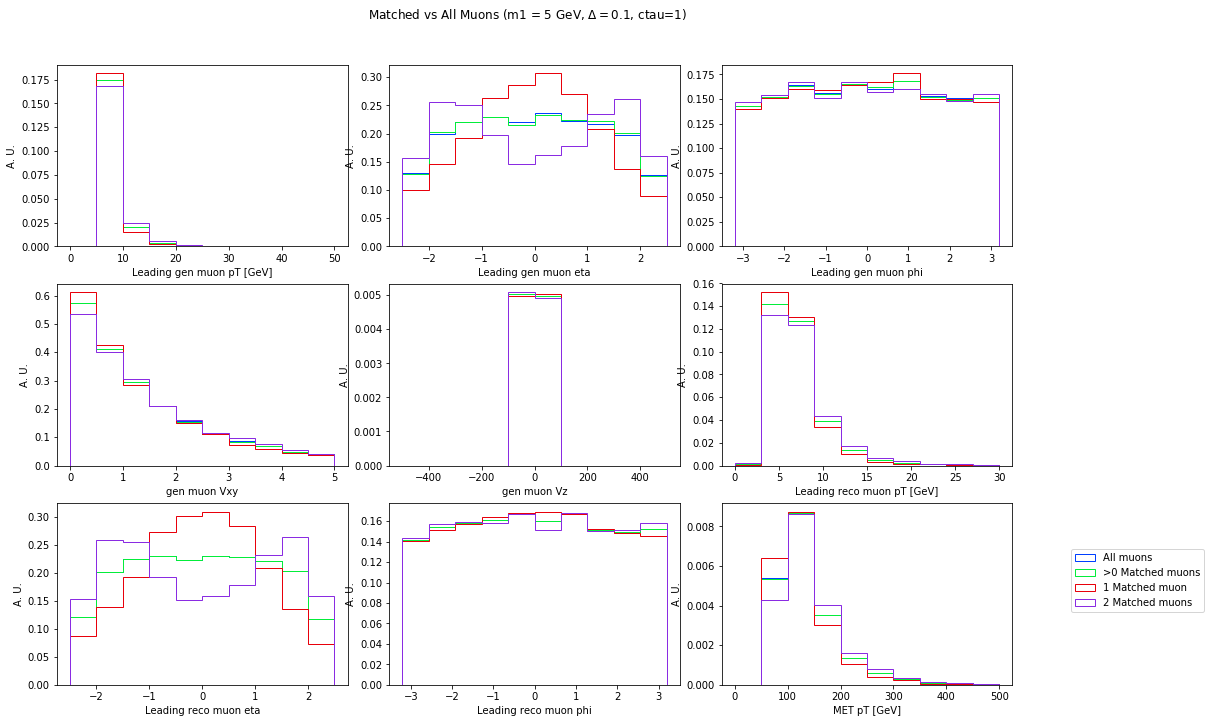

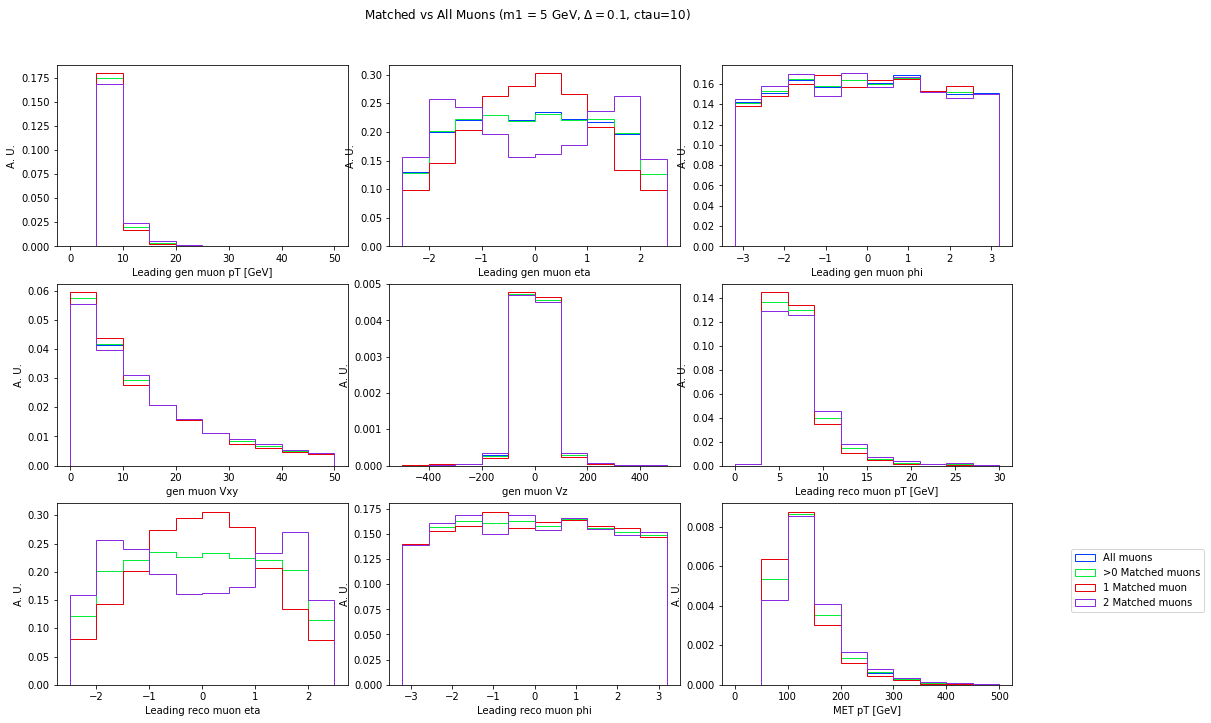

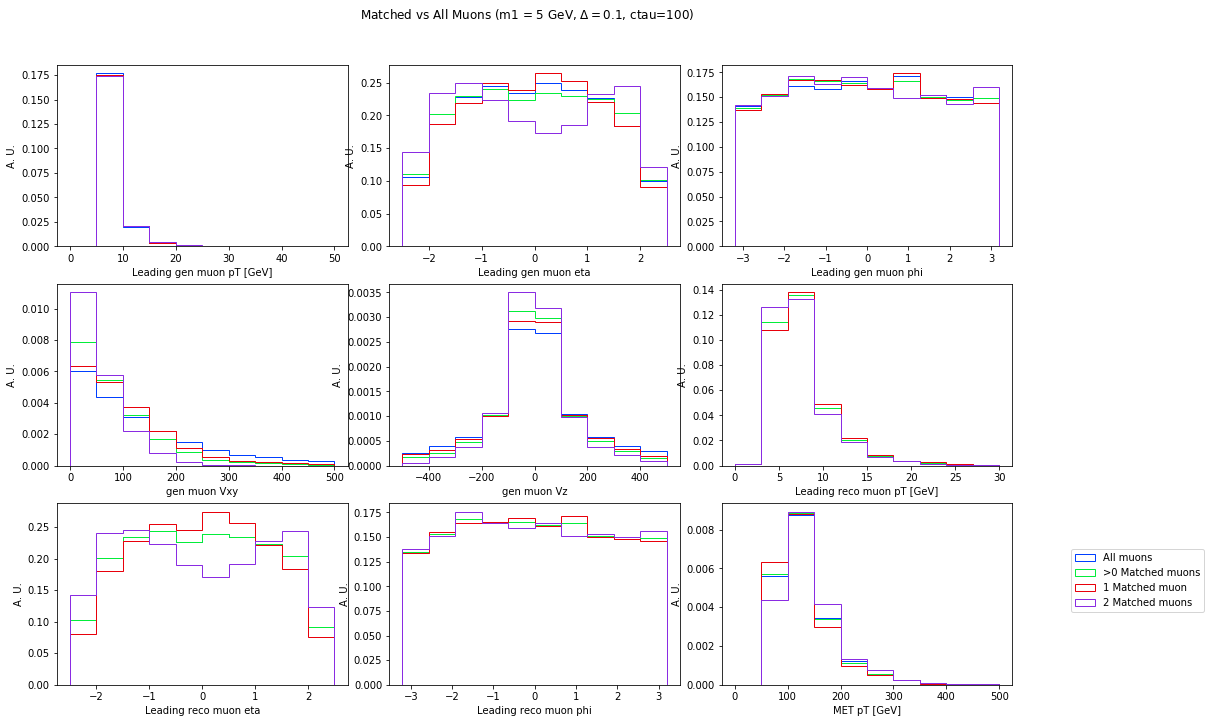

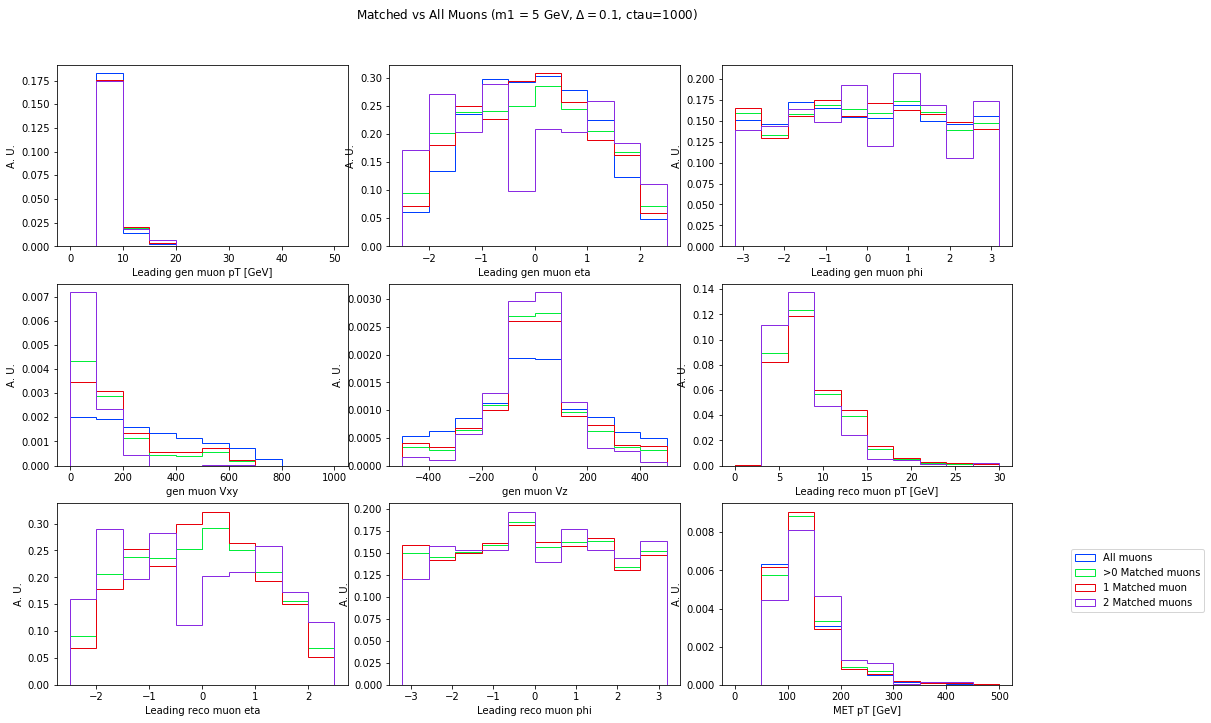

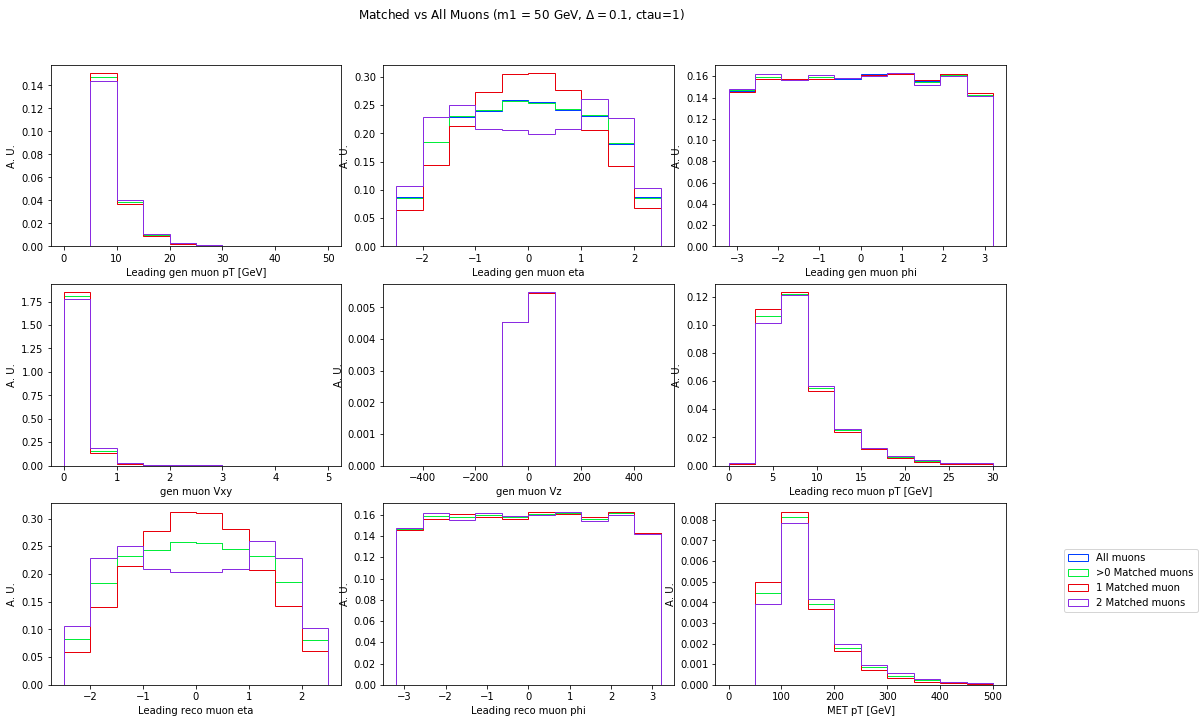

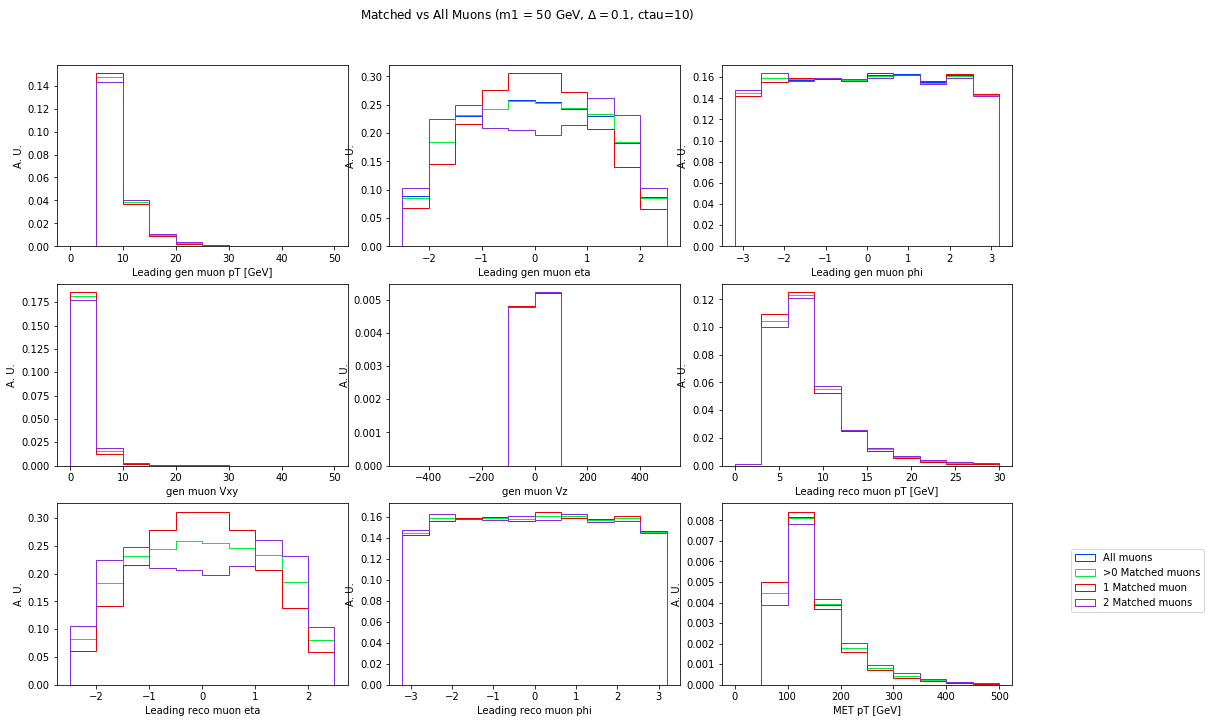

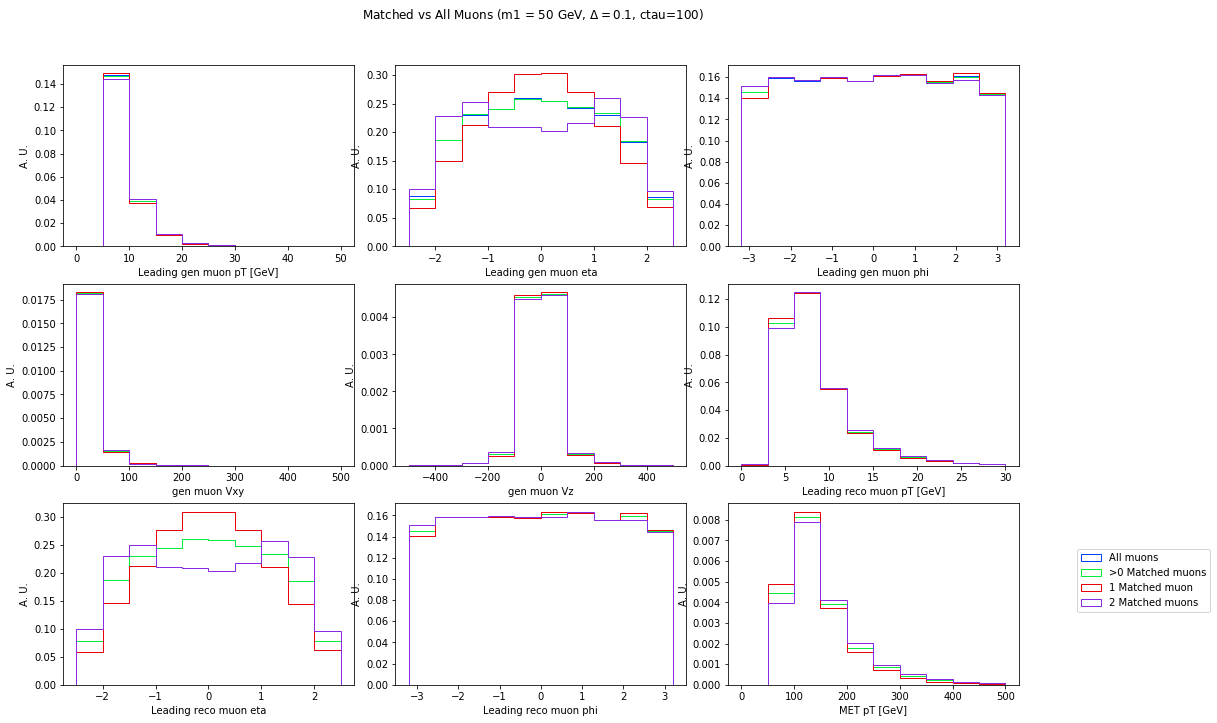

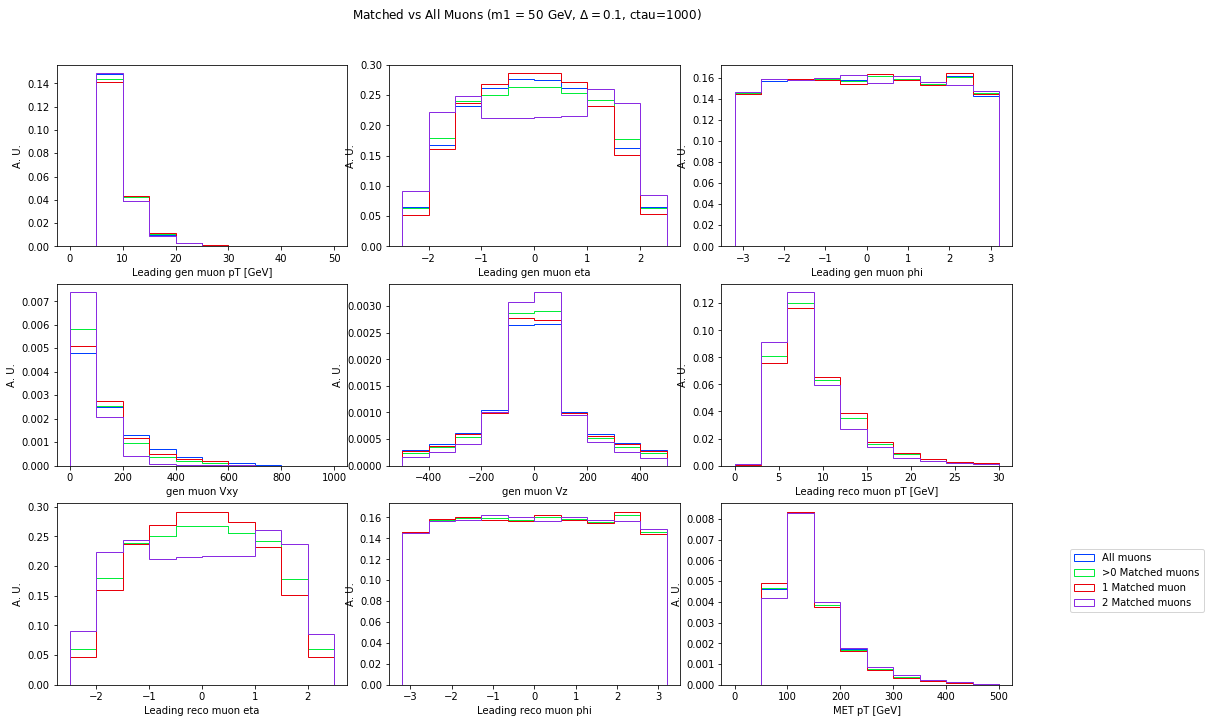

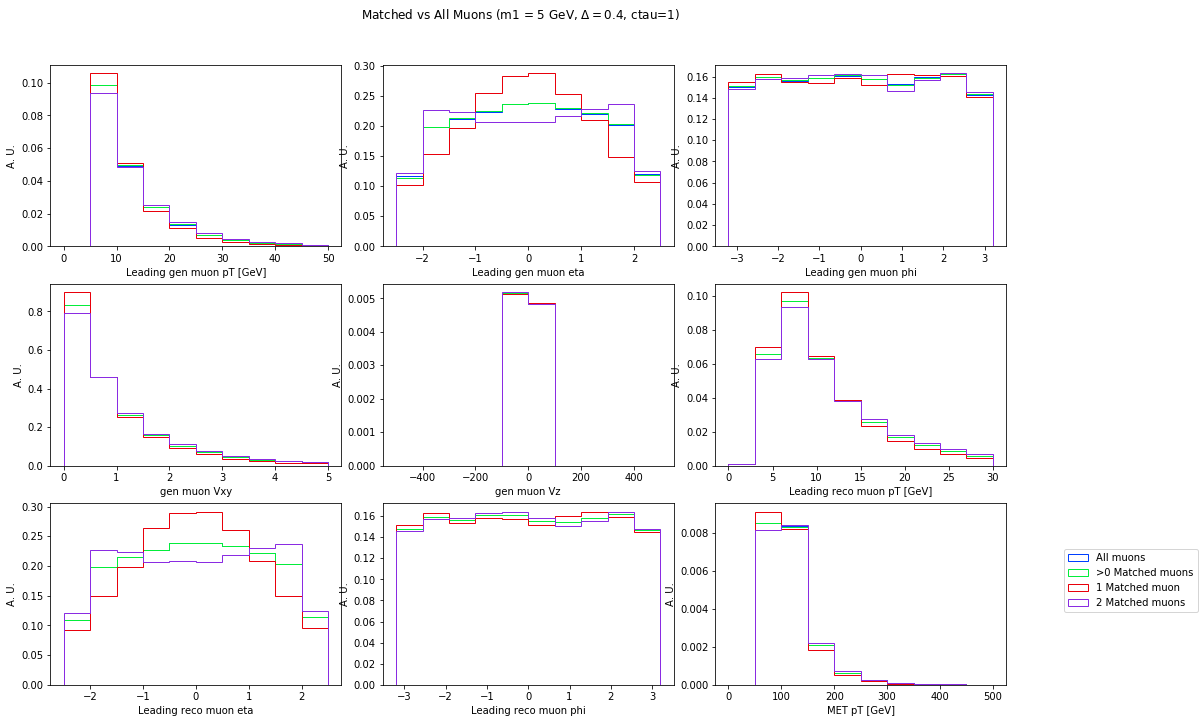

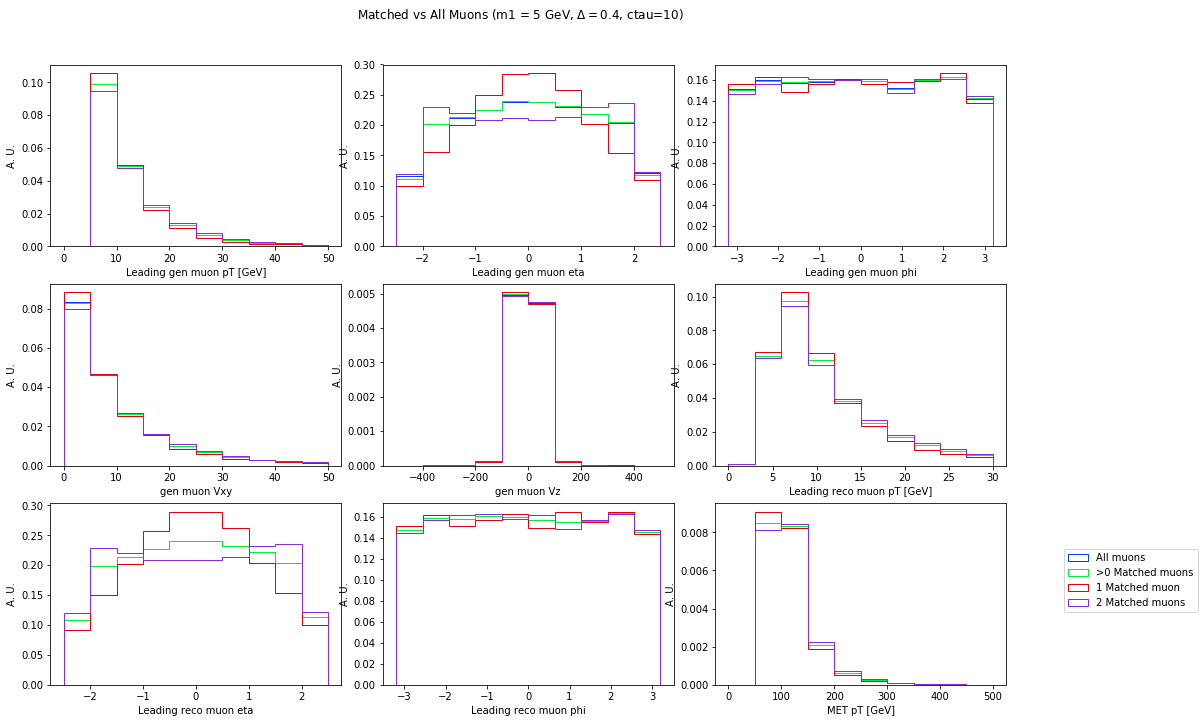

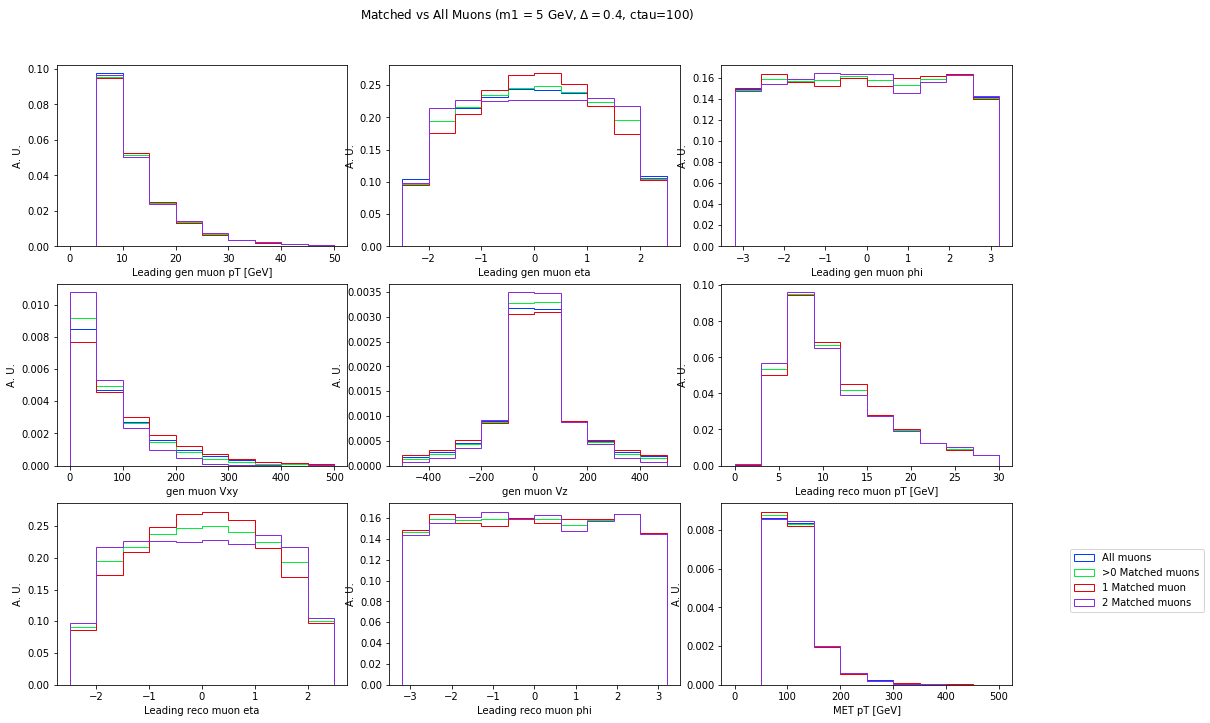

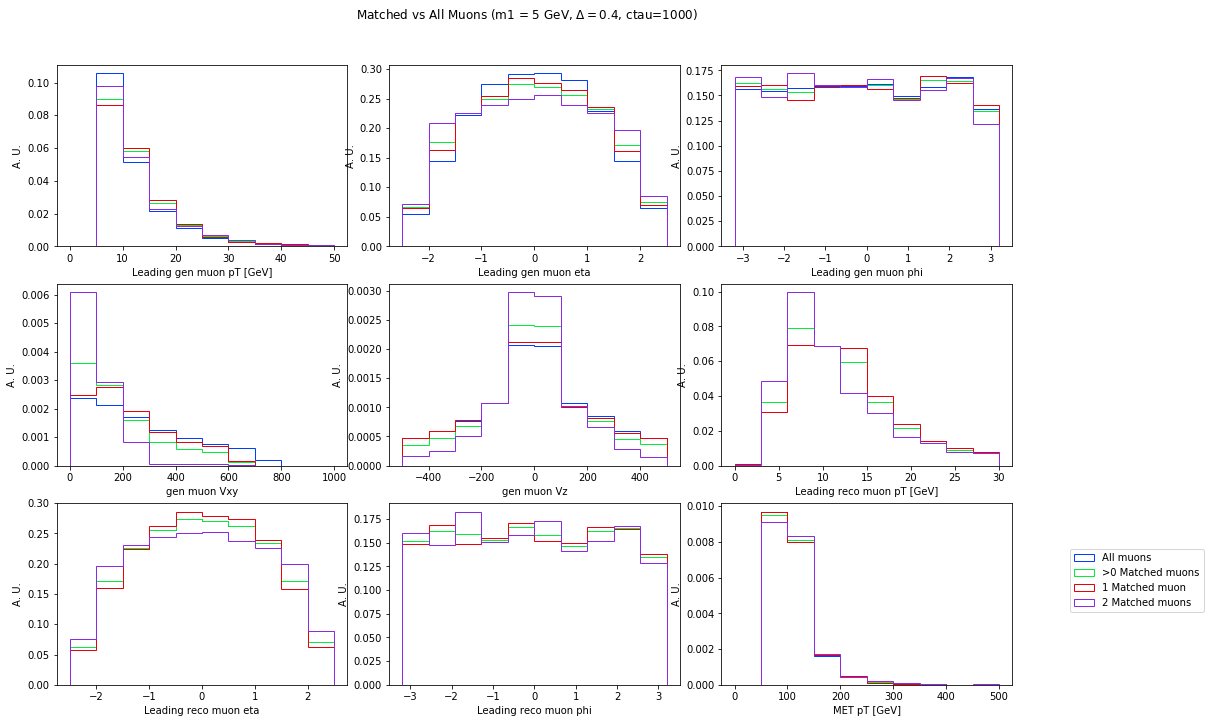

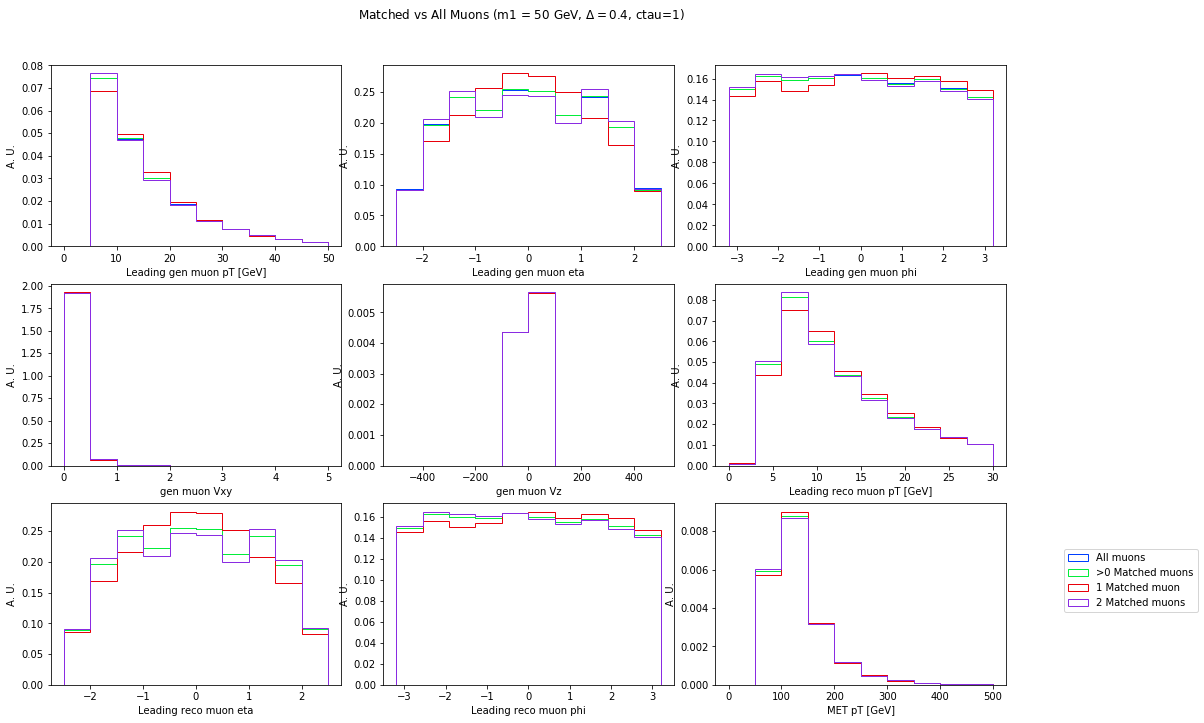

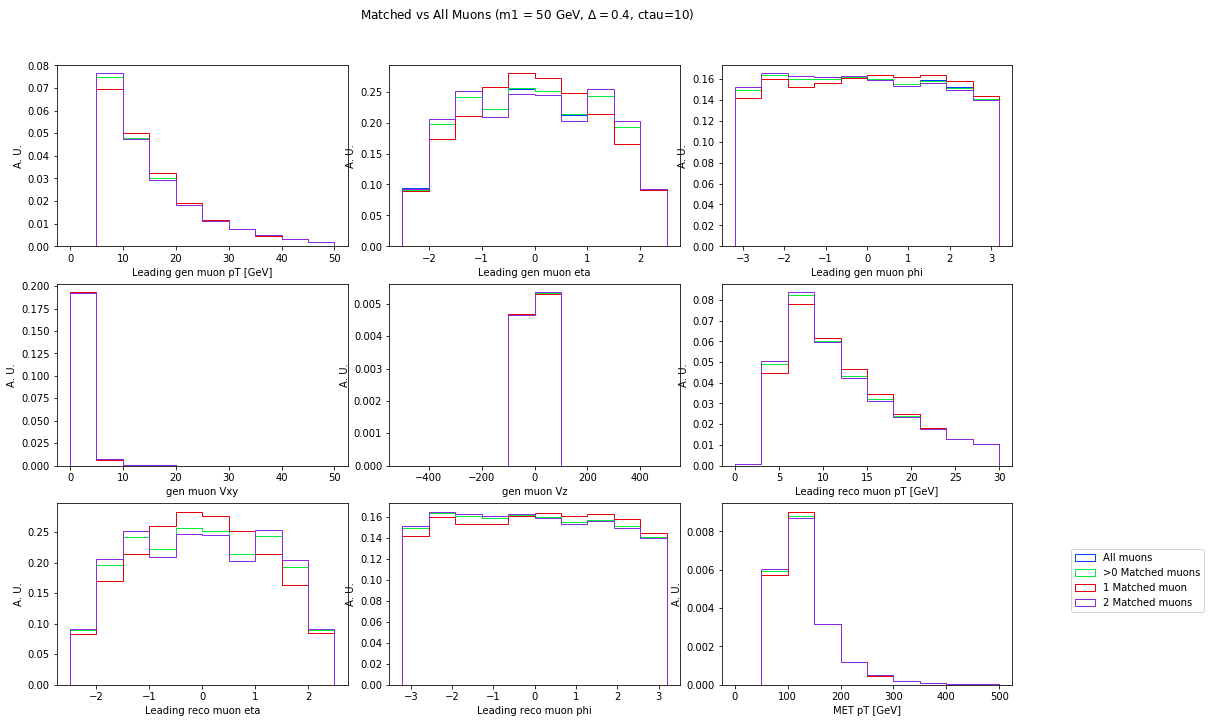

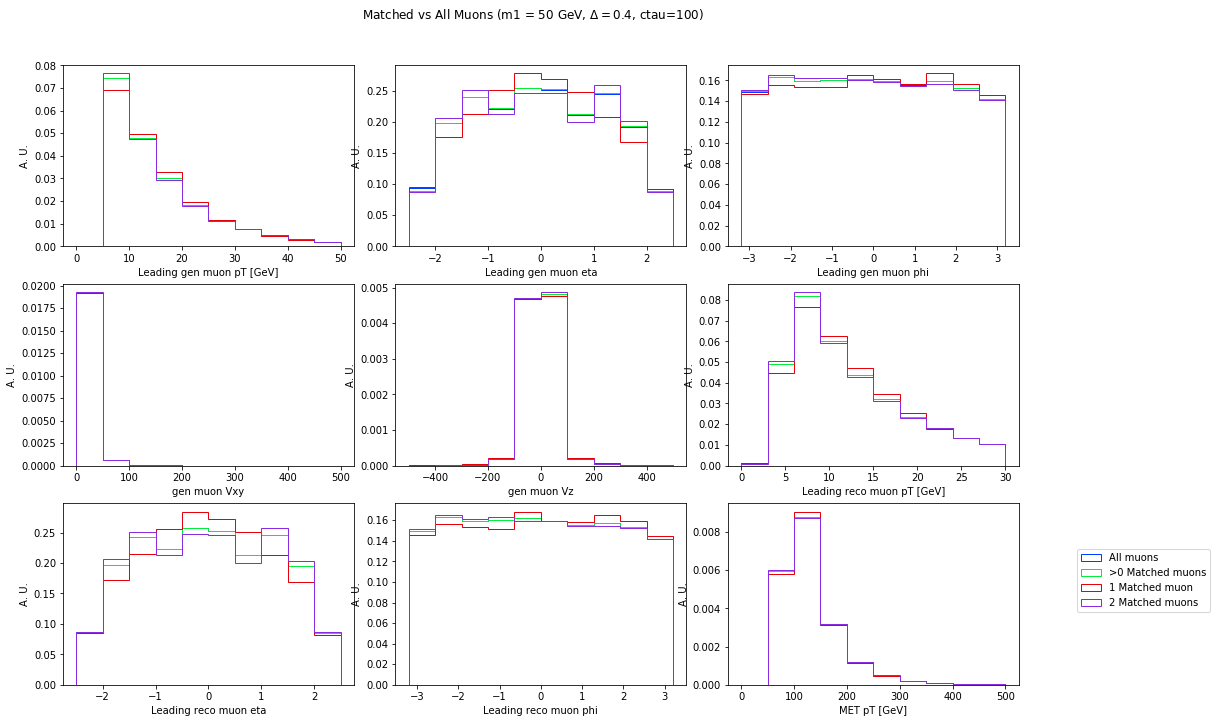

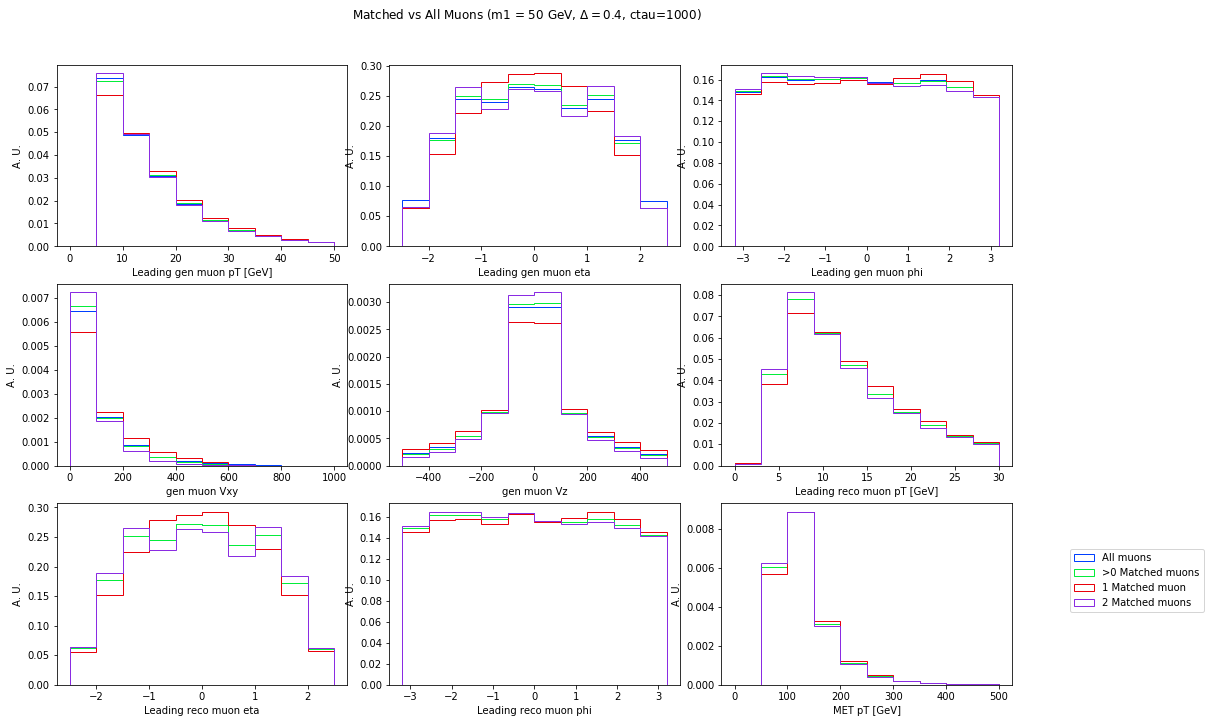

In [11]:
#sample = '52p5-100'
for sample in samples:
    fig, axes = plt.subplots(3,3, figsize=(14,10))
    fig.suptitle(f'Matched vs All Muons ({samples[sample]["label"]})')
    plt.tight_layout(h_pad=2.0)
    fig.subplots_adjust(top=0.90)
    binn= 1000 if samples[sample]['ctau']=='1000' else 5*int(samples[sample]['ctau'])
    eff_plots['genVxy']['range']= [0,binn]
    for index, (column, props) in enumerate(eff_plots.items()):
        ax = axes[index//3, index%3]
    
        bin_edges = props['axis']
        kwargs = {'range': props['range'], 'bins':10, 'density': True, 'histtype':'step','log':False}
        df = samples[sample]['dsa_df_ptcut'] if ptcut else samples[sample]['dsa_df']
        ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
                label='All muons');
        ax.hist(df.query('nMatched>0')[column].groupby('entry').nth(0), **kwargs, 
                label='>0 Matched muons');
        ax.hist(df.query('nMatched==1')[column].groupby('entry').nth(0), **kwargs, 
                label='1 Matched muon');
        ax.hist(df.query('nMatched==2')[column].groupby('entry').nth(0), **kwargs, 
                label='2 Matched muons');
        ax.set_xlabel(props['label'])
        ax.set_ylabel('A. U.')

    ax.legend(loc=(1.2 ,0.4))
    fig.savefig(f'{web_dir}/dsamatched_vs_allMu_{sample}', bbox_inches='tight')

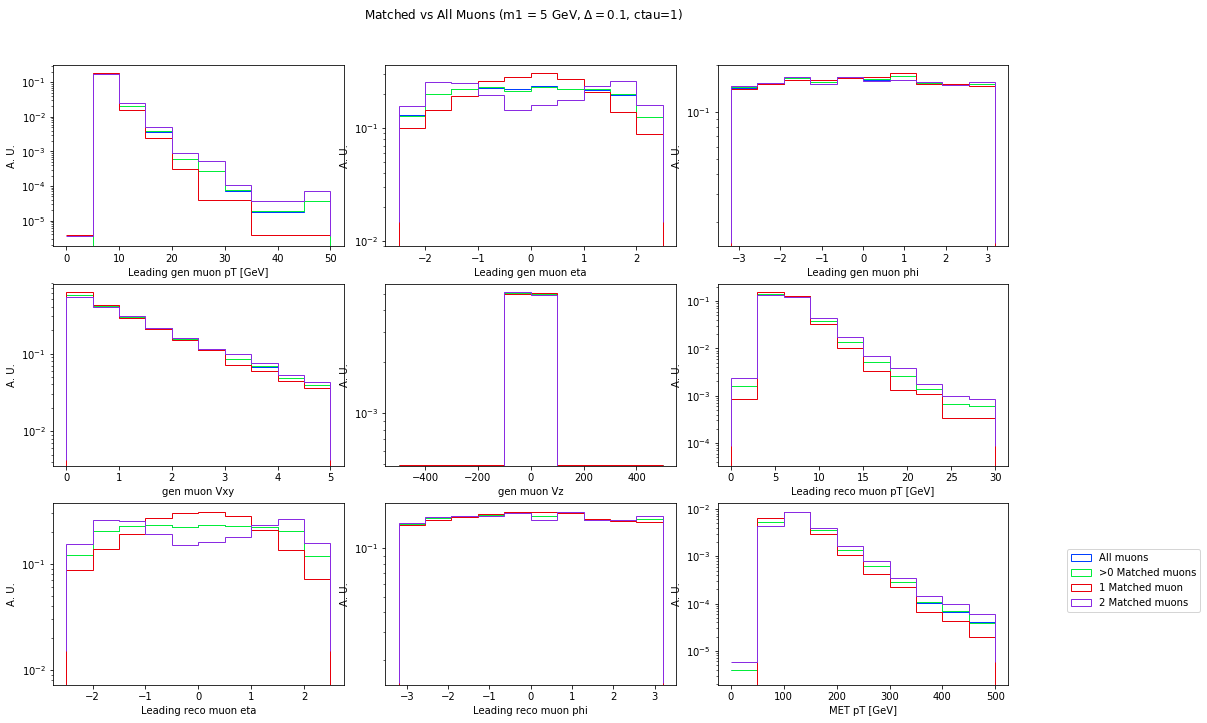

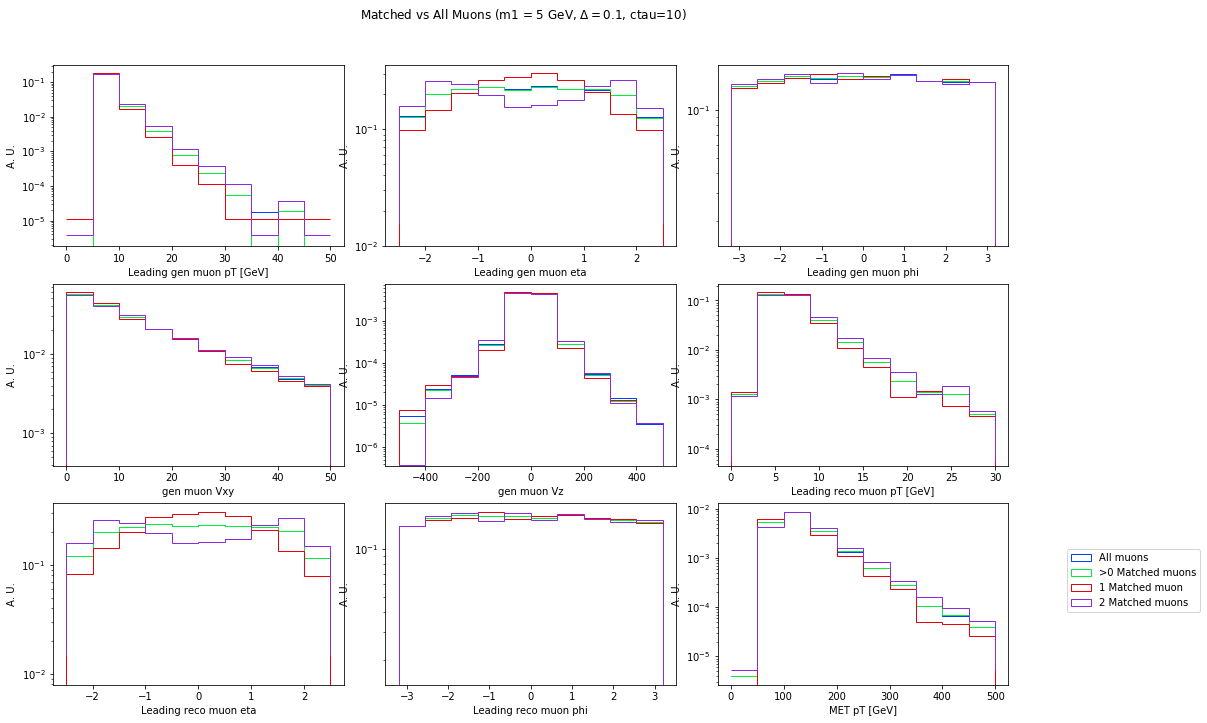

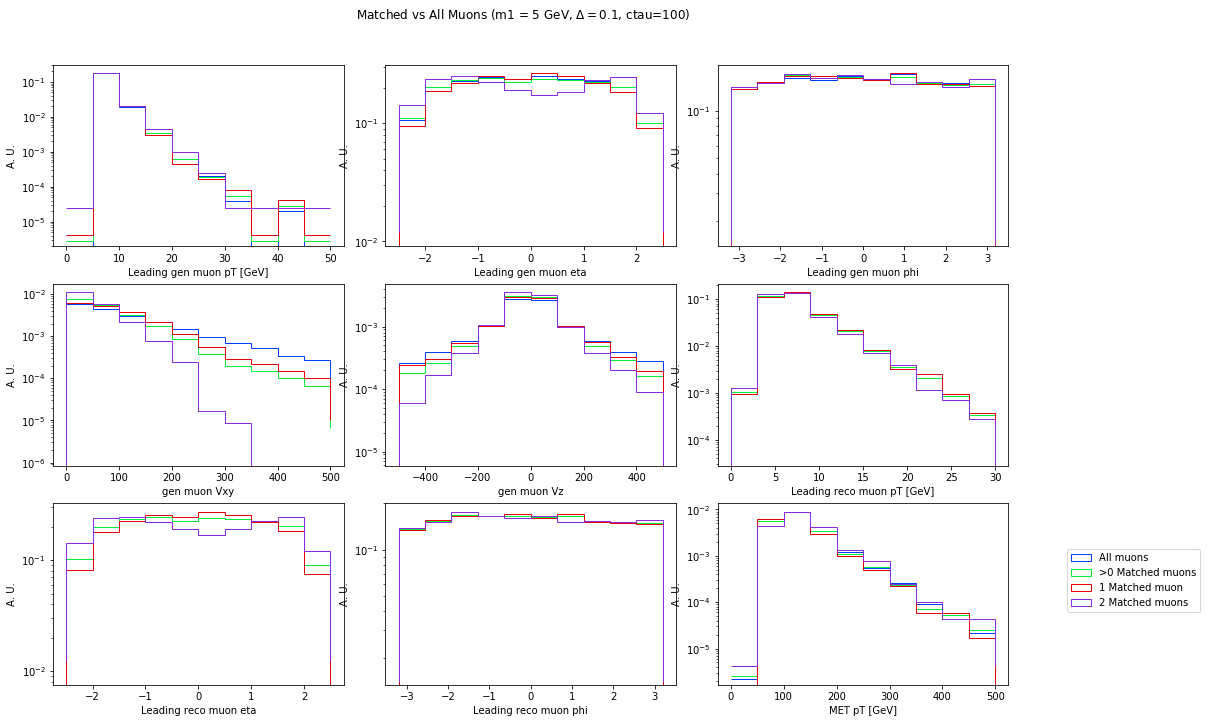

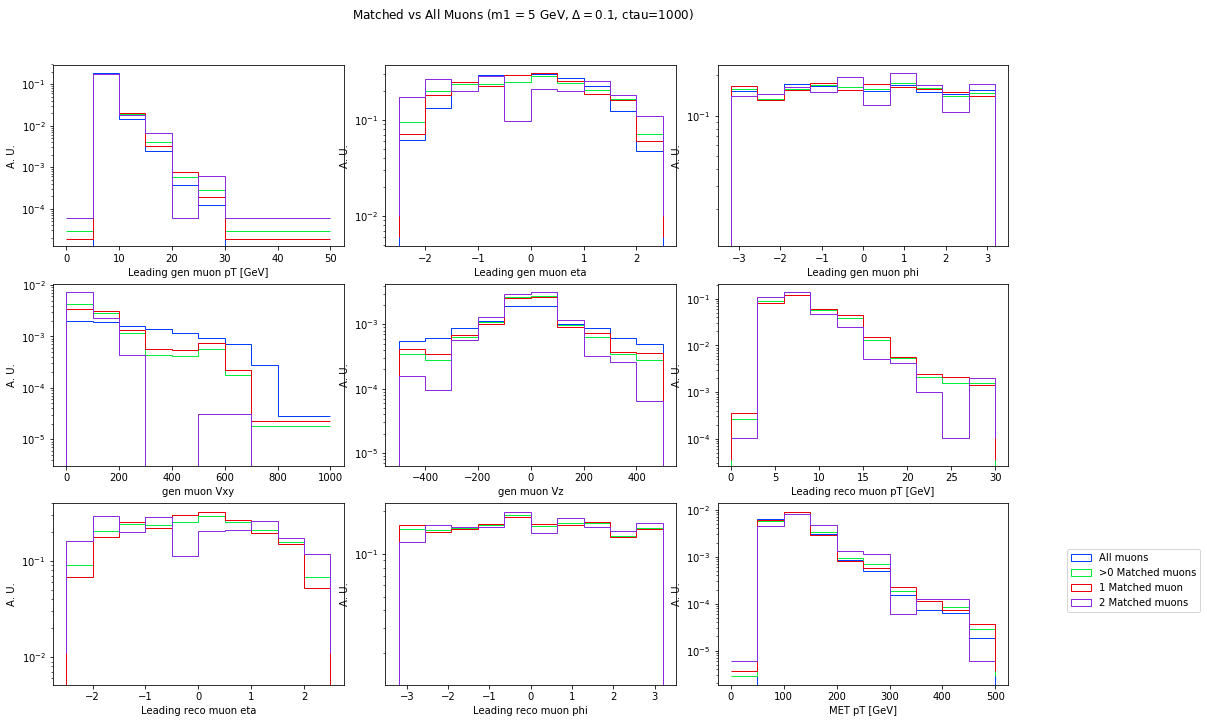

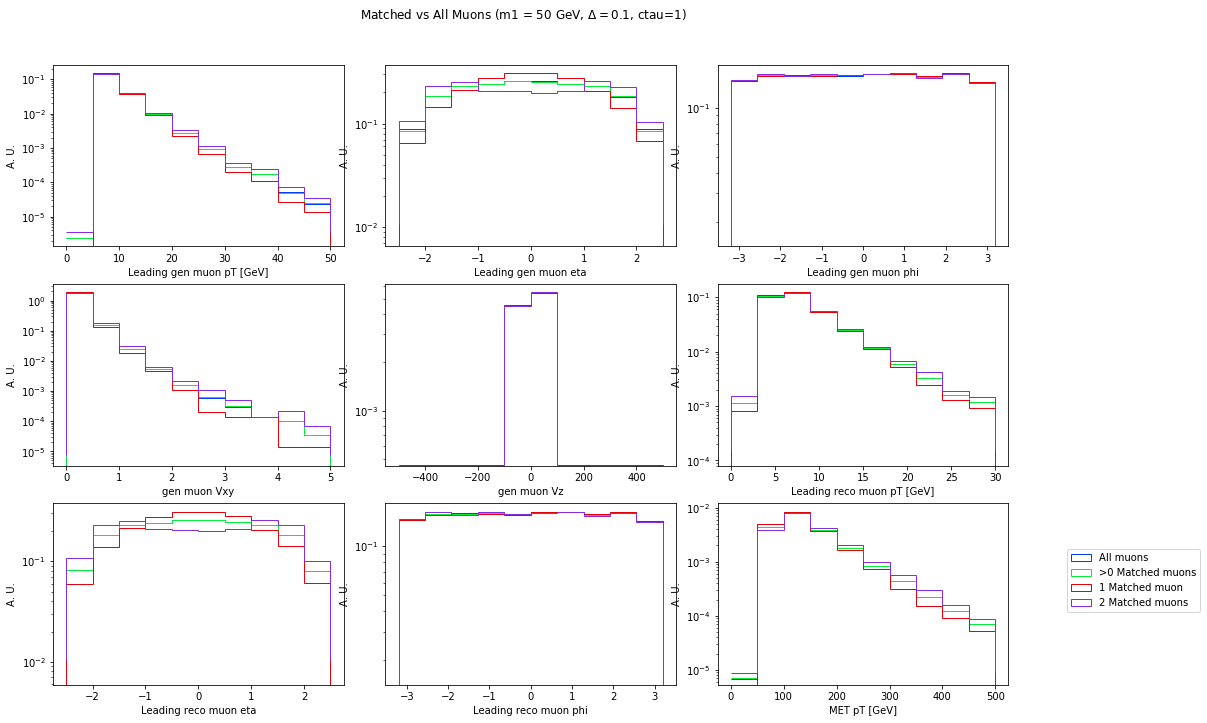

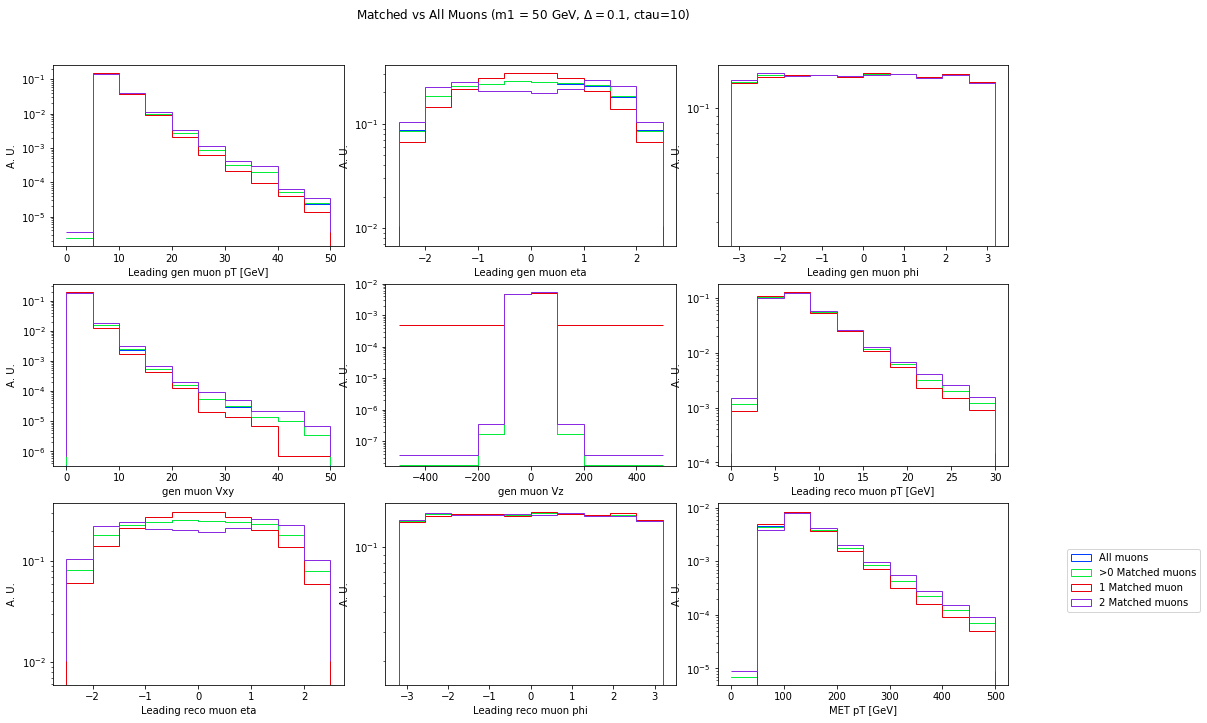

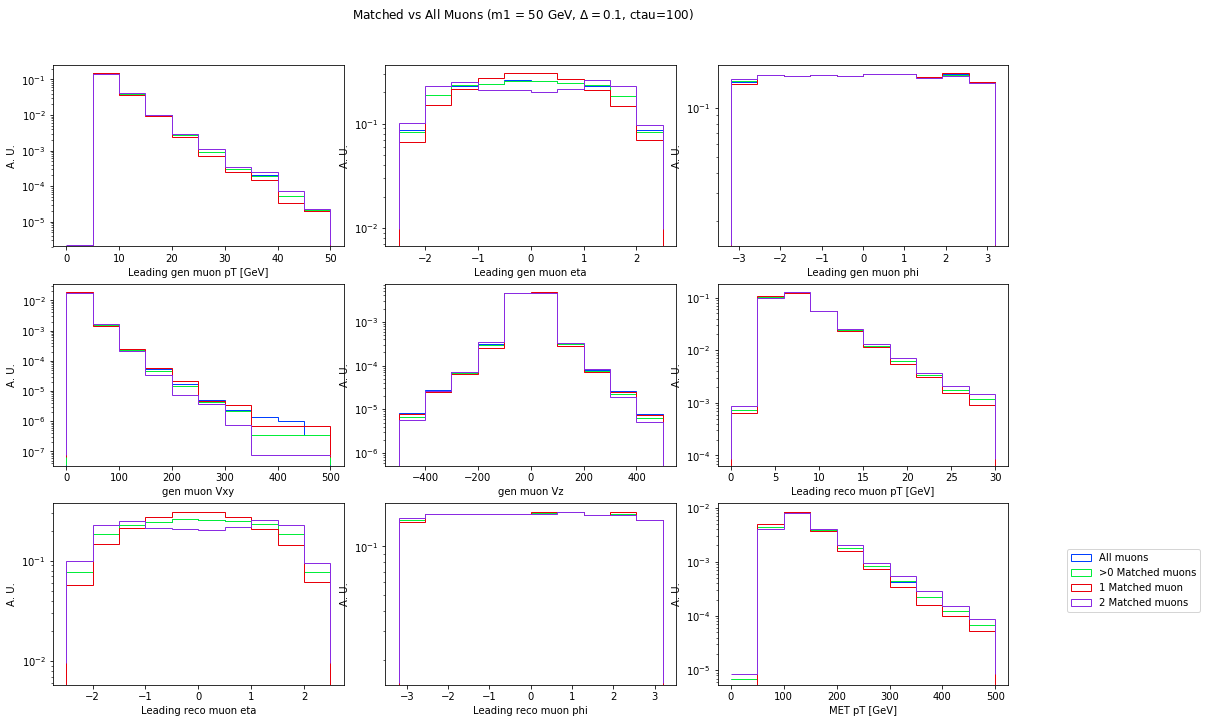

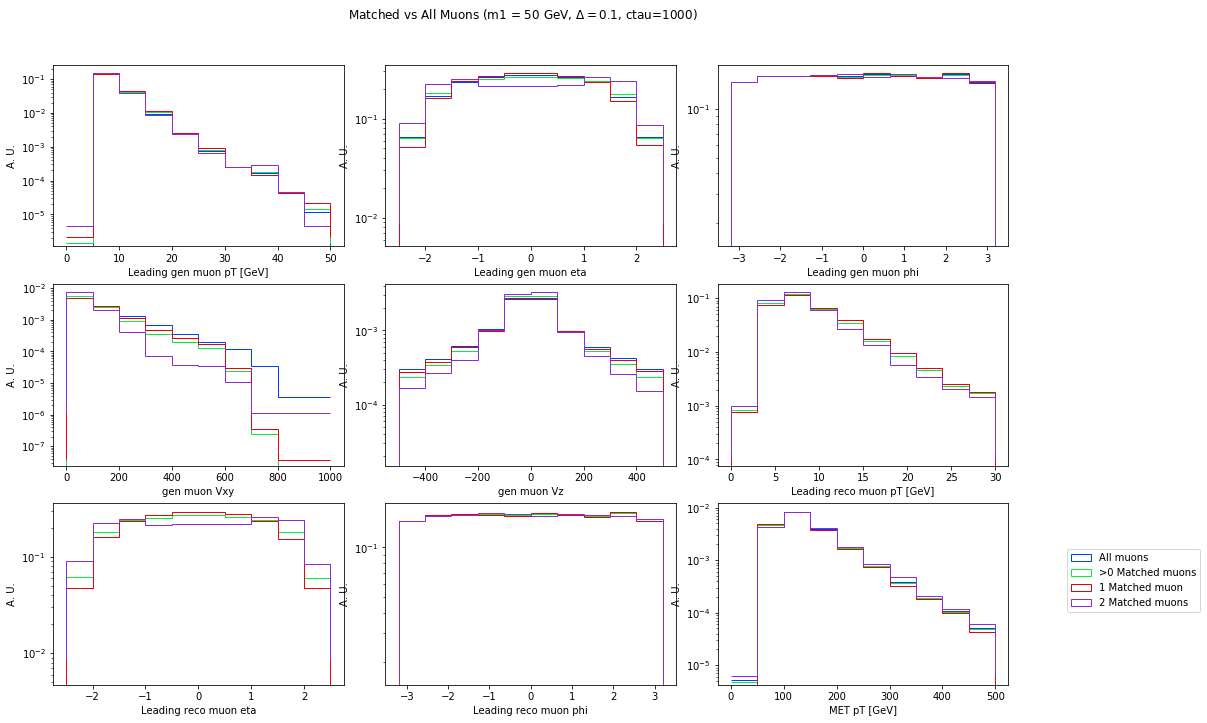

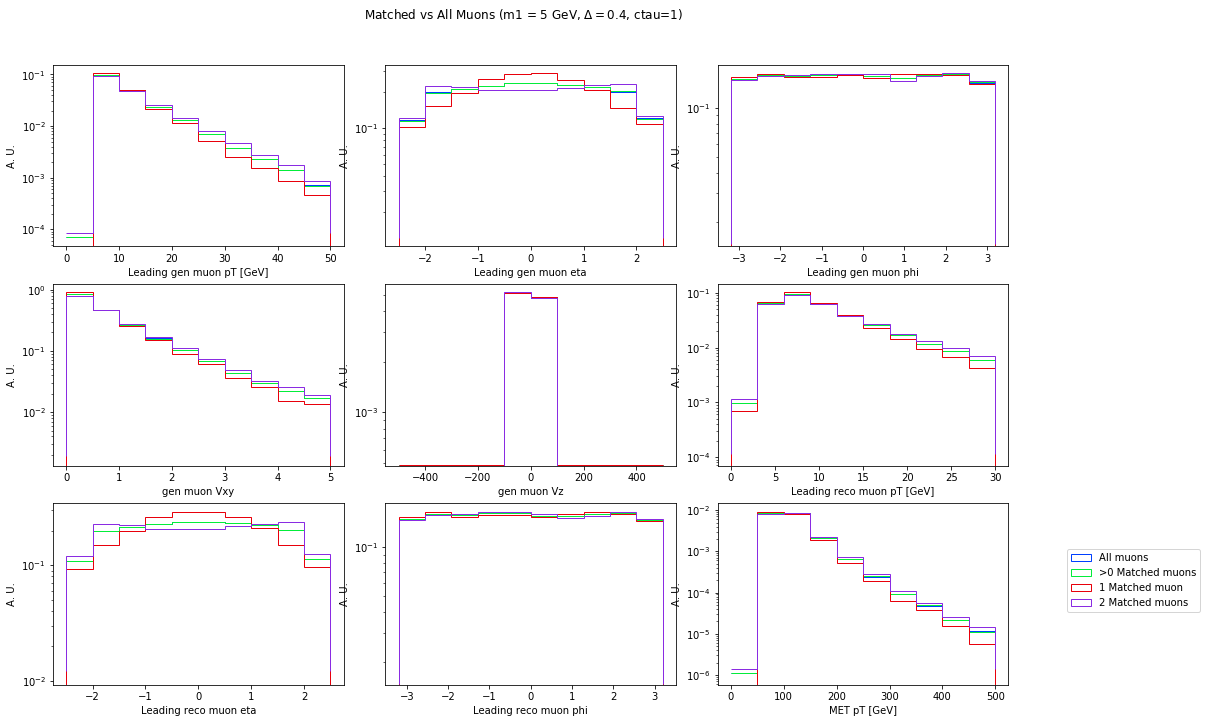

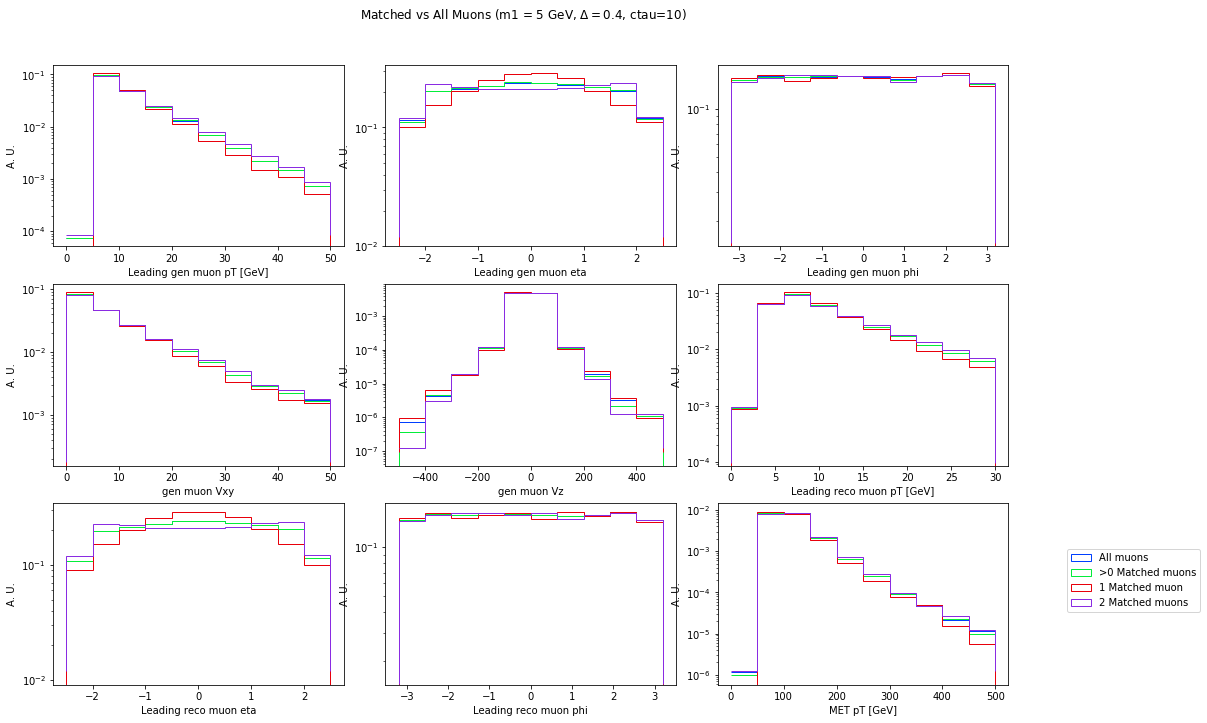

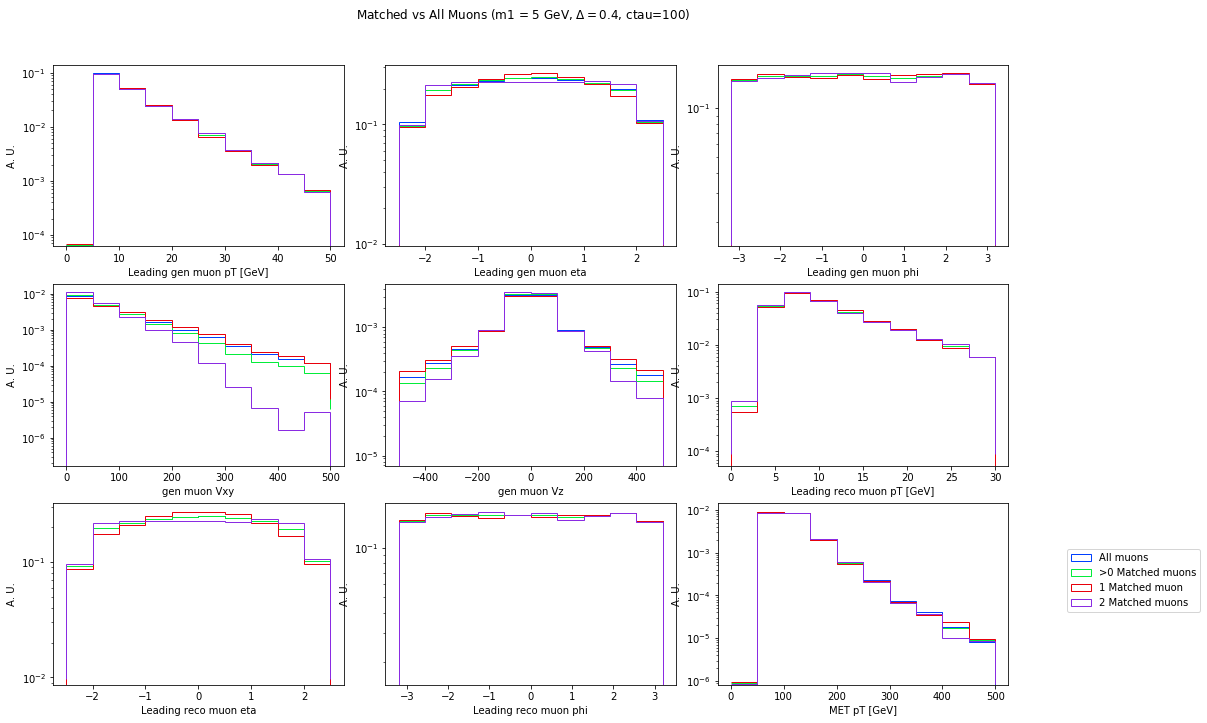

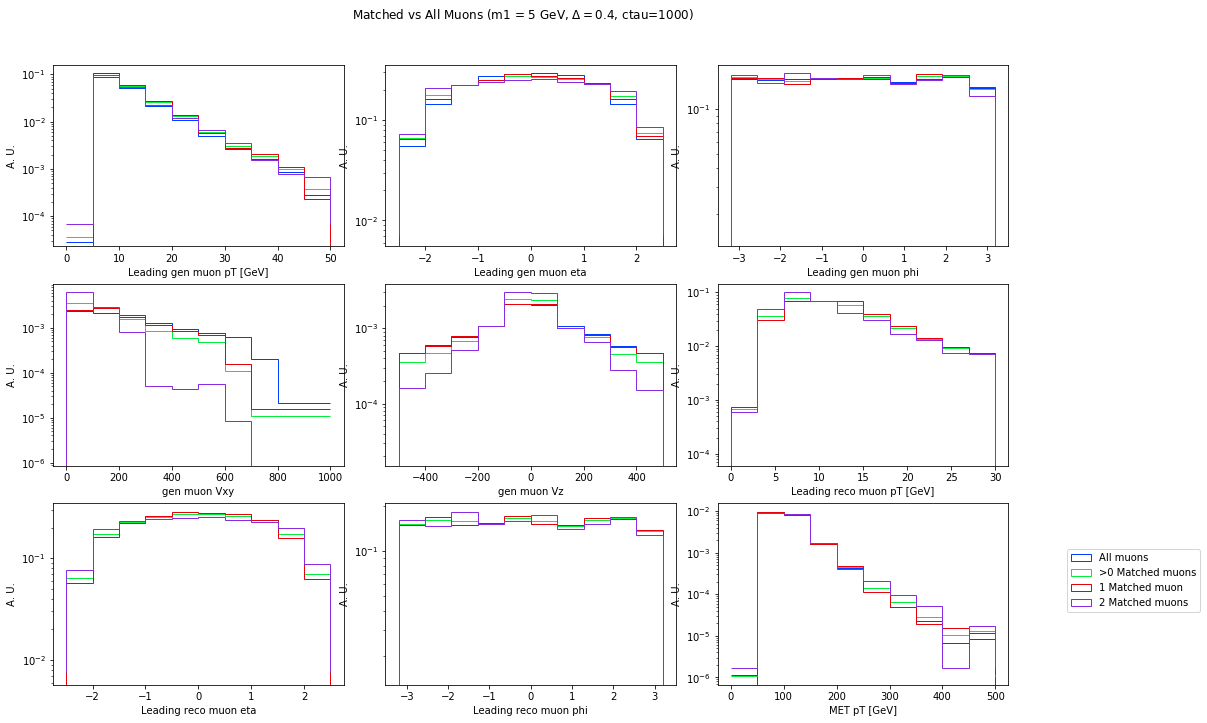

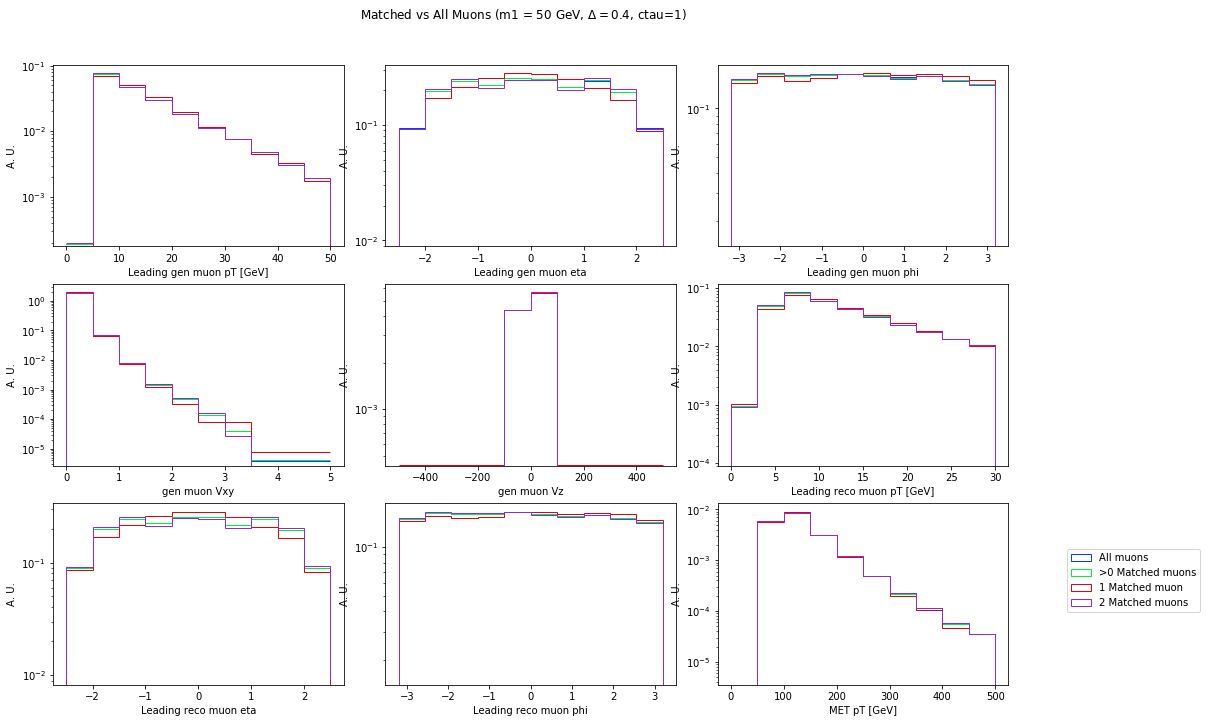

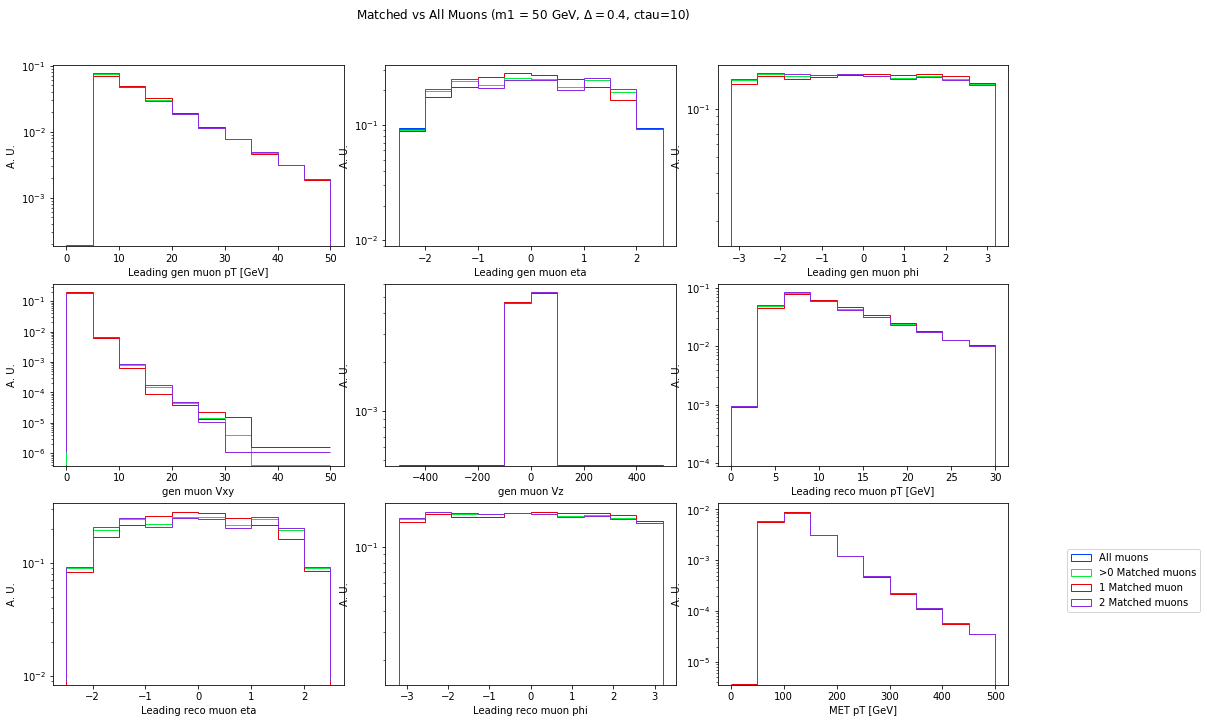

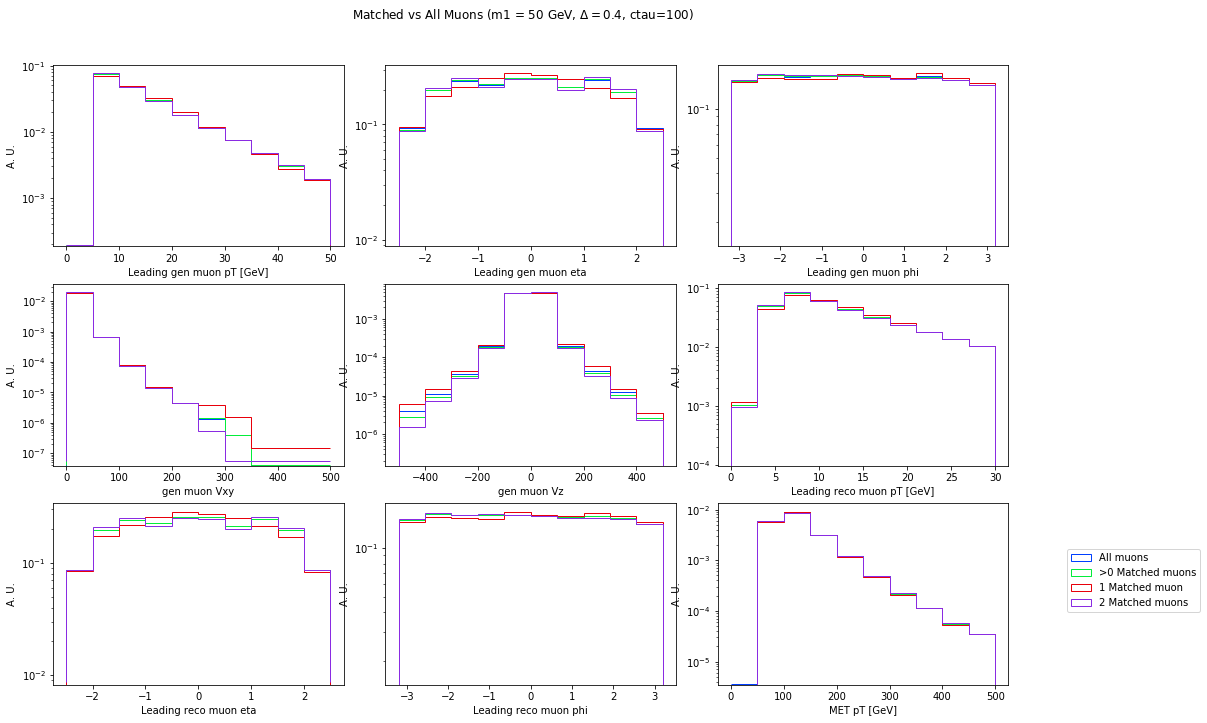

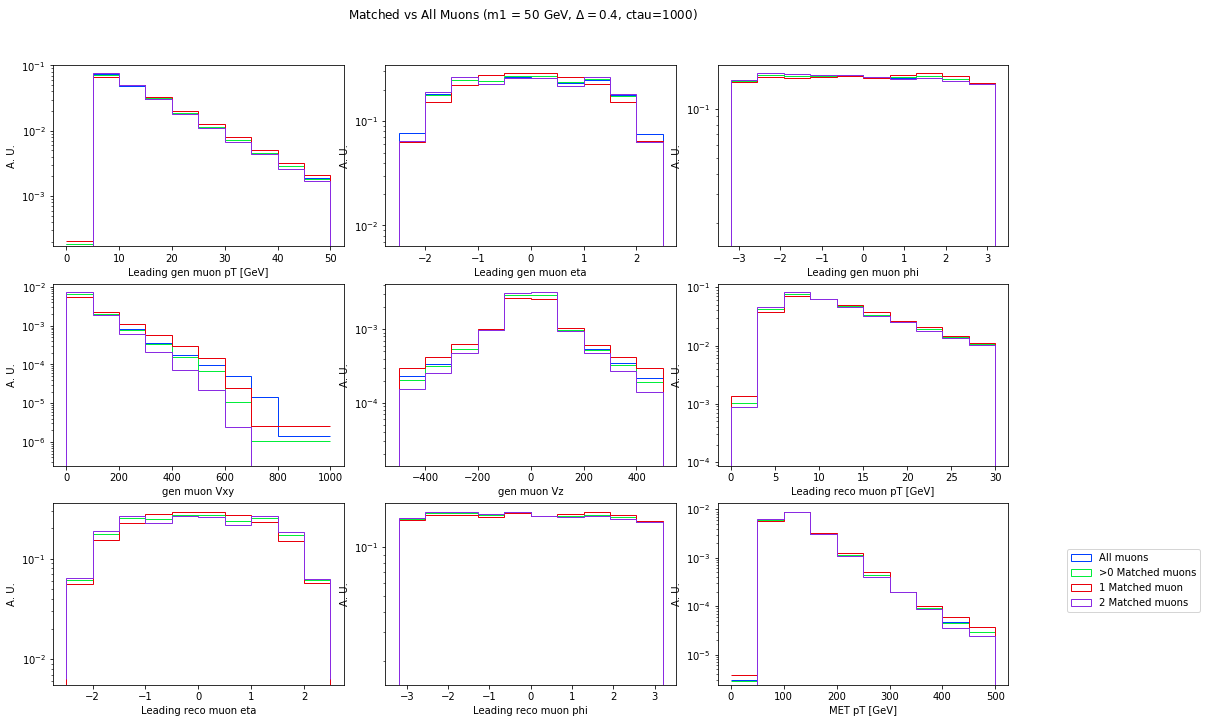

In [12]:
#sample = '52p5-100'
for sample in samples:
    fig, axes = plt.subplots(3,3, figsize=(14,10))
    fig.suptitle(f'Matched vs All Muons ({samples[sample]["label"]})')
    plt.tight_layout(h_pad=2.0)
    fig.subplots_adjust(top=0.90)
    binn= 1000 if samples[sample]['ctau']=='1000' else 5*int(samples[sample]['ctau'])
    eff_plots['genVxy']['range']= [0,binn]

    for index, (column, props) in enumerate(eff_plots.items()):
        ax = axes[index//3, index%3]
    
        bin_edges = props['axis']
        kwargs = {'range': props['range'], 'bins':10, 'density': True, 'histtype':'step','log':True}
    
        df = samples[sample]['dsa_df_ptcut'] if ptcut else samples[sample]['dsa_df']
        ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
            label='All muons');
        ax.hist(df.query('nMatched>0')[column].groupby('entry').nth(0), **kwargs, 
            label='>0 Matched muons');
        ax.hist(df.query('nMatched==1')[column].groupby('entry').nth(0), **kwargs, 
            label='1 Matched muon');
        ax.hist(df.query('nMatched==2')[column].groupby('entry').nth(0), **kwargs, 
            label='2 Matched muons');
        ax.set_xlabel(props['label'])
        ax.set_ylabel('A. U.')

    ax.legend(loc=(1.2 ,0.4))
    fig.savefig(f'{web_dir}/dsamatched_vs_allMu_log_{sample}.png', bbox_inches='tight')

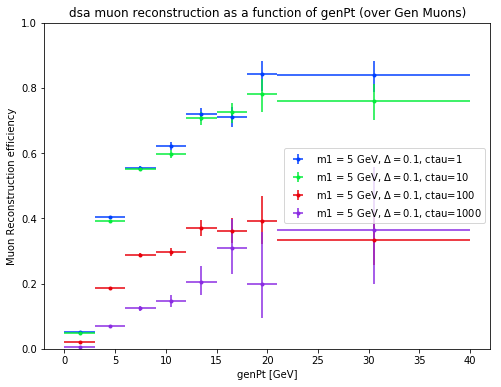

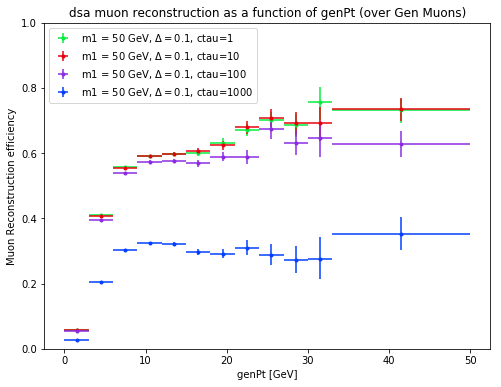

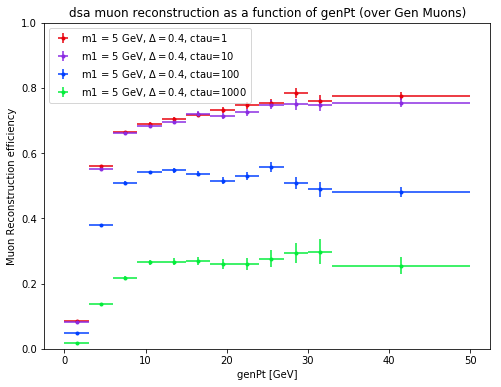

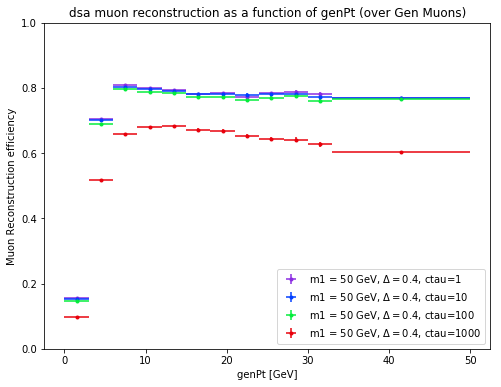

In [13]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']
ptcut = False
for mass in mchis:
    fig, ax = plt.subplots(figsize=(8,6))
    eff_plots['genPt']['axis']= np.array(np.append(np.arange(0,24,3), [40]), dtype='float64') if mass is '5p25' else np.array(np.append(np.arange(0,35,3),[50]), dtype='float64')
    #eff_plots['genPt']['axis']= np.array(np.append(np.arange(0,24,6), [50]), dtype='float64') if mass is '5p25' else np.array(np.append(np.arange(0,30,6), [50]), dtype='float64')

    for ctau in ctaus:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genPt', eff_plots['genPt'], event_selection='dsa_df_ptcut' if ptcut else 'dsa_df')
    fig.savefig(f'{web_dir}/dsaReco_vs_genPt_mass_{mass}.png', bbox_inches='tight')

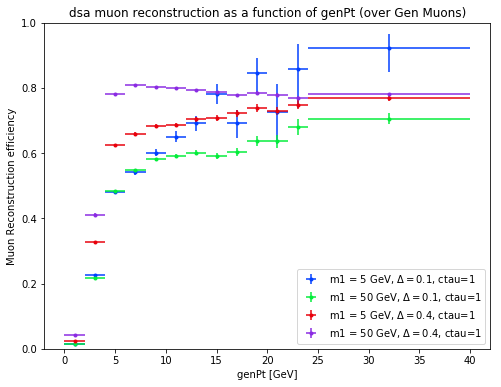

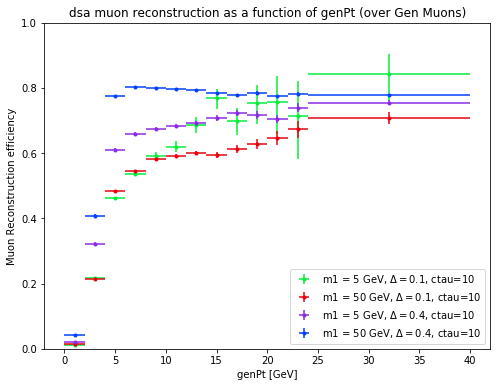

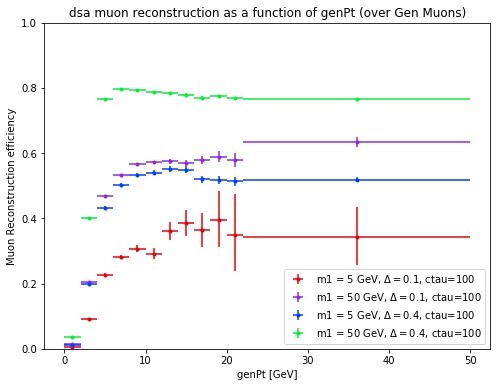

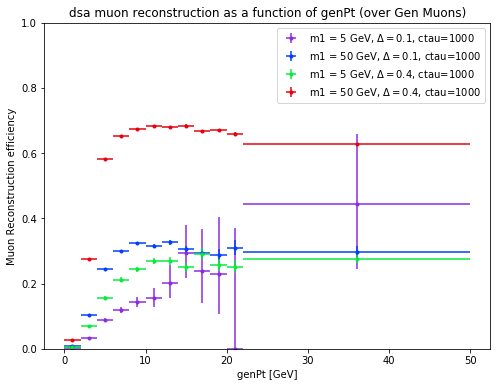

In [14]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']
for ctau in ctaus:
    fig, ax = plt.subplots(figsize=(8,6))
    eff_plots['genPt']['axis']= np.array(np.append(np.arange(0,24,2), [50]), dtype='float64') if int(ctau) >= 100 else np.array(np.append(np.arange(0,25,2), [40]), dtype='float64')
    #eff_plots['genPt']['axis']= np.array(np.append(np.arange(0,24,6), [50]), dtype='float64') if int(ctau) >= 100 else np.array(np.append(np.arange(0,30,6), [50]), dtype='float64')

    for mass in mchis:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genPt', eff_plots['genPt'], event_selection='dsa_df')
    fig.savefig(f'{web_dir}/dsaReco_vs_genPt_ctau_{ctau}.png', bbox_inches='tight')

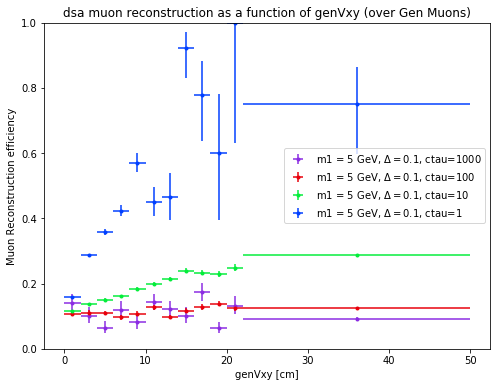

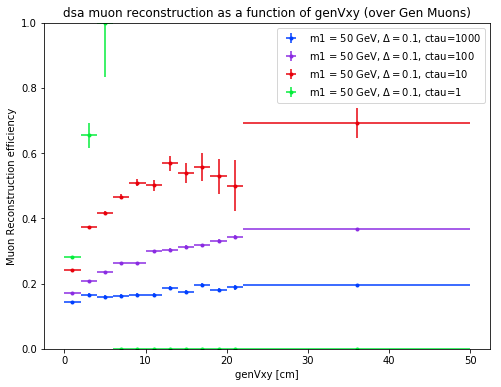

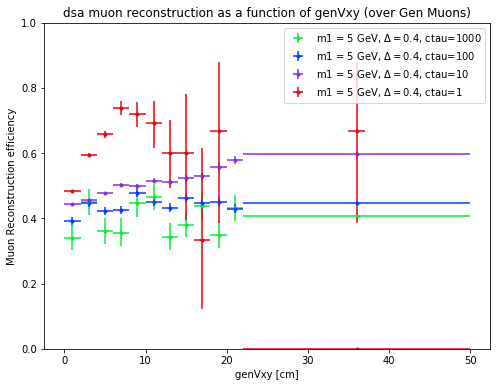

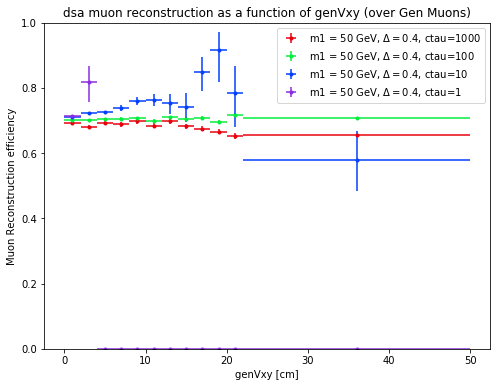

In [15]:
ctaus = ['1000','100','10','1']
mchis = ['5p25','52p5','6p0','60p0']
binn = {'5p25':20,'52p5':20,'6p0':5,'60p0':20}
for mass in mchis:
    fig, ax = plt.subplots(figsize=(8,6))
    #eff_plots['genVxy']['axis']= np.array(np.linspace(0,40,binn[mass]), dtype='float64')
    eff_plots['genVxy']['axis']=np.array(np.append(np.arange(0,24,2), [50]), dtype='float64')
    #eff_plots['genVxy']['axis']= np.array(np.arange(0,10,5), dtype='float64')
    for ctau in ctaus:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genVxy', eff_plots['genVxy'], event_selection='dsa_df')
    fig.savefig(f'{web_dir}/dsaReco_vs_genVxy_mass_{mass}.png', bbox_inches='tight')

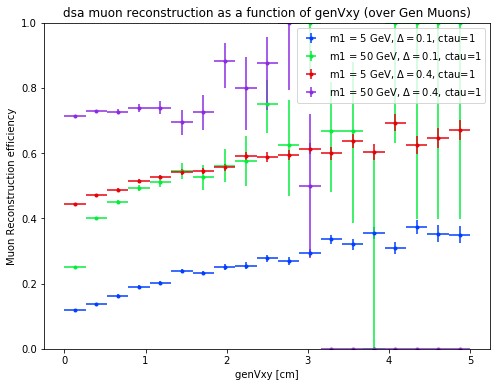

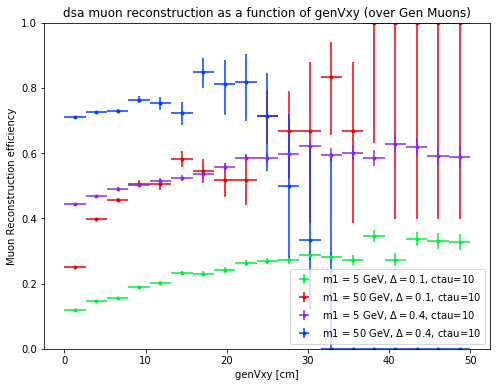

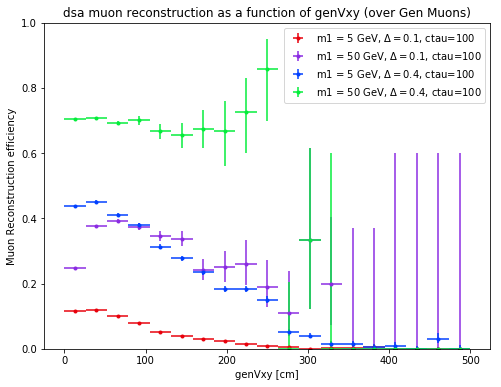

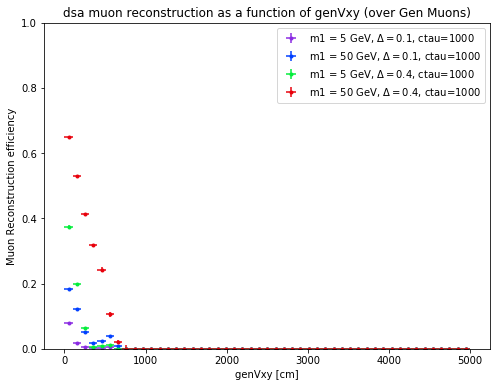

In [16]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']
for ctau in ctaus:
    fig, ax = plt.subplots(figsize=(8,6))
    binn= 50 if ctau=='1000' else 20
    eff_plots['genVxy']['axis']= np.array(np.linspace(0,5*int(ctau),binn), dtype='float64')
    for mass in mchis:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genVxy', eff_plots['genVxy'], event_selection='dsa_df')
    fig.savefig(f'{web_dir}/dsaReco_vs_genVxy_ctau_{ctau}.png', bbox_inches='tight')

# gbm muons

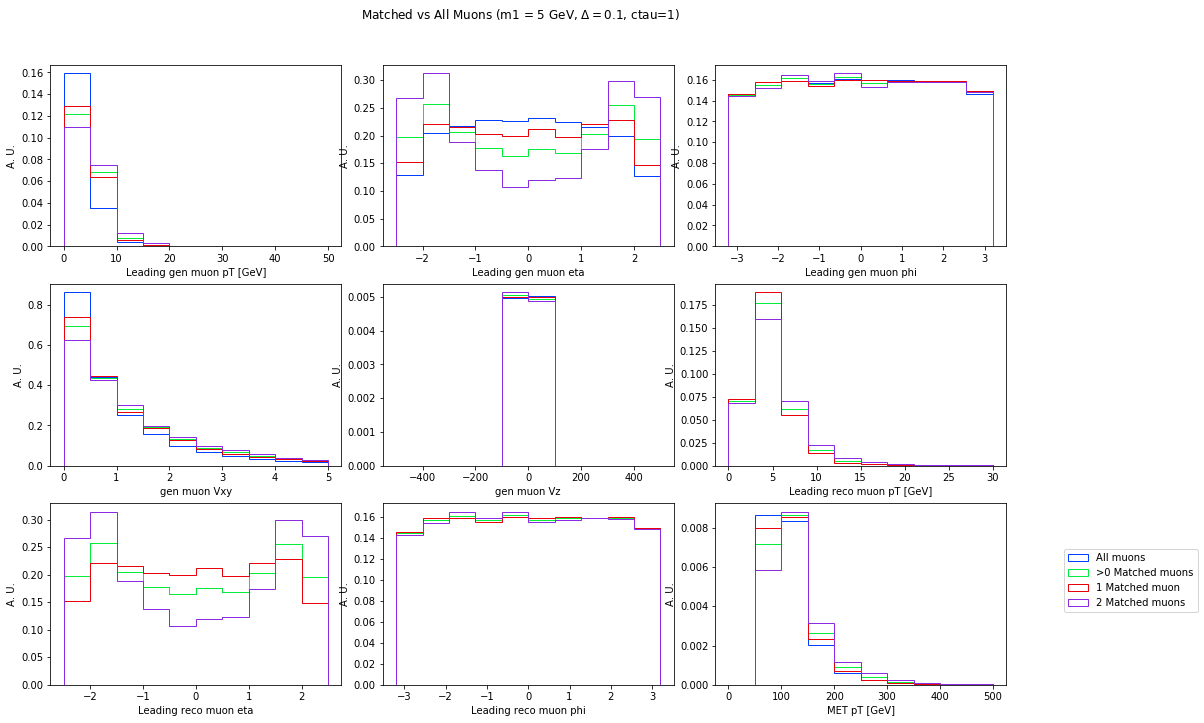

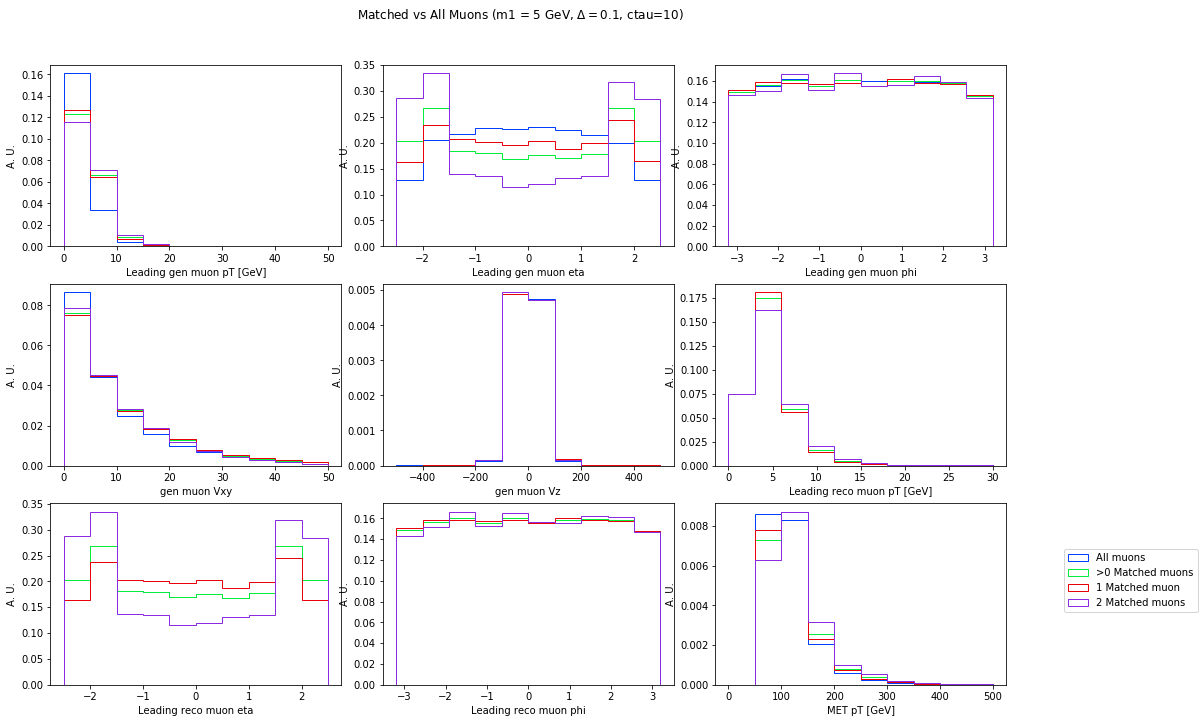

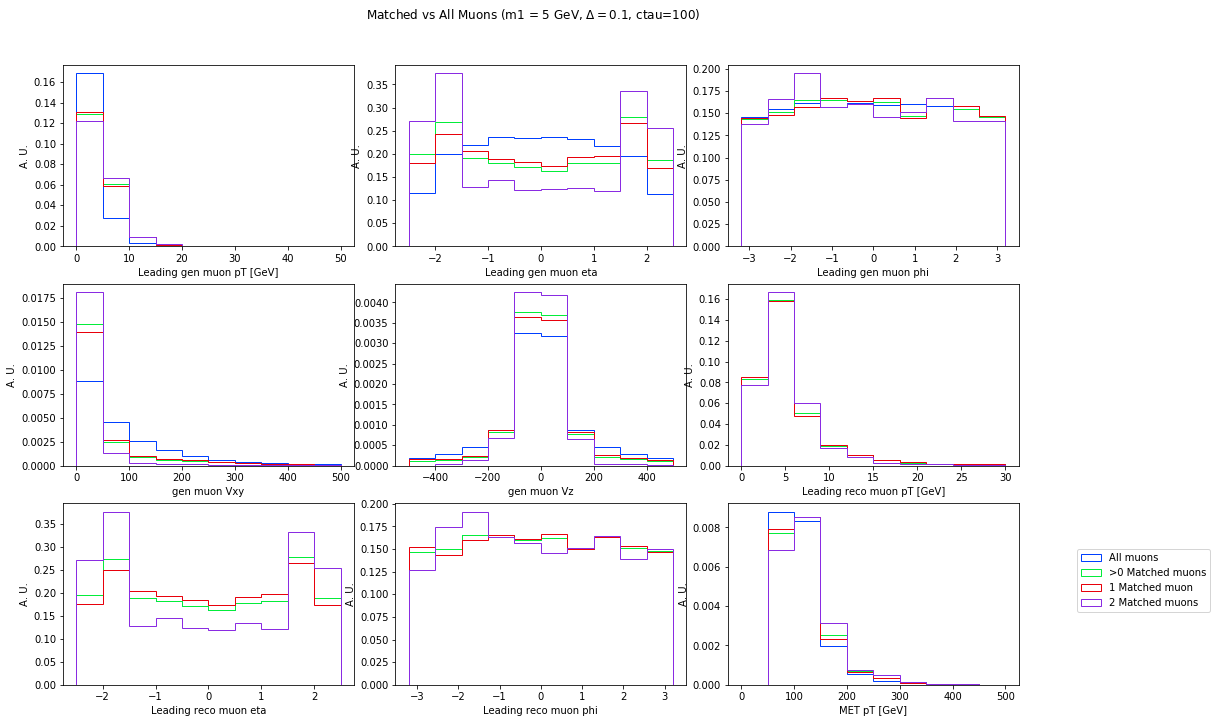

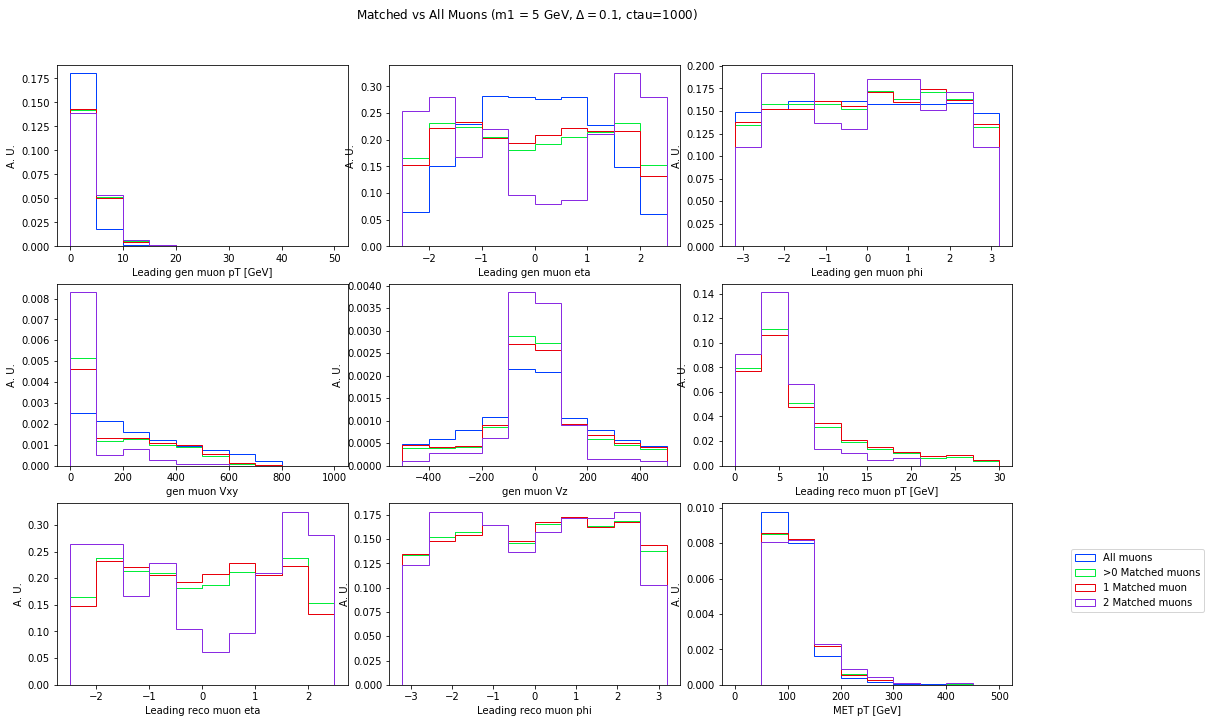

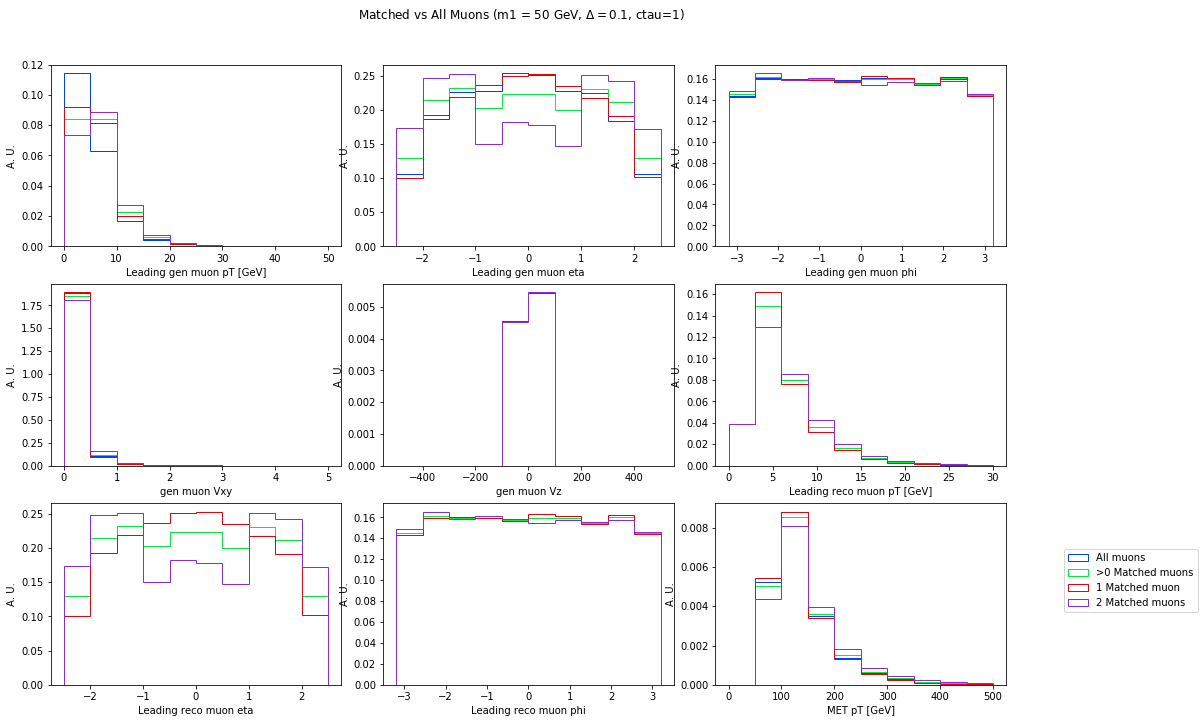

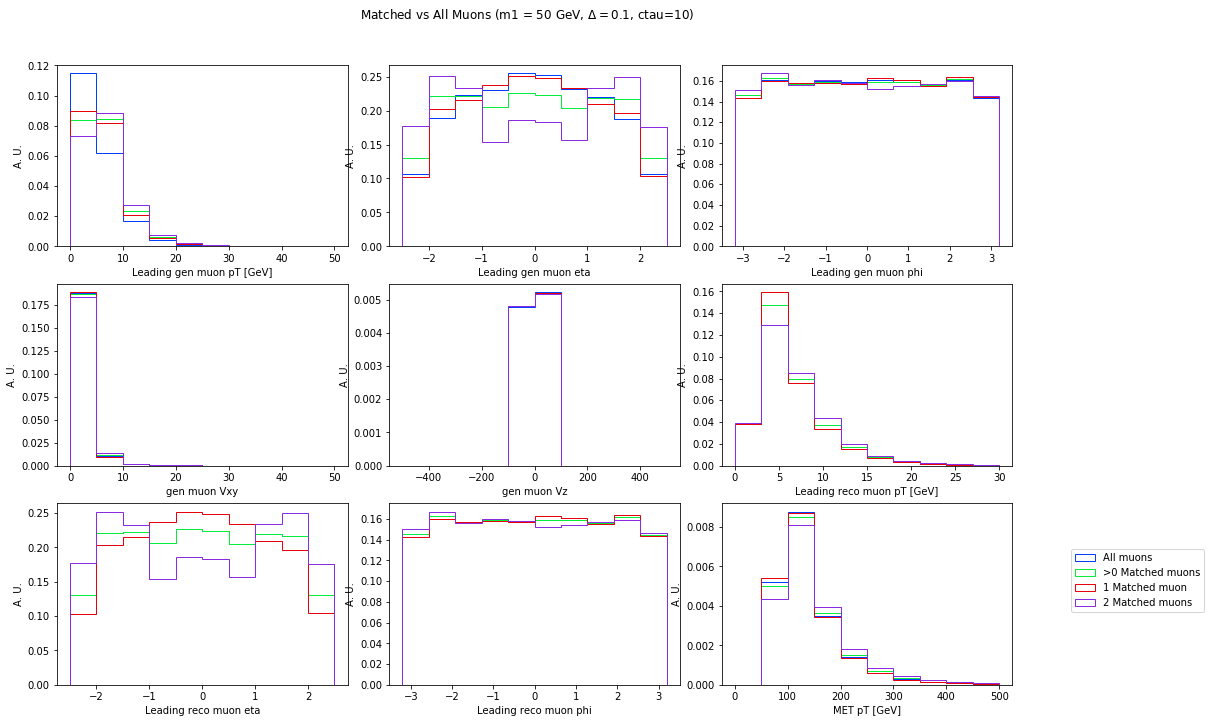

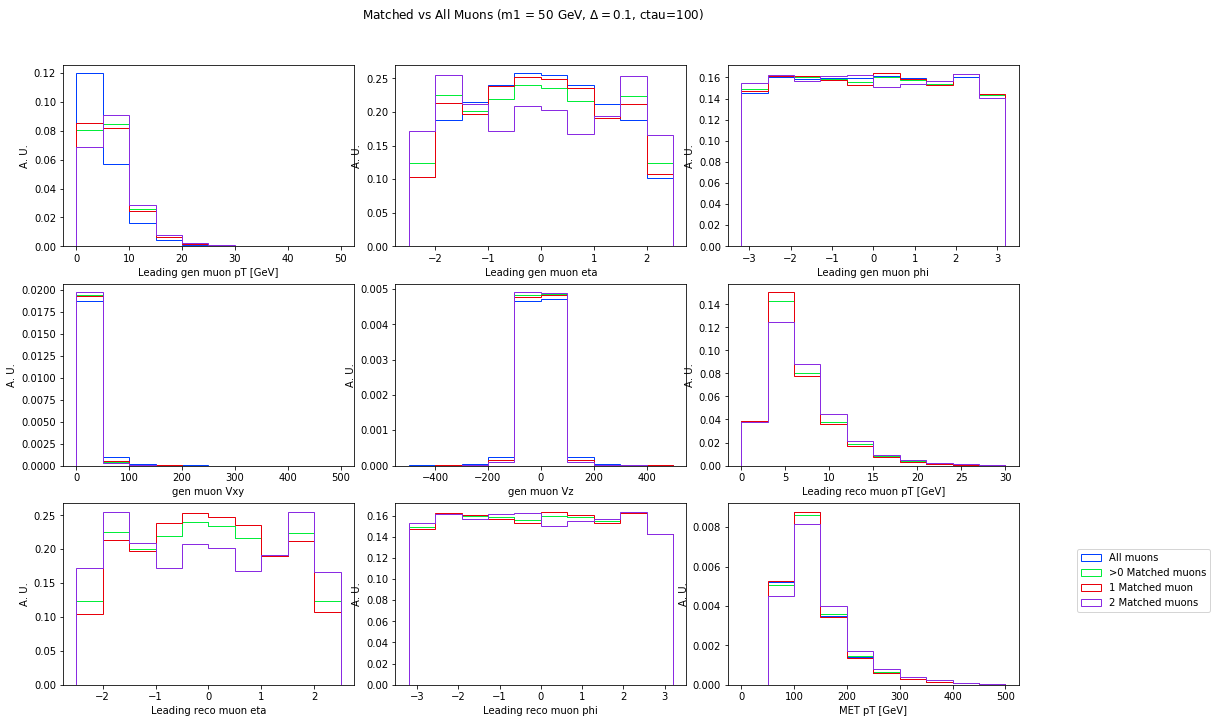

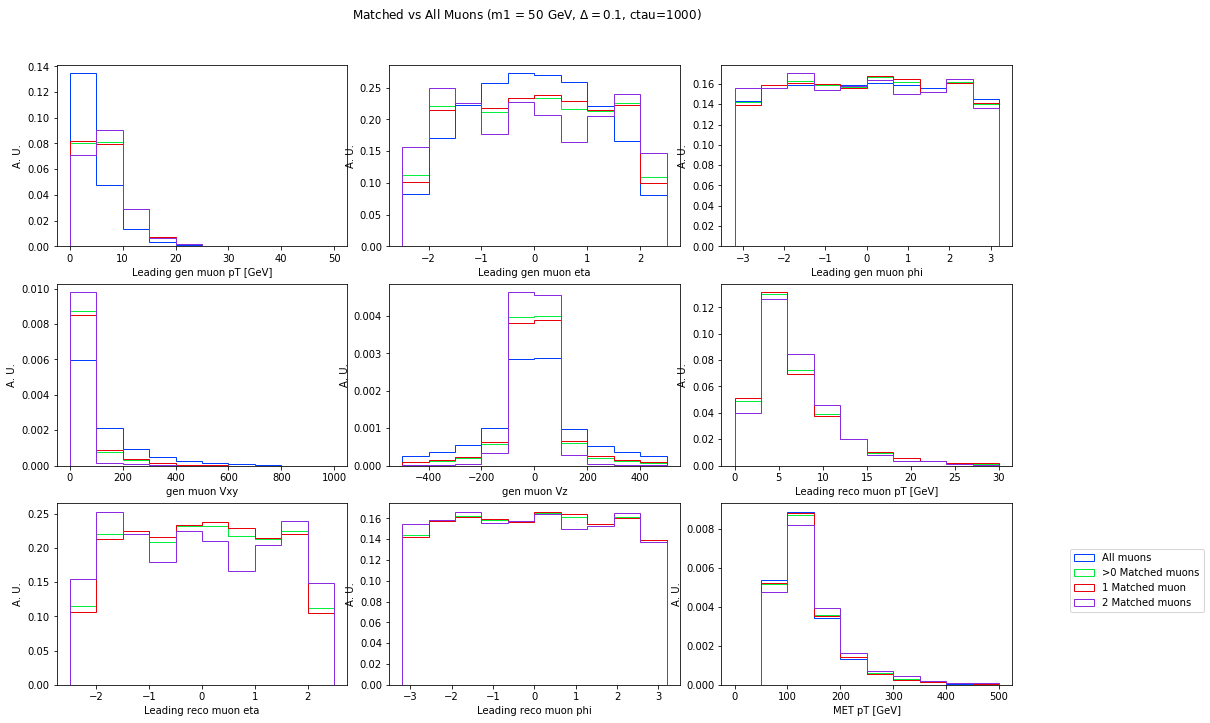

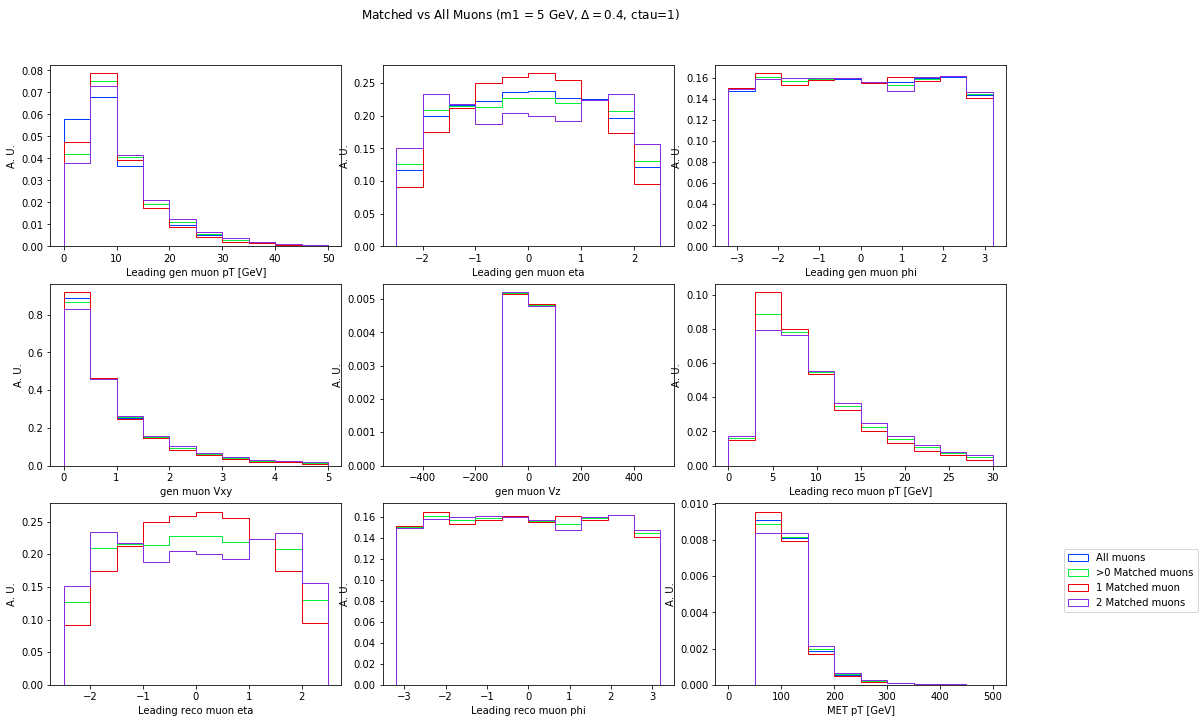

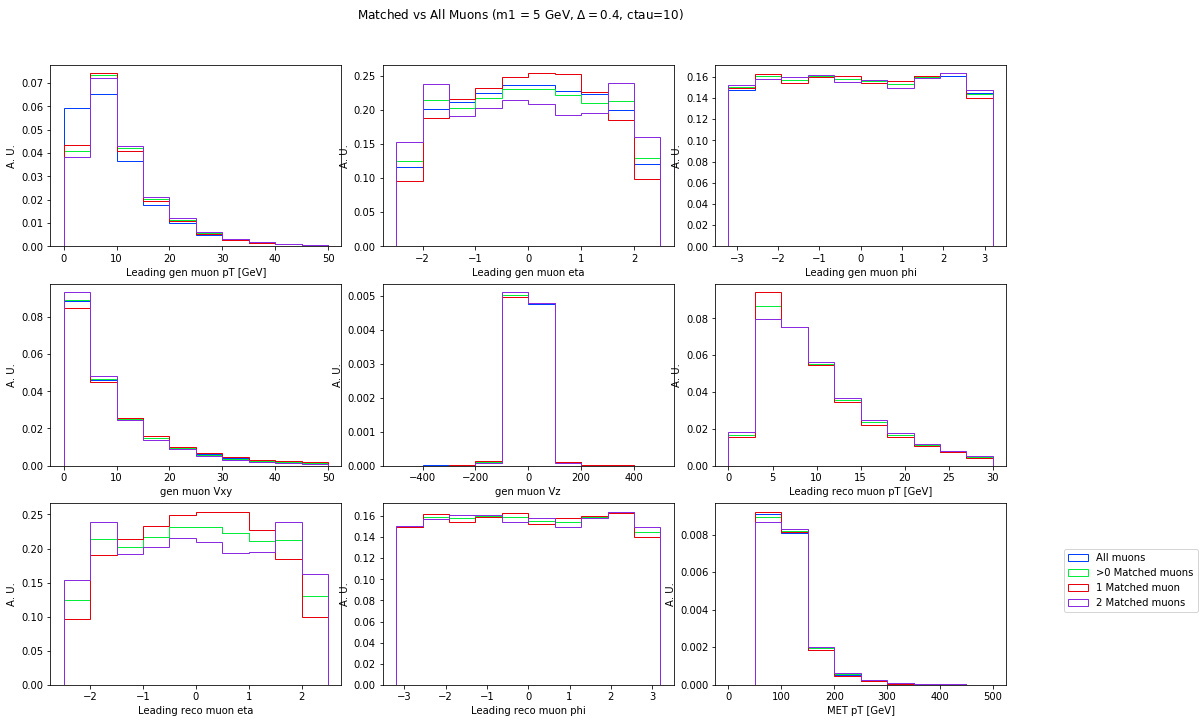

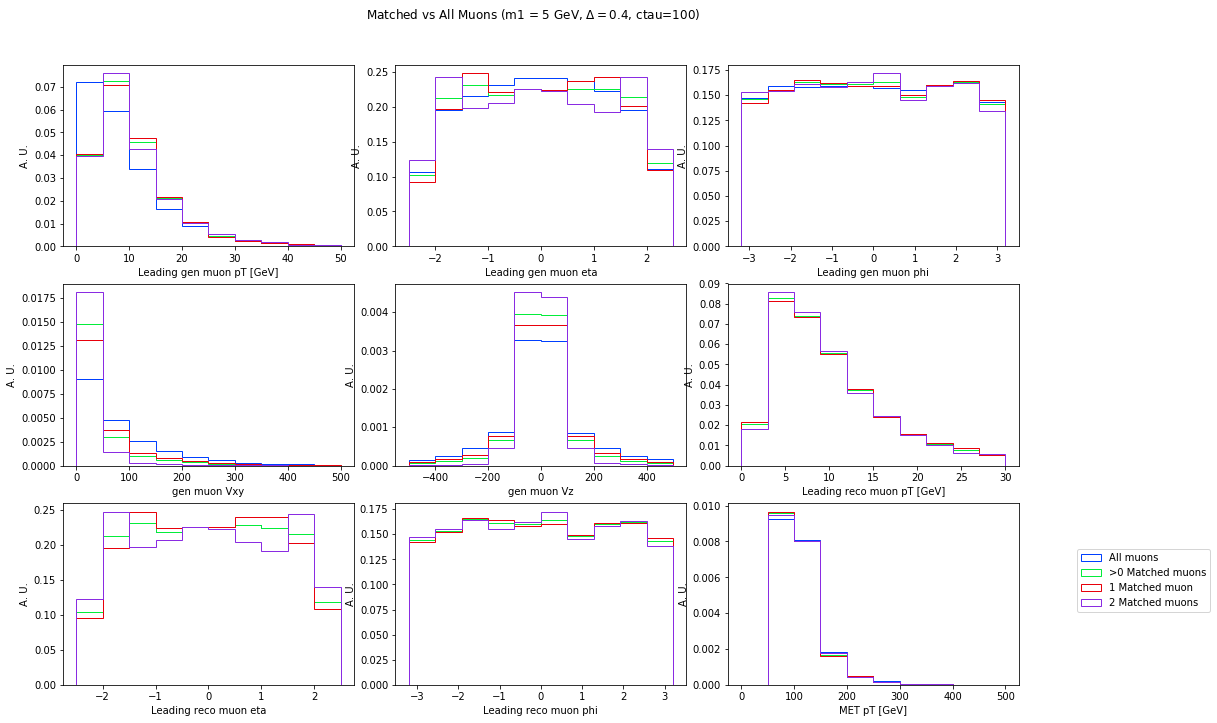

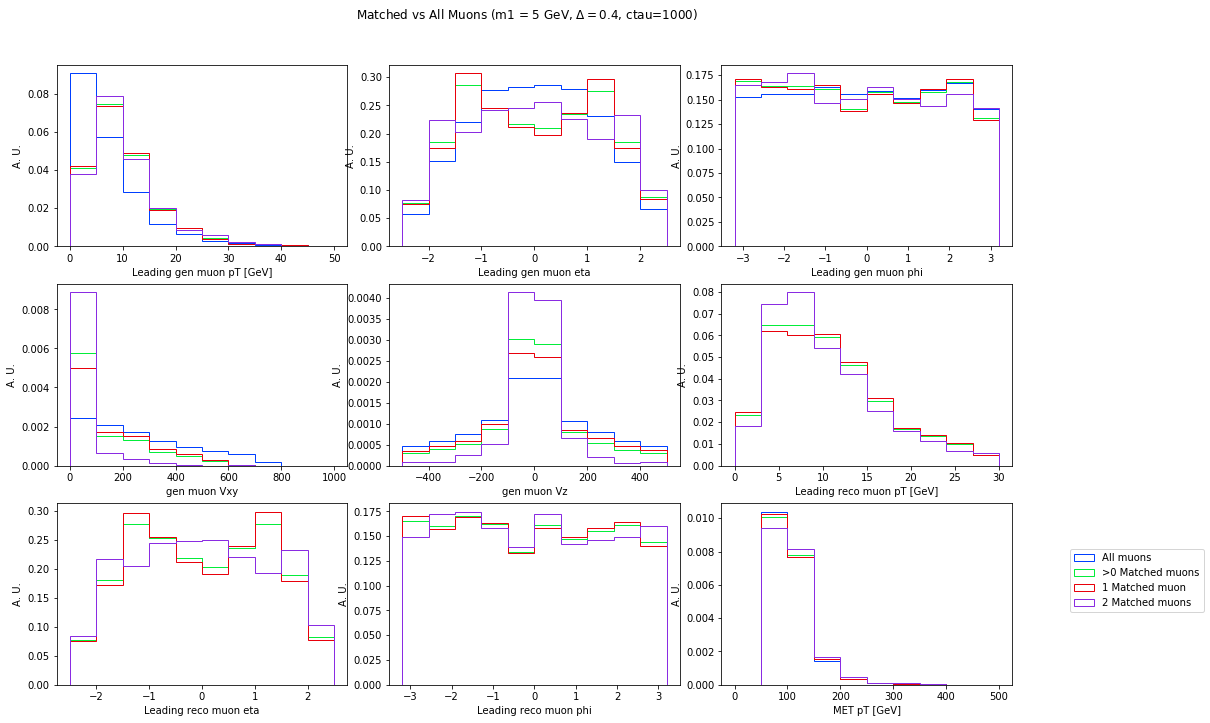

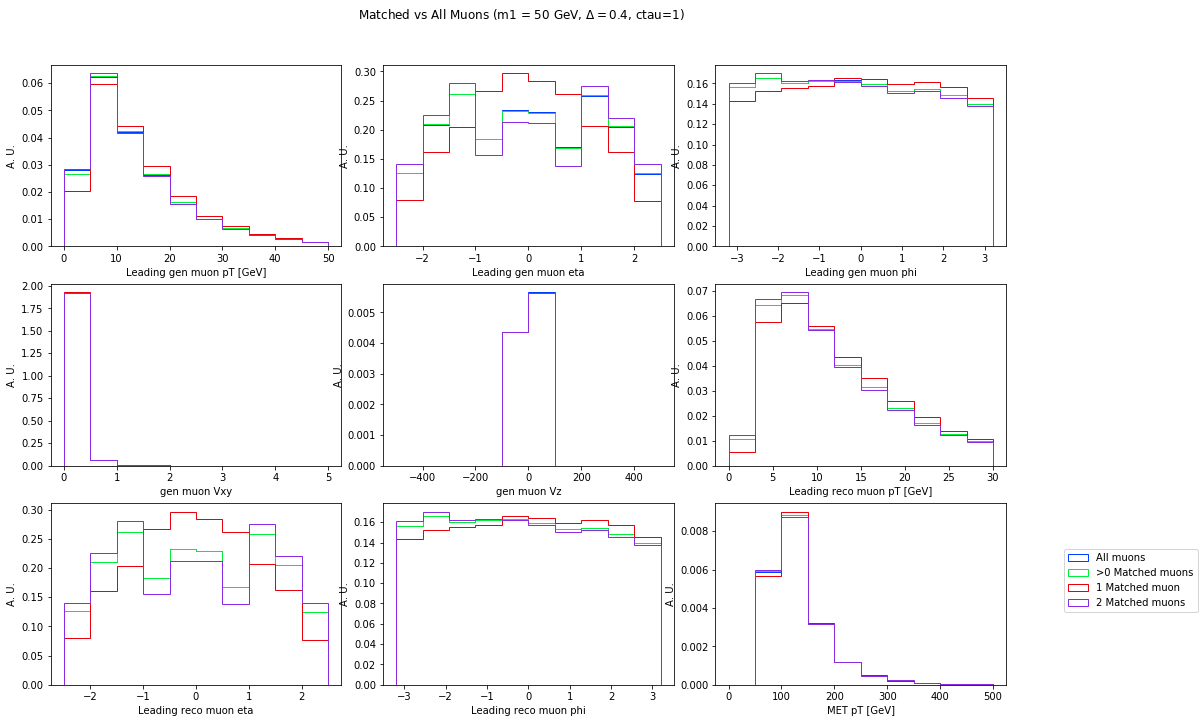

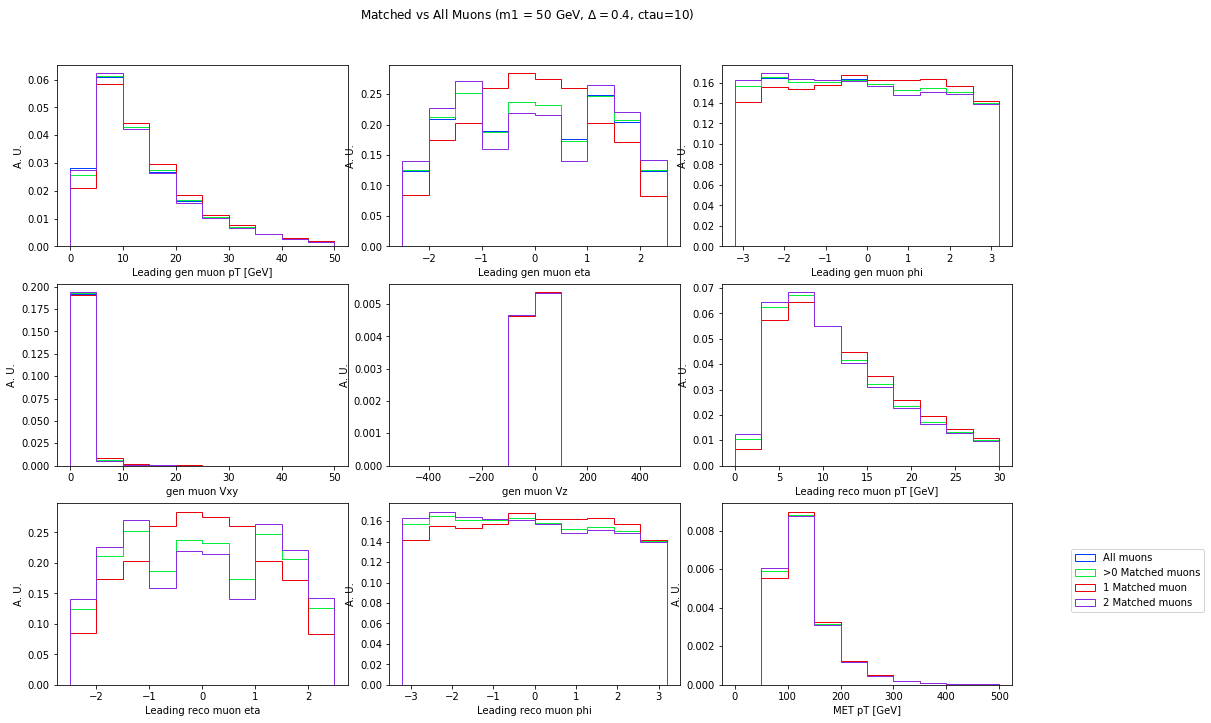

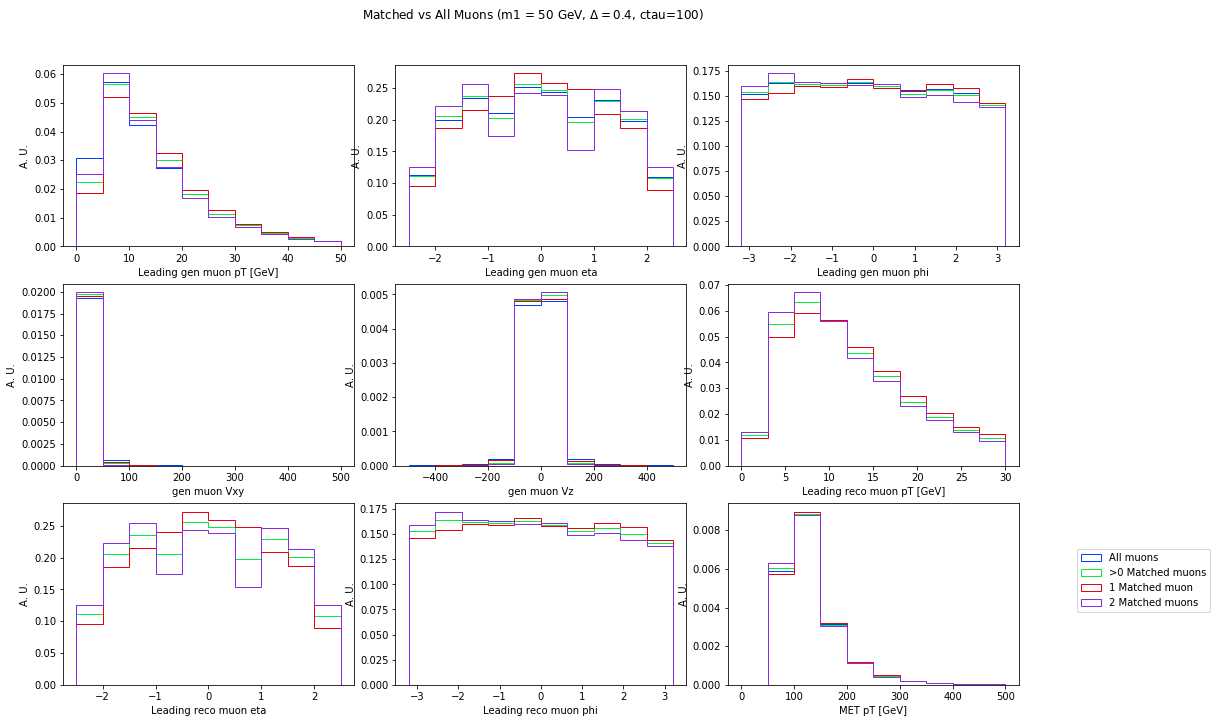

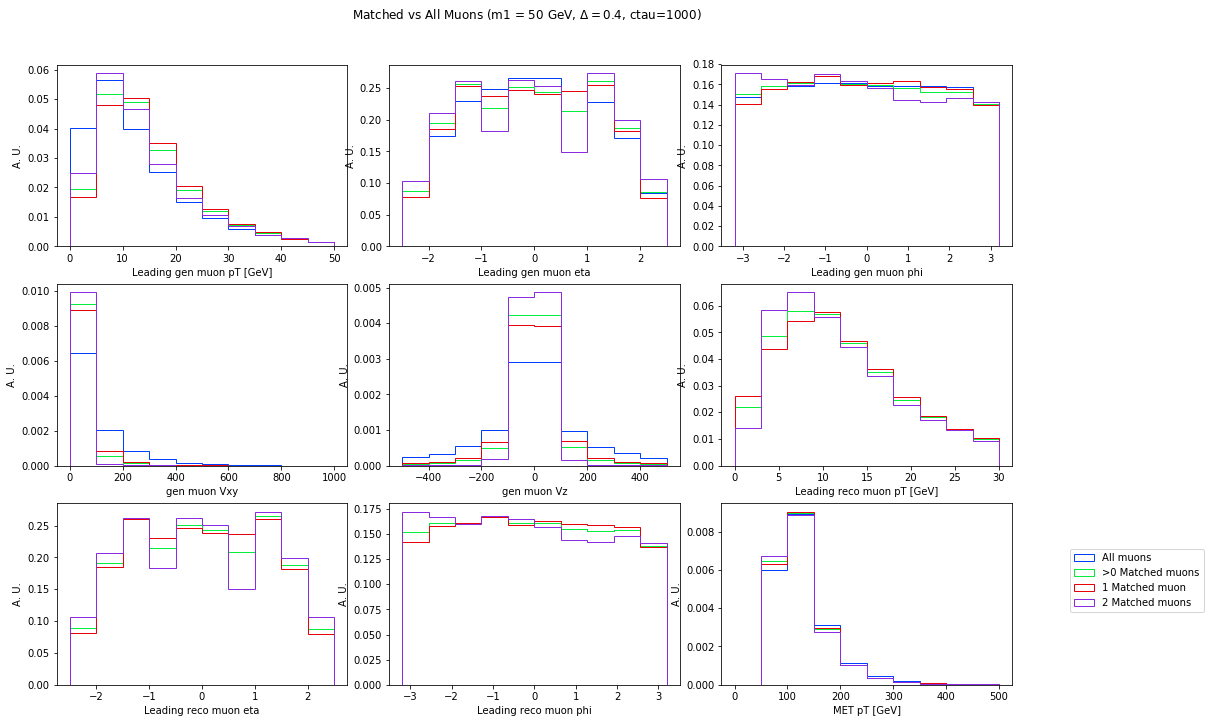

In [17]:
#sample = '52p5-100'
for sample in samples:
    fig, axes = plt.subplots(3,3, figsize=(14,10))
    fig.suptitle(f'Matched vs All Muons ({samples[sample]["label"]})')
    plt.tight_layout(h_pad=2.0)
    fig.subplots_adjust(top=0.90)
    binn= 1000 if samples[sample]['ctau']=='1000' else 5*int(samples[sample]['ctau'])
    eff_plots['genVxy']['range']= [0,binn]
    for index, (column, props) in enumerate(eff_plots.items()):
        ax = axes[index//3, index%3]
        
        bin_edges = props['axis']
        kwargs = {'range': props['range'], 'bins':10, 'density': True, 'histtype':'step','log':False}
    
        df = samples[sample]['gbm_df']
        ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
            label='All muons');
        ax.hist(df.query('nMatched>0')[column].groupby('entry').nth(0), **kwargs, 
            label='>0 Matched muons');
        ax.hist(df.query('nMatched==1')[column].groupby('entry').nth(0), **kwargs, 
            label='1 Matched muon');
        ax.hist(df.query('nMatched==2')[column].groupby('entry').nth(0), **kwargs, 
            label='2 Matched muons');
        ax.set_xlabel(props['label'])
        ax.set_ylabel('A. U.')

    ax.legend(loc=(1.2 ,0.4))
    fig.savefig(f'{web_dir}/gbmmatched_vs_allMu_{sample}.png', bbox_inches='tight')

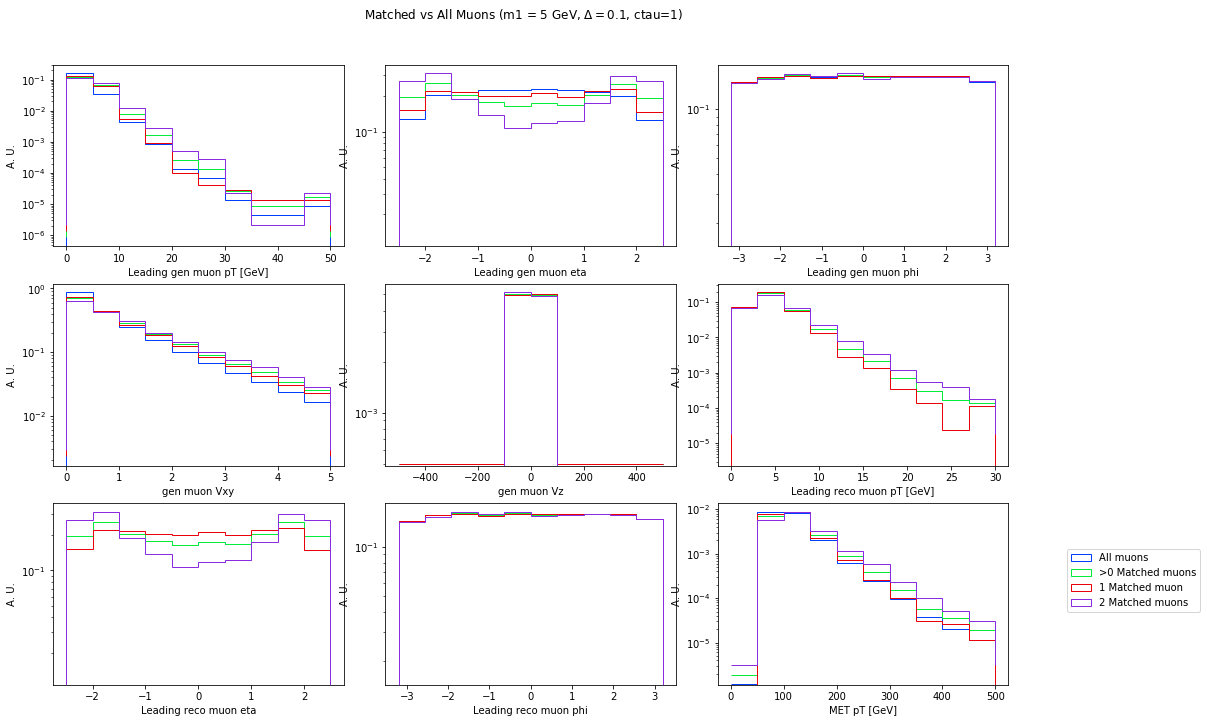

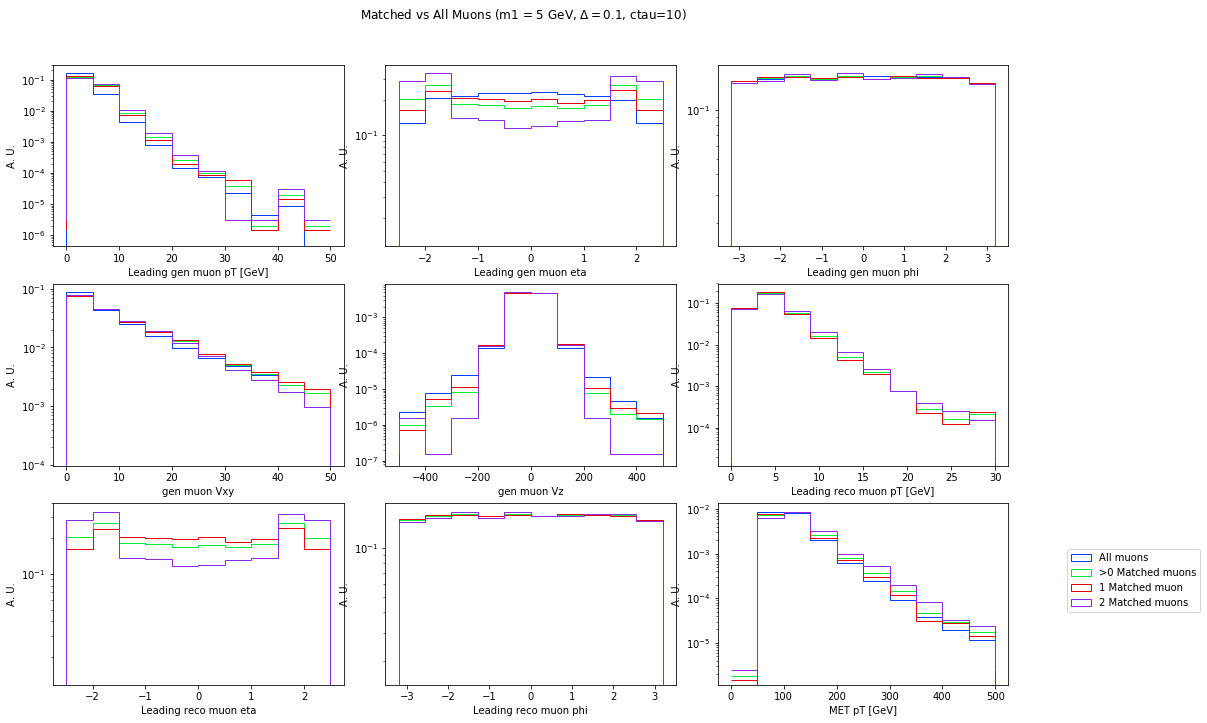

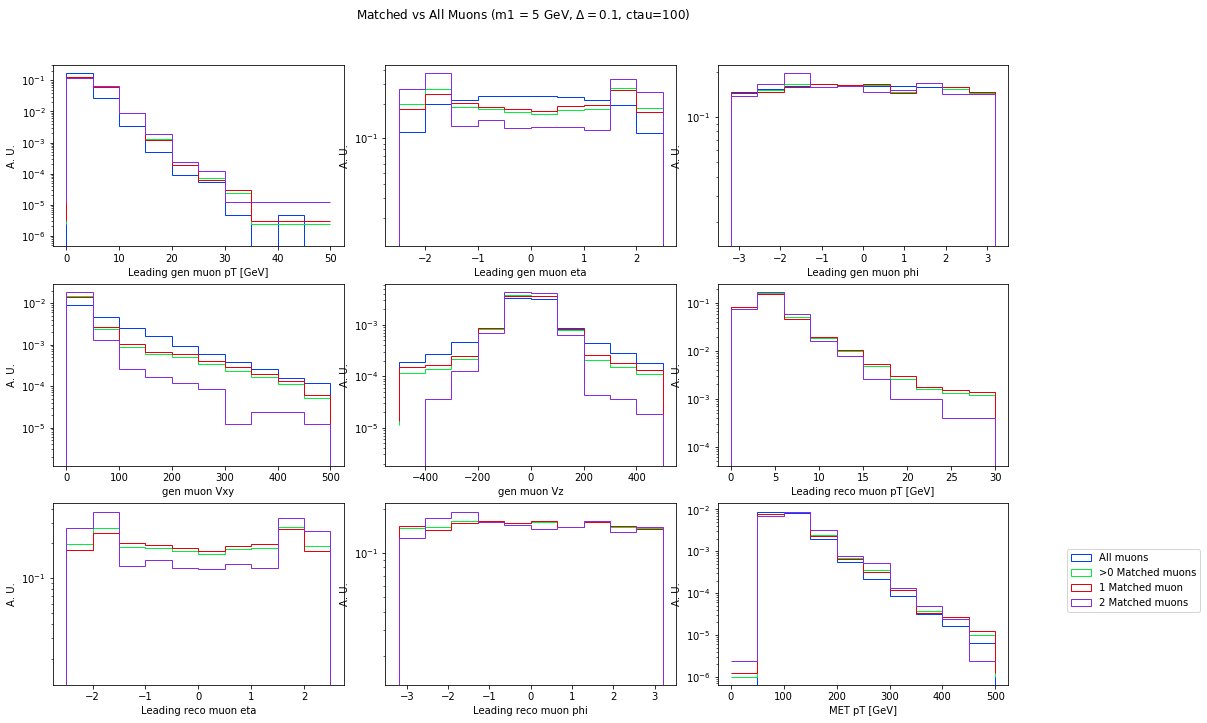

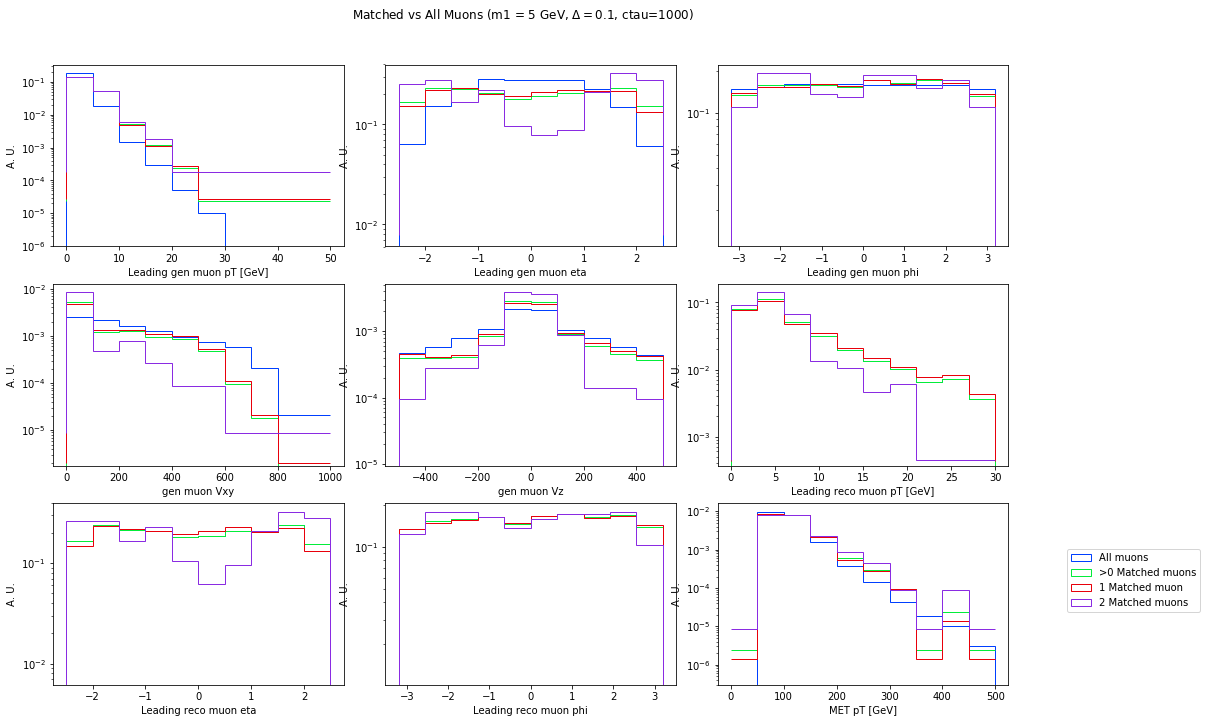

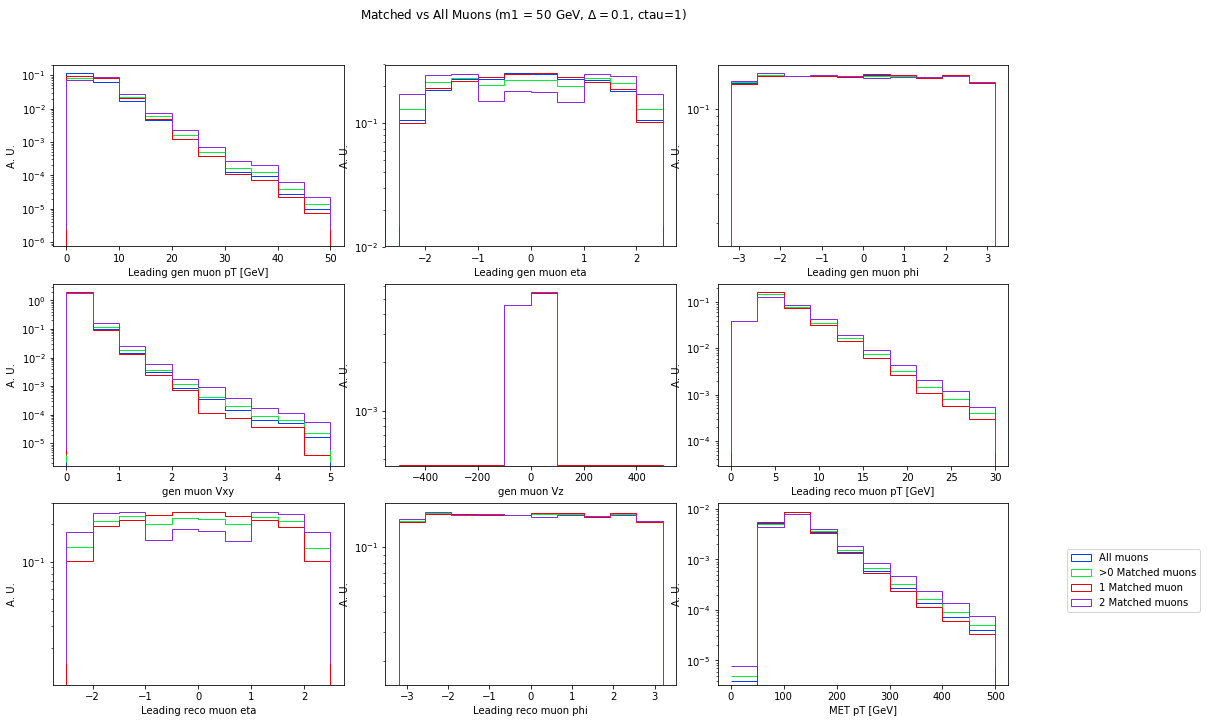

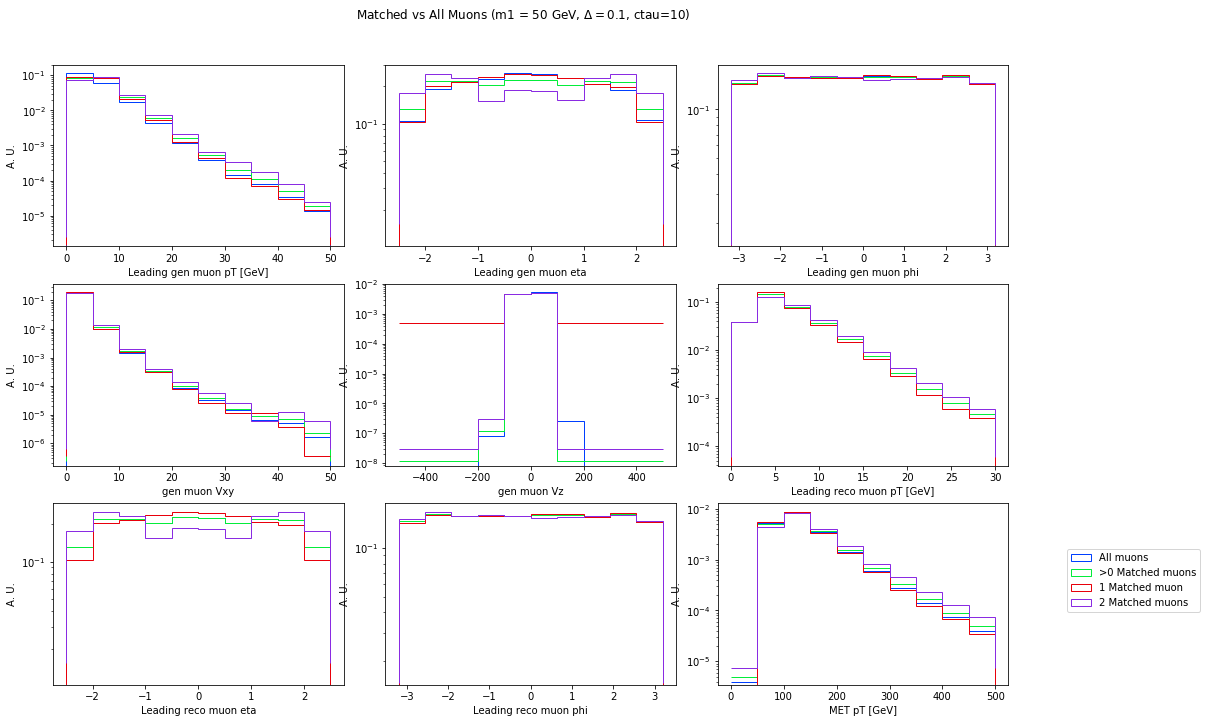

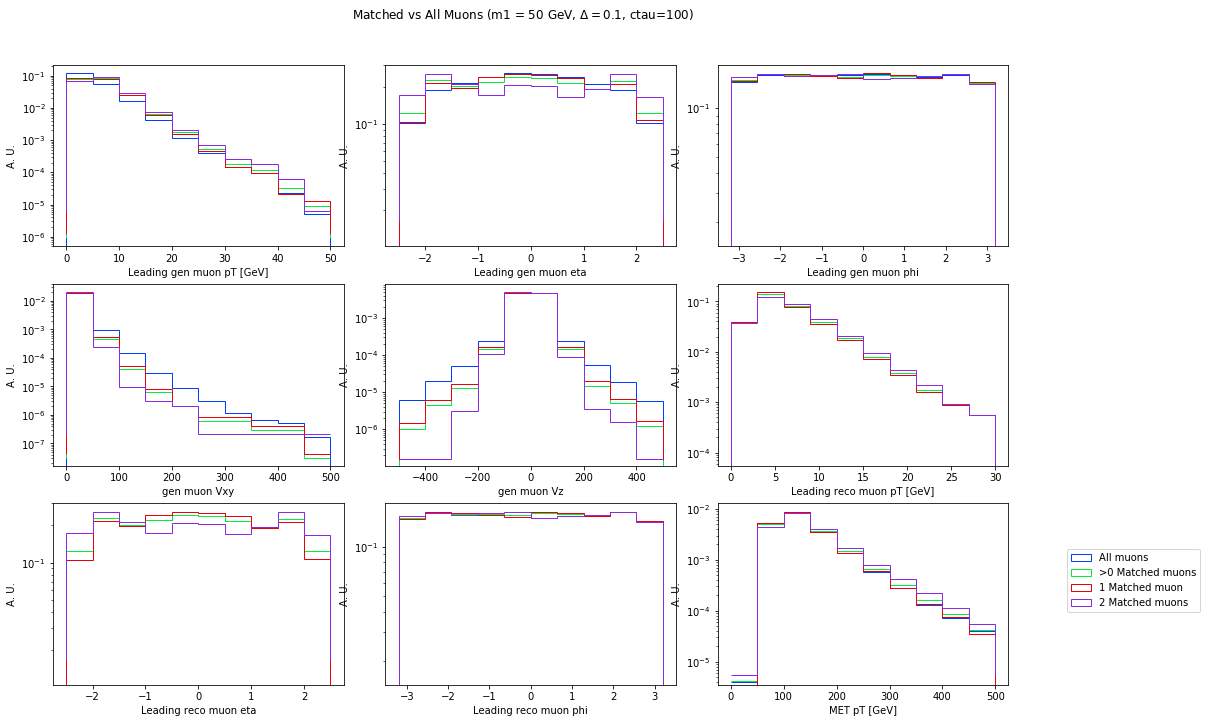

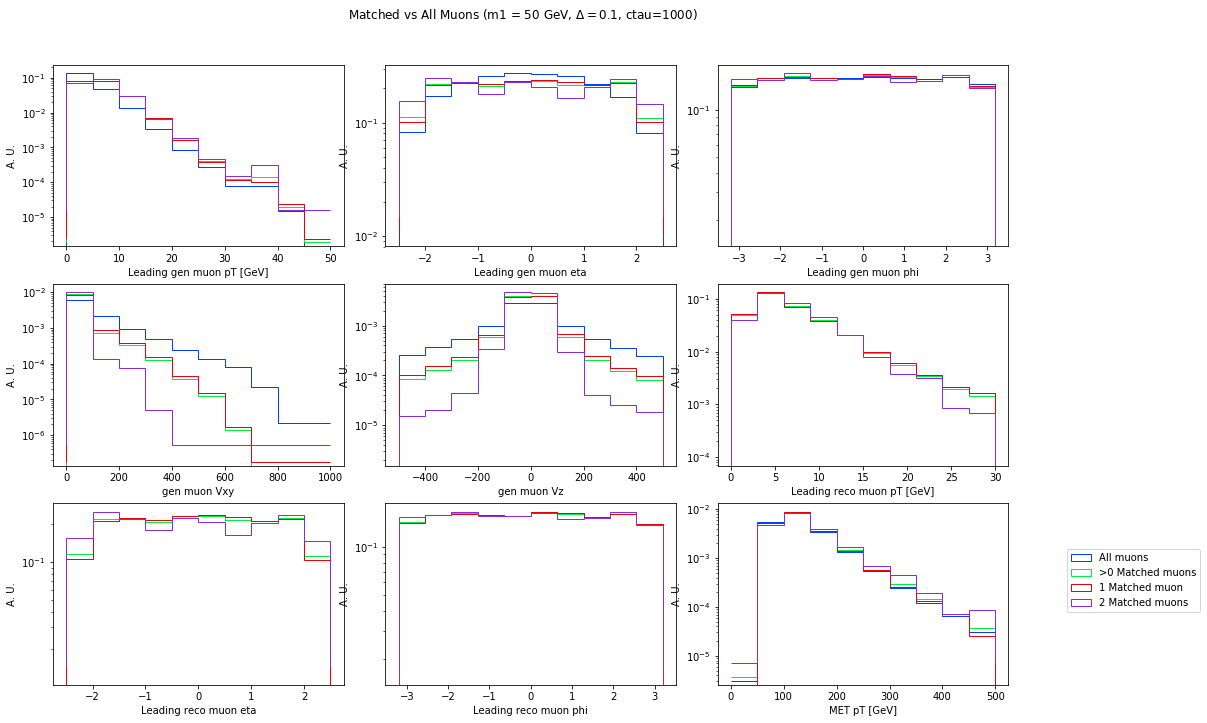

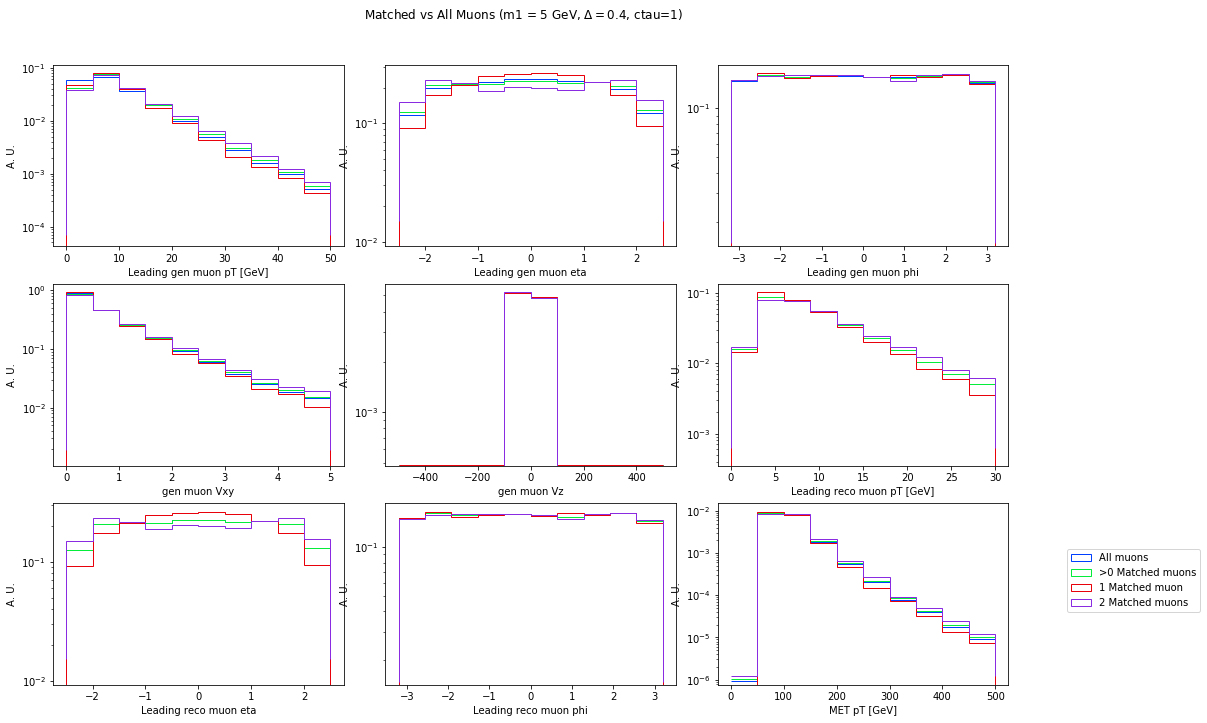

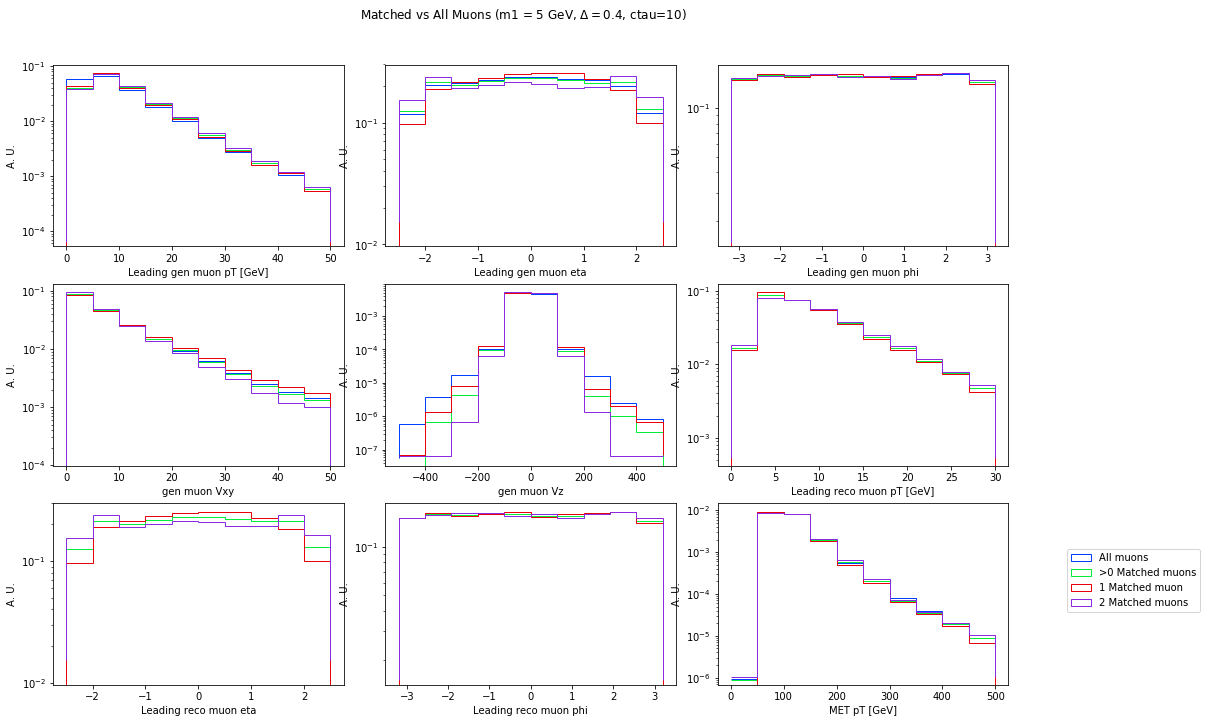

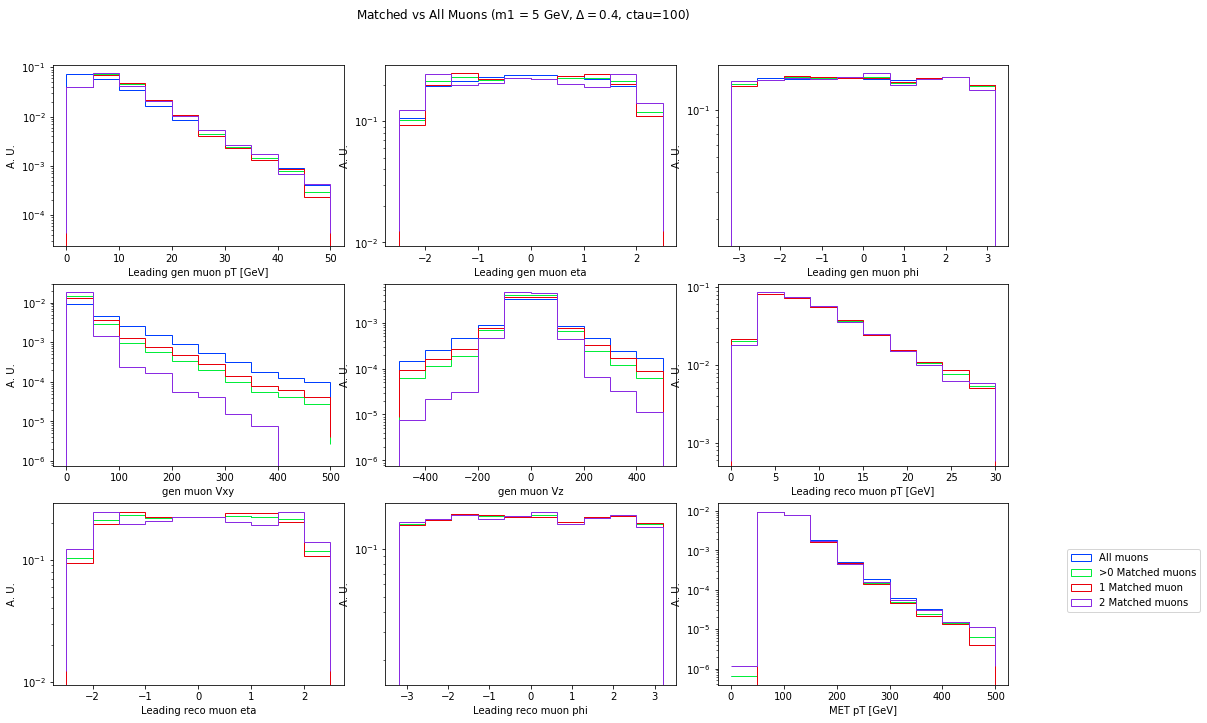

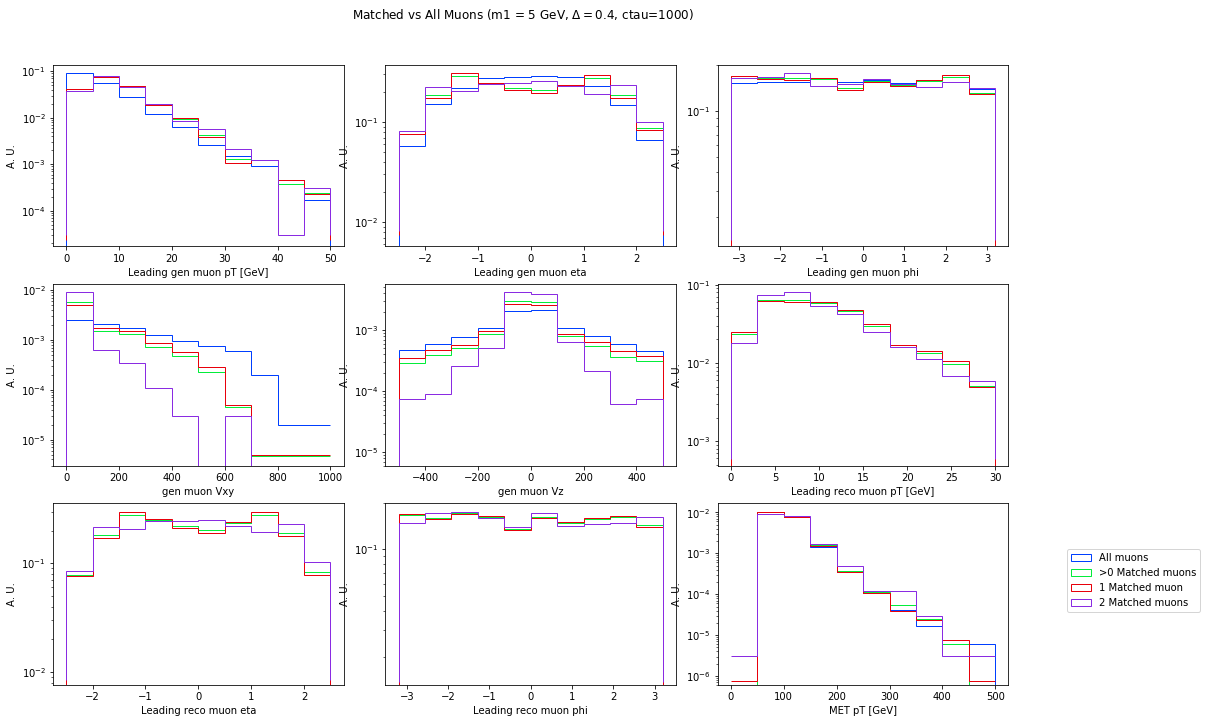

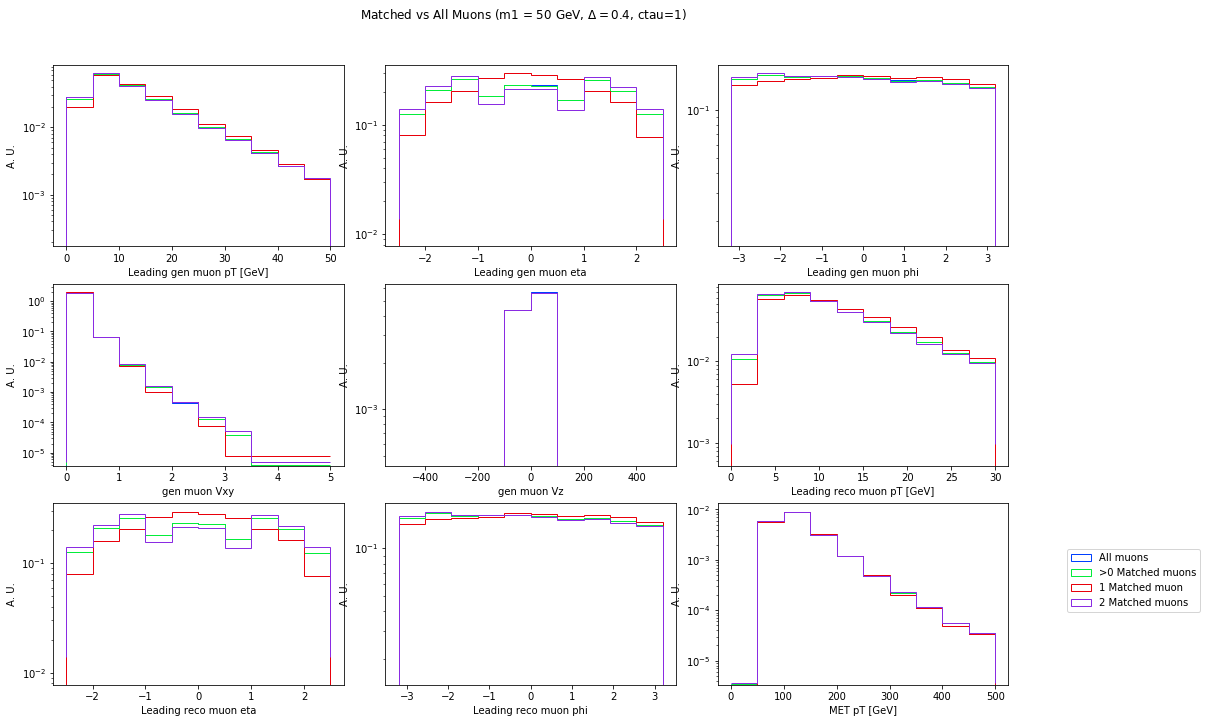

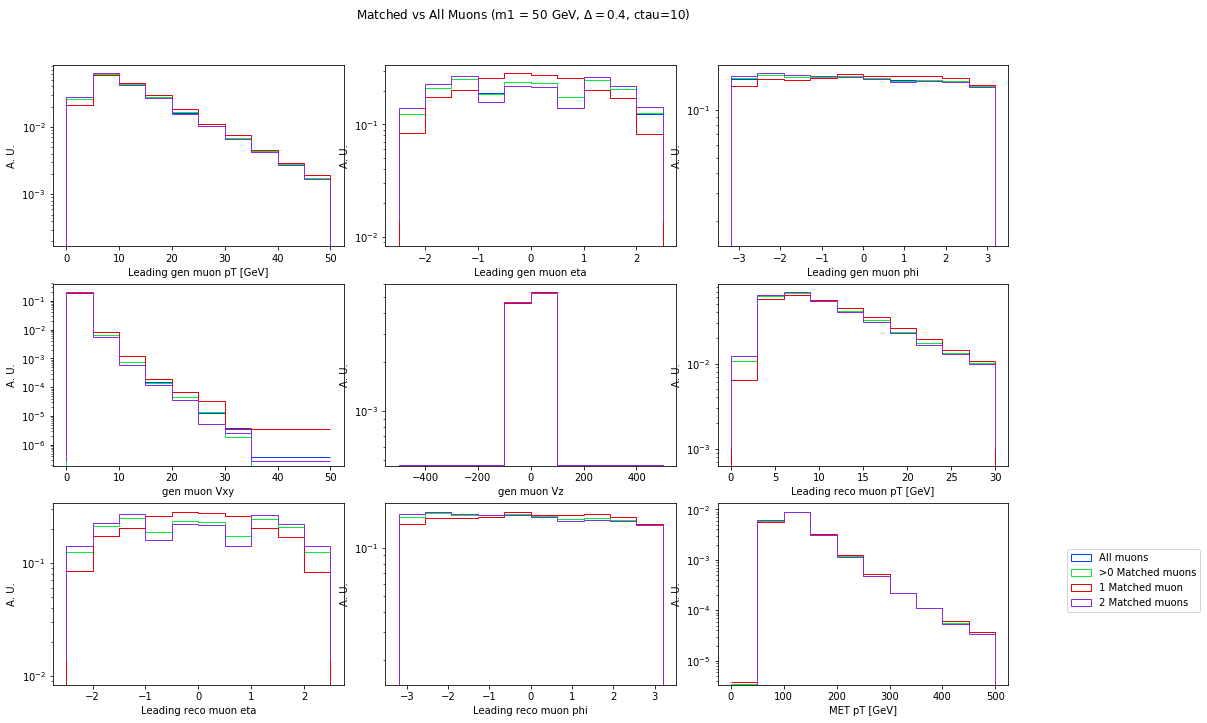

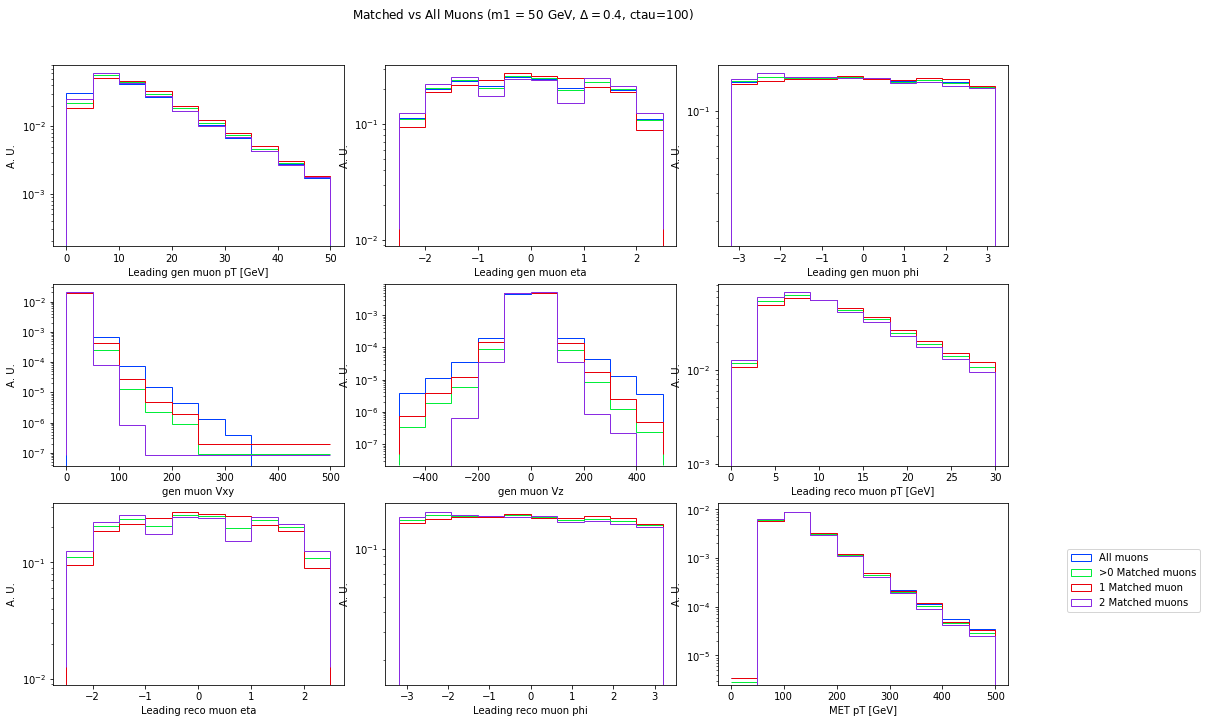

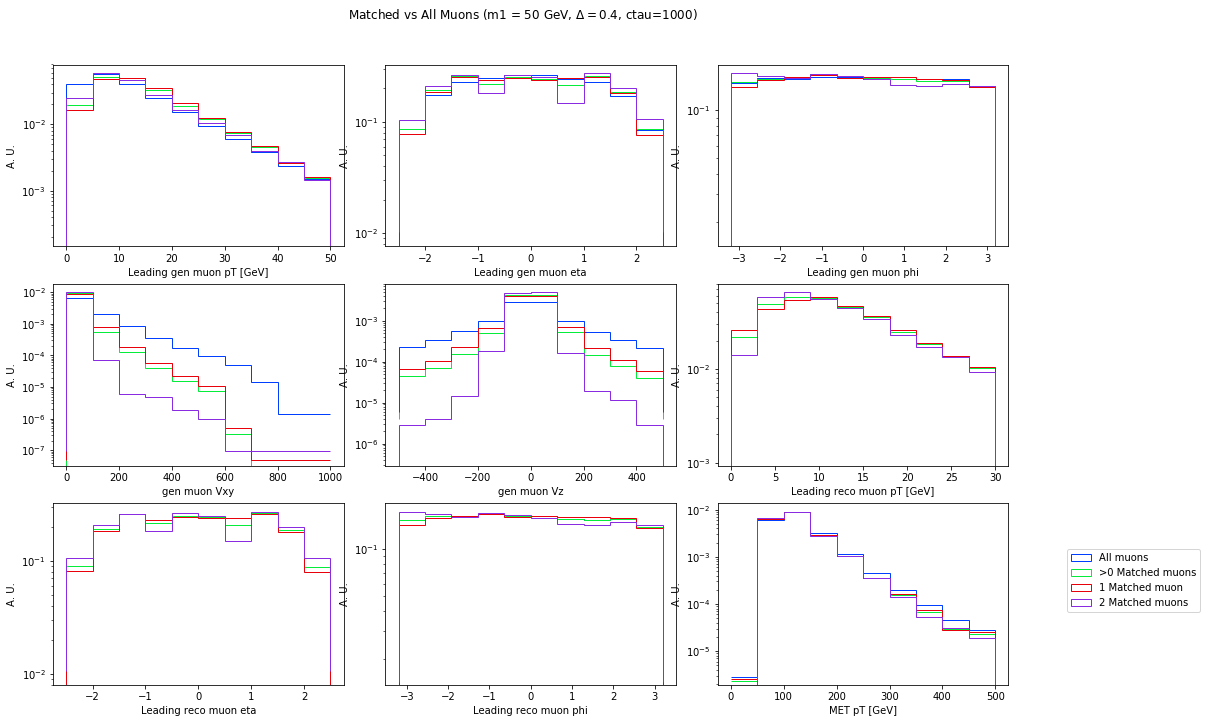

In [18]:
#sample = '52p5-100'
for sample in samples:
    fig, axes = plt.subplots(3,3, figsize=(14,10))
    fig.suptitle(f'Matched vs All Muons ({samples[sample]["label"]})')
    plt.tight_layout(h_pad=2.0)
    fig.subplots_adjust(top=0.90)
    binn= 1000 if samples[sample]['ctau']=='1000' else 5*int(samples[sample]['ctau'])
    eff_plots['genVxy']['range']= [0,binn]
    for index, (column, props) in enumerate(eff_plots.items()):
        ax = axes[index//3, index%3]
    
        bin_edges = props['axis']
        kwargs = {'range': props['range'], 'bins':10, 'density': True, 'histtype':'step','log':True}
    
        df = samples[sample]['gbm_df']
        ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
            label='All muons');
        ax.hist(df.query('nMatched>0')[column].groupby('entry').nth(0), **kwargs, 
            label='>0 Matched muons');
        ax.hist(df.query('nMatched==1')[column].groupby('entry').nth(0), **kwargs, 
            label='1 Matched muon');
        ax.hist(df.query('nMatched==2')[column].groupby('entry').nth(0), **kwargs, 
            label='2 Matched muons');
        ax.set_xlabel(props['label'])
        ax.set_ylabel('A. U.')

    ax.legend(loc=(1.2 ,0.4))
    fig.savefig(f'{web_dir}/gbmmatched_vs_allMu_log_{sample}.png', bbox_inches='tight')

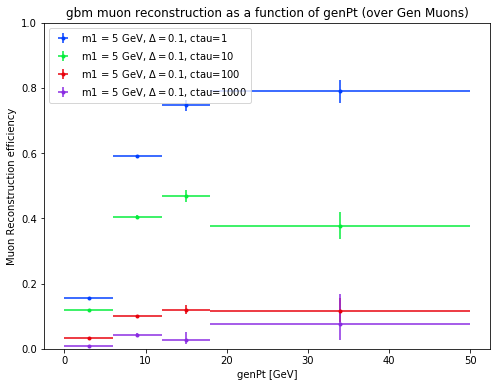

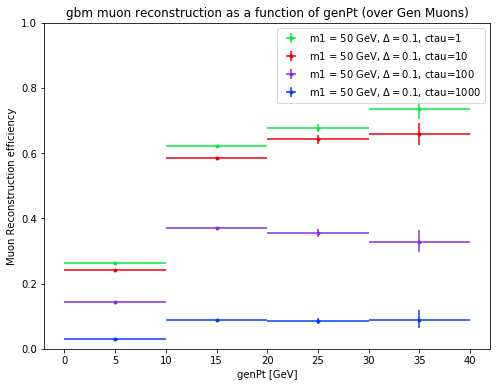

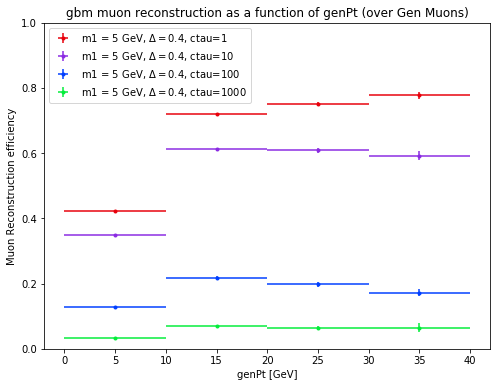

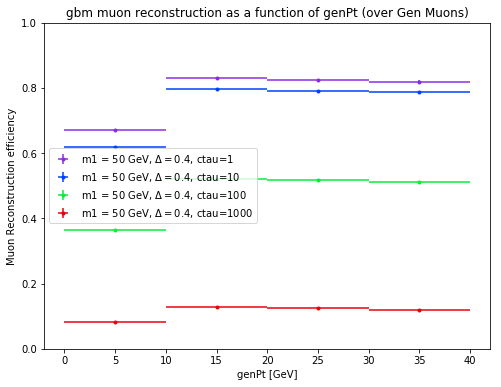

In [19]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']
#eff_plots['genPt']['axis'] = np.array(np.arange(0,50,10), dtype='float64')

for mass in mchis:
    fig, ax = plt.subplots(figsize=(8,6))
    eff_plots['genPt']['axis'] = np.array(np.append(np.arange(0,24,6), [50]), dtype='float64') if mass is '5p25' else np.array(np.arange(0,50,10), dtype='float64')
    for ctau in ctaus:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genPt', eff_plots['genPt'], event_selection='gbm_df')
    fig.savefig(f'{web_dir}/gbmReco_vs_genPt_mass_{mass}.png', bbox_inches='tight')

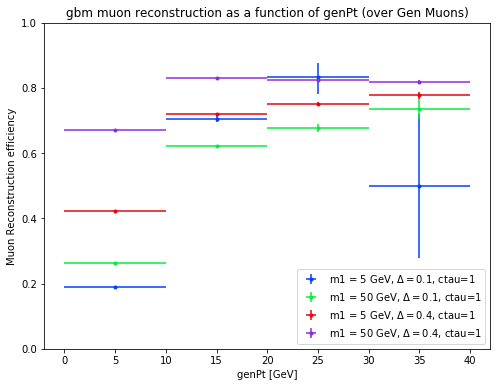

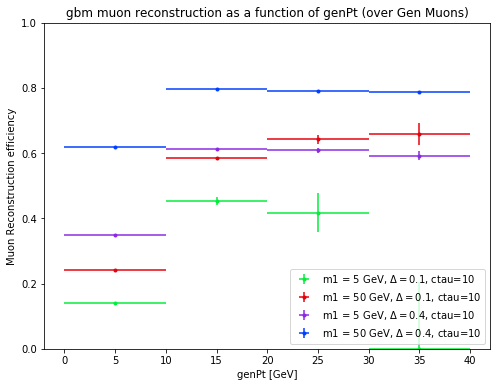

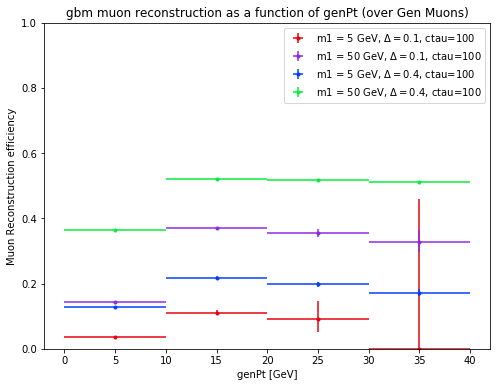

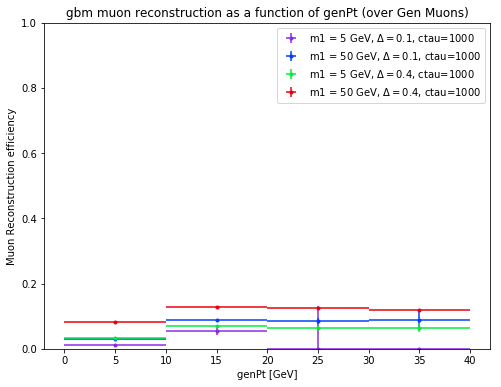

In [20]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']
eff_plots['genPt']['axis'] = np.array(np.arange(0,50,10), dtype='float64')

for ctau in ctaus:
    fig, ax = plt.subplots(figsize=(8,6))
    for mass in mchis:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genPt', eff_plots['genPt'], event_selection='gbm_df')
    fig.savefig(f'{web_dir}/gbmReco_vs_genPt_ctau_{ctau}.png', bbox_inches='tight')

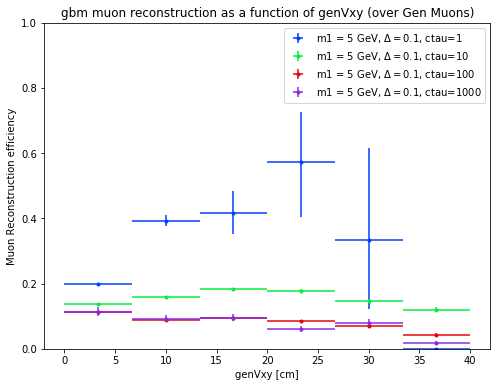

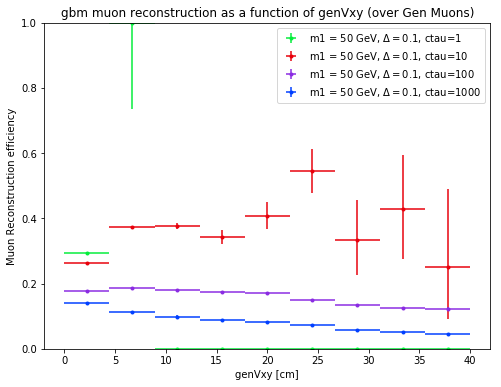

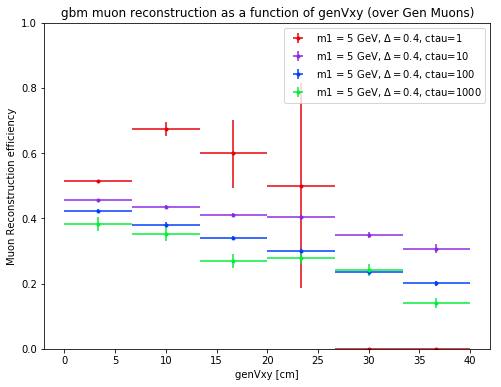

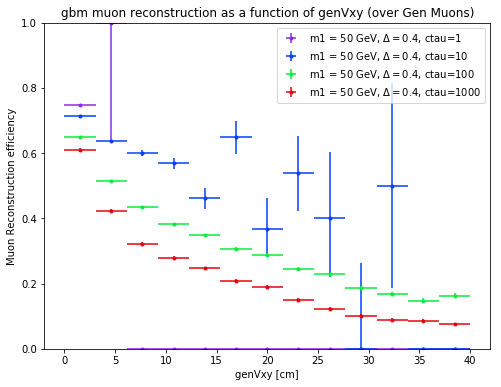

In [21]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']
binn = {'5p25':7,'52p5':10,'6p0':7,'60p0':14}
for mass in mchis:
    fig, ax = plt.subplots(figsize=(8,6))
    eff_plots['genVxy']['axis']= np.array(np.linspace(0,40,binn[mass]), dtype='float64')
    for ctau in ctaus:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genVxy', eff_plots['genVxy'], event_selection='gbm_df')
    fig.savefig(f'{web_dir}/gbmReco_vs_genVxy_mass_{mass}.png', bbox_inches='tight')

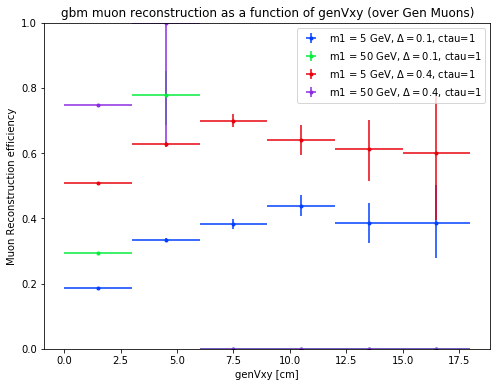

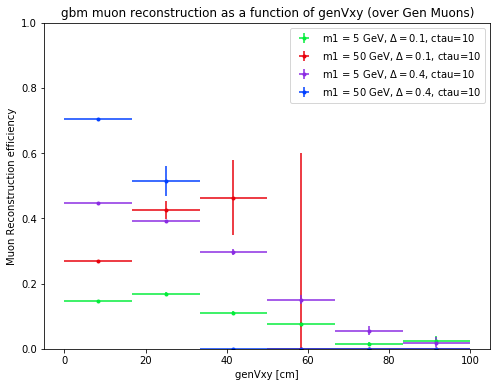

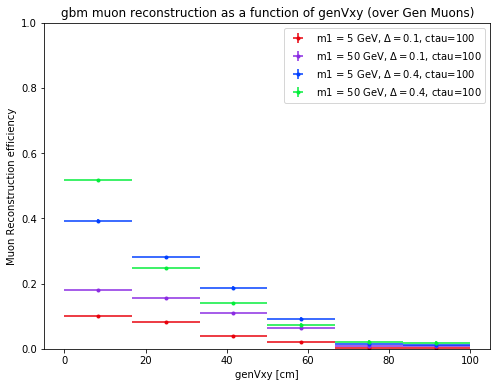

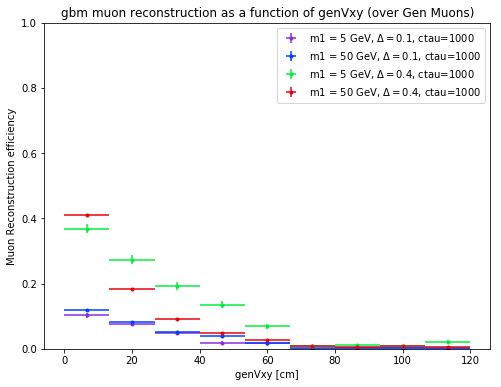

In [22]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']
maxbin = {'1':18,'10':100,'100':100,'1000':120}
for ctau in ctaus:
    fig, ax = plt.subplots(figsize=(8,6))
    binn= 10 if ctau=='1000' else 7
    eff_plots['genVxy']['axis']= np.array(np.linspace(0,maxbin[ctau],binn), dtype='float64')
    for mass in mchis:
        for index, (sample, props) in enumerate(samples.items()):
            if (props['ctau'] != ctau) or (props['mass'] != mass):
                continue
            make_plot(ax, sample, props, 'genVxy', eff_plots['genVxy'], event_selection='gbm_df')
    fig.savefig(f'{web_dir}/gbmReco_vs_genVxy_ctau_{ctau}.png', bbox_inches='tight')

In [23]:
_dict = {}
for sample, props in samples.items():
    _counts = props['gbm_df'].groupby('entry').nth(0)['nMatched'].value_counts()
    _dict[sample] = {}
    _dict[sample]['mass'] = props['mass']
    _dict[sample]['ctau'] = props['ctau']
    _dict[sample]['num_total'] = _counts.sum()
    _dict[sample]['mu_total'] = 2*_counts.sum()
    _dict[sample]['num_2matched'] = _counts.loc[2]
    _dict[sample]['num_anymatched'] = _counts.loc[1] +_dict[sample]['num_2matched']
    _dict[sample]['mu_2matched'] = 2*_counts.loc[2]
    _dict[sample]['mu_anymatched'] = _counts.loc[1] +_dict[sample]['mu_2matched']
    _dict[sample]['num_effi_2'] = 100*_dict[sample]['num_2matched'] / _dict[sample]['num_total']
    _dict[sample]['num_effi_any'] = 100*_dict[sample]['num_anymatched'] / _dict[sample]['num_total']
    _dict[sample]['mu_effi_2'] = 100*_dict[sample]['mu_2matched'] / _dict[sample]['mu_total']
    _dict[sample]['mu_effi_any'] = 100*_dict[sample]['mu_anymatched'] / _dict[sample]['mu_total']
    #print(_dict[sample]['mass'])
    #print(_counts)
    #print(_counts.iloc[2])
    #print(_counts.loc[2])

    #print(_dict[sample])

In [24]:
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame(_dict)
cols = ['num_total', 'num_2matched', 'num_anymatched', 'num_effi_2', 'num_effi_any']
df = df.transpose()[cols].transpose()
#df.to_csv(web_dir + '/trigger_cutflow.csv')
df

5p25-1 5p25-10 5p25-100 5p25-1000  52p5-1 52p5-10 52p5-100  \
num_total       45247   45215    43415     20052  119890  119784   119367   
num_2matched     9031    6629     1651       228   35232   32356    19373   
num_anymatched  23294   20363     8168      1675   88131   85892    67186   
num_effi_2      19.96   14.66     3.80      1.14   29.39   27.01    16.23   
num_effi_any    51.48   45.04    18.81      8.35   73.51   71.71    56.29   

               52p5-1000  6p0-1 6p0-10 6p0100 6p0-1000  60p0-1 60p0-10  \
num_total         110260  35253  35235  34235    16356  105757  105783   
num_2matched        3876  18201  15094   5184      662   79168   74601   
num_anymatched     21166  31480  29905  15562     3262  104556  103542   
num_effi_2          3.52  51.63  42.84  15.14     4.05   74.86   70.52   
num_effi_any       19.20  89.30  84.87  45.46    19.94   98.86   97.88   

               60p0-100 60p0-1000  
num_total        105772     99573  
num_2matched      46554     10351  
num_anymatched    87040     30924  
num_effi_2        44.01     10.40  
num_effi_any      82.29     31.06

In [25]:
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame(_dict)
cols=['ctau','mass','num_effi_2']
tbl= pd.pivot_table(df.transpose()[cols].reset_index(),values=['num_effi_2'],columns=['mass'],index=['ctau'],aggfunc='first')
tbl

num_effi_2                  
mass       52p5  5p25  60p0   6p0
ctau                             
1         29.39 19.96 74.86 51.63
10        27.01 14.66 70.52 42.84
100       16.23  3.80 44.01 15.14
1000       3.52  1.14 10.40  4.05

In [26]:
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame(_dict)
cols=['ctau','mass','num_effi_any']
tbl= pd.pivot_table(df.transpose()[cols].reset_index(),values=['num_effi_any'],columns=['mass'],index=['ctau'],aggfunc='first')
tbl

num_effi_any                  
mass         52p5  5p25  60p0   6p0
ctau                               
1           73.51 51.48 98.86 89.30
10          71.71 45.04 97.88 84.87
100         56.29 18.81 82.29 45.46
1000        19.20  8.35 31.06 19.94

In [27]:
#pd.options.display.float_format = '{:,.2f}'.format
mudf = pd.DataFrame(_dict)
cols = ['mu_total', 'mu_2matched', 'mu_anymatched', 'mu_effi_2', 'mu_effi_any']
mudf = mudf.transpose()[cols].transpose()
#df.to_csv(web_dir + '/trigger_cutflow.csv')
mudf

5p25-1 5p25-10 5p25-100 5p25-1000  52p5-1 52p5-10 52p5-100  \
mu_total       90494   90430    86830     40104  239780  239568   238734   
mu_2matched    18062   13258     3302       456   70464   64712    38746   
mu_anymatched  32325   26992     9819      1903  123363  118248    86559   
mu_effi_2      19.96   14.66     3.80      1.14   29.39   27.01    16.23   
mu_effi_any    35.72   29.85    11.31      4.75   51.45   49.36    36.26   

              52p5-1000  6p0-1 6p0-10 6p0100 6p0-1000  60p0-1 60p0-10  \
mu_total         220520  70506  70470  68470    32712  211514  211566   
mu_2matched        7752  36402  30188  10368     1324  158336  149202   
mu_anymatched     25042  49681  44999  20746     3924  183724  178143   
mu_effi_2          3.52  51.63  42.84  15.14     4.05   74.86   70.52   
mu_effi_any       11.36  70.46  63.86  30.30    12.00   86.86   84.20   

              60p0-100 60p0-1000  
mu_total        211544    199146  
mu_2matched      93108     20702  
mu_anymatched   133594     41275  
mu_effi_2        44.01     10.40  
mu_effi_any      63.15     20.73

In [28]:
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame(_dict)
cols=['ctau','mass','mu_effi_2']
tbl= pd.pivot_table(df.transpose()[cols].reset_index(),values=['mu_effi_2'],columns=['mass'],index=['ctau'],aggfunc='first')
tbl

mu_effi_2                  
mass      52p5  5p25  60p0   6p0
ctau                            
1        29.39 19.96 74.86 51.63
10       27.01 14.66 70.52 42.84
100      16.23  3.80 44.01 15.14
1000      3.52  1.14 10.40  4.05

In [29]:
pd.options.display.float_format = '{:,.2f}'.format
df = pd.DataFrame(_dict)
cols=['ctau','mass','mu_effi_any']
tbl= pd.pivot_table(df.transpose()[cols].reset_index(),values=['mu_effi_any'],columns=['mass'],index=['ctau'],aggfunc='first')
tbl

mu_effi_any                  
mass        52p5  5p25  60p0   6p0
ctau                              
1          51.45 35.72 86.86 70.46
10         49.36 29.85 84.20 63.86
100        36.26 11.31 63.15 30.30
1000       11.36  4.75 20.73 12.00

# nmatched

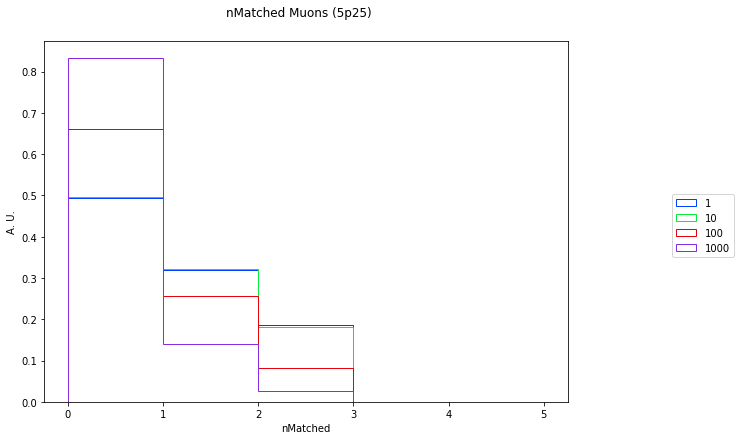

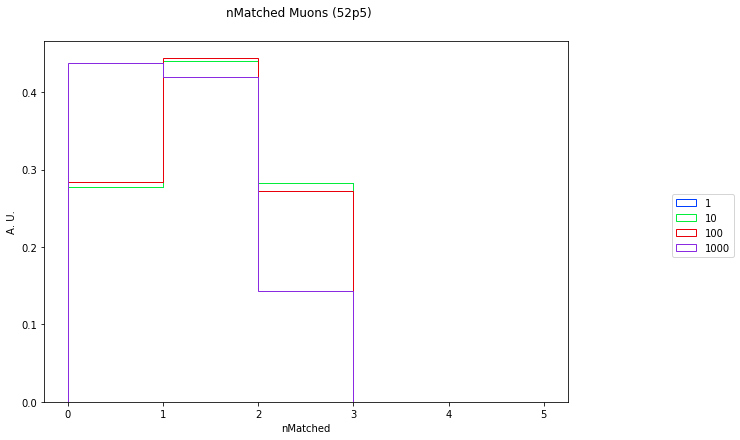

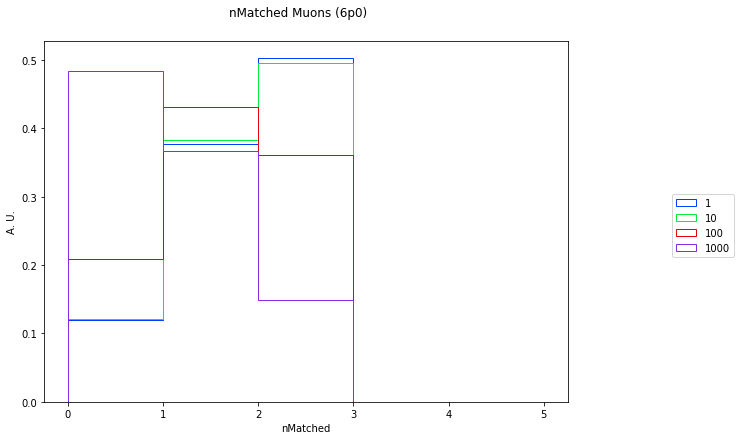

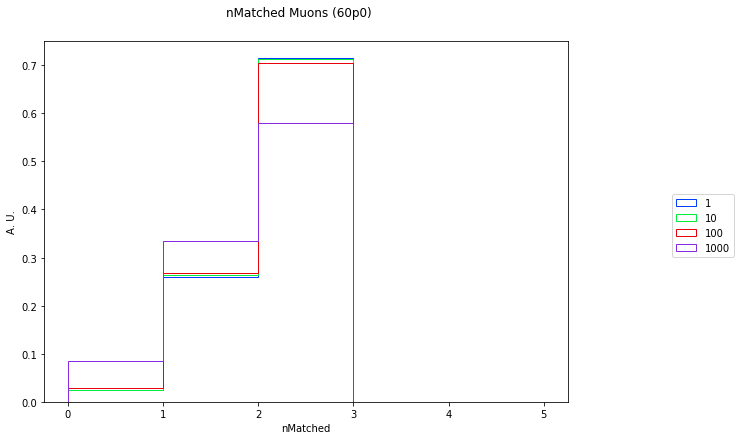

In [30]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','52p5','6p0','60p0']

for mass in mchis:
    fig, ax = plt.subplots(figsize=(8,6))
    fig.suptitle(f'nMatched Muons ({mass})')
    plt.tight_layout(h_pad=2.0)
    fig.subplots_adjust(top=0.90)
    for sample in samples:
        if samples[sample]['mass'] != mass:
            continue

        kwargs = {'range': [0,5], 'bins':5, 'density': True, 'histtype':'step','log':False}
        column='nMatched'
        df = samples[sample]['dsa_df']
        ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
           label=samples[sample]["ctau"]);

    ax.set_xlabel('nMatched')
    ax.set_ylabel('A. U.')
    ax.legend(loc=(1.2 ,0.4))
    #fig.savefig(f'{web_dir}/gbmmatched_vs_allMu_log_{sample}.png', bbox_inches='tight')

# global subset

In [38]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','6p0','52p5','60p0']

for mass in mchis:
    for ctau in ctaus:
        #print(mass,ctau)
    #fig, ax = plt.subplots(figsize=(8,6))
    #fig.suptitle(f'nMatched Muons ({mass})')
    #plt.tight_layout(h_pad=2.0)
    #fig.subplots_adjust(top=0.90)
        for sample in samples:
            if (samples[sample]['mass'] != mass) or (samples[sample]['ctau'] != ctau):
                continue
            #print(sample,samples[sample]['mass'],samples[sample]['ctau'])
            kwargs = {'range': [0,5], 'bins':5, 'density': True, 'histtype':'step','log':False}
            column='nMatched'
            df = pd.DataFrame()
            df['dsa'] = samples[sample]['dsa_df']['nMatched'].groupby('entry').nth(0)
            df['gbm'] = samples[sample]['gbm_df']['nMatched'].groupby('entry').nth(0)
            dsa0 = df['gbm'][df['dsa']==0].value_counts()/(df['gbm'][df['dsa']==0].value_counts().sum())
            dsa1 = df['gbm'][df['dsa']==1].value_counts()/(df['gbm'][df['dsa']==1].value_counts().sum())
            dsa2 = df['gbm'][df['dsa']==2].value_counts()/(df['gbm'][df['dsa']==2].value_counts().sum())
            df2 = pd.DataFrame(np.array([[dsa0.loc[0], dsa0.loc[1], dsa0.loc[2]], [dsa1.loc[0], dsa1.loc[1], dsa1.loc[2]], [dsa2.loc[0], dsa2.loc[1], dsa2.loc[2]]]),
                    columns=['gbm=0', 'gbm=1', 'gbm=2'],index=['dsa=0', 'dsa=1', 'dsa=2'])
            print(mass,ctau)
            print(df2)

        #ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
        #   label=samples[sample]["ctau"]);

   # ax.set_xlabel('nMatched')
   # ax.set_ylabel('A. U.')
   #ax.legend(loc=(1.2 ,0.4))

5p25 1
       gbm=0  gbm=1  gbm=2
dsa=0   0.92   0.07   0.01
dsa=1   0.09   0.80   0.11
dsa=2   0.01   0.12   0.87
5p25 10
       gbm=0  gbm=1  gbm=2
dsa=0   0.93   0.07   0.01
dsa=1   0.22   0.70   0.08
dsa=2   0.10   0.25   0.65
5p25 100
       gbm=0  gbm=1  gbm=2
dsa=0   0.95   0.05   0.00
dsa=1   0.60   0.36   0.03
dsa=2   0.39   0.27   0.34
5p25 1000
       gbm=0  gbm=1  gbm=2
dsa=0   0.96   0.04   0.00
dsa=1   0.76   0.22   0.02
dsa=2   0.47   0.26   0.27
6p0 1
       gbm=0  gbm=1  gbm=2
dsa=0   0.77   0.17   0.06
dsa=1   0.04   0.82   0.15
dsa=2   0.00   0.09   0.90
6p0 10
       gbm=0  gbm=1  gbm=2
dsa=0   0.78   0.17   0.05
dsa=1   0.10   0.77   0.13
dsa=2   0.03   0.21   0.75
6p0 100
       gbm=0  gbm=1  gbm=2
dsa=0   0.88   0.11   0.01
dsa=1   0.55   0.41   0.05
dsa=2   0.35   0.30   0.36
6p0 1000
       gbm=0  gbm=1  gbm=2
dsa=0   0.93   0.07   0.00
dsa=1   0.75   0.24   0.01
dsa=2   0.51   0.26   0.23
52p5 1
       gbm=0  gbm=1  gbm=2
dsa=0   0.86   0.13   0.02
dsa=1   0.0

In [43]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','6p0','52p5','60p0']

for mass in mchis:
    for ctau in ctaus:
        #print(mass,ctau)
    #fig, ax = plt.subplots(figsize=(8,6))
    #fig.suptitle(f'nMatched Muons ({mass})')
    #plt.tight_layout(h_pad=2.0)
    #fig.subplots_adjust(top=0.90)
        for sample in samples:
            if (samples[sample]['mass'] != mass) or (samples[sample]['ctau'] != ctau):
                continue
            #print(sample,samples[sample]['mass'],samples[sample]['ctau'])
            kwargs = {'range': [0,5], 'bins':5, 'density': True, 'histtype':'step','log':False}
            column='nMatched'
            df = pd.DataFrame()
            df['dsa'] = samples[sample]['dsa_df']['nMatched'].groupby('entry').nth(0)
            df['gbm'] = samples[sample]['gbm_df']['nMatched'].groupby('entry').nth(0)
            dsa_total = df['dsa'].value_counts().sum()
            dsa_frac0 = df['dsa'].value_counts().loc[0]/dsa_total
            dsa_frac1 = df['dsa'].value_counts().loc[1]/dsa_total
            dsa_frac2 = df['dsa'].value_counts().loc[2]/dsa_total
            #print(dsa_frac0,dsa_frac1,dsa_frac2)
            dsa0 = (df['gbm'][df['dsa']==0].value_counts()*dsa_frac0)/(df['gbm'][df['dsa']==0].value_counts().sum())
            dsa1 = (df['gbm'][df['dsa']==1].value_counts()*dsa_frac1)/(df['gbm'][df['dsa']==1].value_counts().sum())
            dsa2 = (df['gbm'][df['dsa']==2].value_counts()*dsa_frac2)/(df['gbm'][df['dsa']==2].value_counts().sum())
            df2 = pd.DataFrame(np.array([[dsa0.loc[0], dsa0.loc[1], dsa0.loc[2]], [dsa1.loc[0], dsa1.loc[1], dsa1.loc[2]], [dsa2.loc[0], dsa2.loc[1], dsa2.loc[2]]]),
                    columns=['gbm=0', 'gbm=1', 'gbm=2'],index=['dsa=0', 'dsa=1', 'dsa=2'])
            check_sum = dsa0.loc[0]+dsa0.loc[1]+dsa0.loc[2]+dsa1.loc[0]+dsa1.loc[1]+dsa1.loc[2]+dsa2.loc[0]+dsa2.loc[1]+dsa2.loc[2]
            print(mass,ctau,check_sum)
            print(df2)

        #ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
        #   label=samples[sample]["ctau"]);

   # ax.set_xlabel('nMatched')
   # ax.set_ylabel('A. U.')
   #ax.legend(loc=(1.2 ,0.4))

5p25 1 0.9999999999999999
       gbm=0  gbm=1  gbm=2
dsa=0   0.45   0.03   0.00
dsa=1   0.03   0.26   0.03
dsa=2   0.00   0.02   0.16
5p25 10 1.0
       gbm=0  gbm=1  gbm=2
dsa=0   0.46   0.03   0.00
dsa=1   0.07   0.23   0.03
dsa=2   0.02   0.05   0.12
5p25 100 1.0
       gbm=0  gbm=1  gbm=2
dsa=0   0.63   0.03   0.00
dsa=1   0.15   0.09   0.01
dsa=2   0.03   0.02   0.03
5p25 1000 0.9999999999999999
       gbm=0  gbm=1  gbm=2
dsa=0   0.80   0.03   0.00
dsa=1   0.11   0.03   0.00
dsa=2   0.01   0.01   0.01
6p0 1 1.0
       gbm=0  gbm=1  gbm=2
dsa=0   0.09   0.02   0.01
dsa=1   0.01   0.31   0.05
dsa=2   0.00   0.05   0.45
6p0 10 1.0
       gbm=0  gbm=1  gbm=2
dsa=0   0.09   0.02   0.01
dsa=1   0.04   0.29   0.05
dsa=2   0.02   0.11   0.37
6p0 100 1.0
       gbm=0  gbm=1  gbm=2
dsa=0   0.18   0.02   0.00
dsa=1   0.24   0.17   0.02
dsa=2   0.13   0.11   0.13
6p0 1000 1.0
       gbm=0  gbm=1  gbm=2
dsa=0   0.45   0.03   0.00
dsa=1   0.27   0.09   0.01
dsa=2   0.08   0.04   0.03
52p5 1 1.0

In [13]:
ctaus = ['1','10','100','1000']
mchis = ['5p25','6p0','52p5','60p0']

for mass in mchis:
    for ctau in ctaus:
        #print(mass,ctau)
    #fig, ax = plt.subplots(figsize=(8,6))
    #fig.suptitle(f'nMatched Muons ({mass})')
    #plt.tight_layout(h_pad=2.0)
    #fig.subplots_adjust(top=0.90)
        for sample in samples:
            if (samples[sample]['mass'] != mass) or (samples[sample]['ctau'] != ctau):
                continue
            #print(sample,samples[sample]['mass'],samples[sample]['ctau'])
            kwargs = {'range': [0,5], 'bins':5, 'density': True, 'histtype':'step','log':False}
            column='nMatched'
            df = pd.DataFrame()
            df['dsa'] = samples[sample]['dsa_df']['nMatched'].groupby('entry').nth(0)
            df['gbm'] = samples[sample]['gbm_df']['nMatched'].groupby('entry').nth(0)
            dsa_total = df['dsa'].value_counts().sum()
            #dsa_frac0 = df['dsa'].value_counts().loc[0]/dsa_total
            #dsa_frac1 = df['dsa'].value_counts().loc[1]/dsa_total
            #dsa_frac2 = df['dsa'].value_counts().loc[2]/dsa_total
            #print(dsa_frac0,dsa_frac1,dsa_frac2)
            dsa0 = (df['gbm'][df['dsa']==0].value_counts())#*dsa_frac0)/(df['gbm'][df['dsa']==0].value_counts().sum())
            dsa1 = (df['gbm'][df['dsa']==1].value_counts())#*dsa_frac1)/(df['gbm'][df['dsa']==1].value_counts().sum())
            dsa2 = (df['gbm'][df['dsa']==2].value_counts())#*dsa_frac2)/(df['gbm'][df['dsa']==2].value_counts().sum())
            df2 = pd.DataFrame(np.array([[dsa0.loc[0], dsa0.loc[1], dsa0.loc[2]], [dsa1.loc[0], dsa1.loc[1], dsa1.loc[2]], [dsa2.loc[0], dsa2.loc[1], dsa2.loc[2]]]),
                    columns=['gbm=0', 'gbm=1', 'gbm=2'],index=['dsa=0', 'dsa=1', 'dsa=2'])
            df2 = df2/dsa_total
            check_sum = (dsa0.loc[0]+dsa0.loc[1]+dsa0.loc[2]+dsa1.loc[0]+dsa1.loc[1]+dsa1.loc[2]+dsa2.loc[0]+dsa2.loc[1]+dsa2.loc[2])/dsa_total
            print(mass,ctau,check_sum)
            print(df2)

        #ax.hist(df[column].groupby('entry').nth(0), **kwargs, 
        #   label=samples[sample]["ctau"]);

   # ax.set_xlabel('nMatched')
   # ax.set_ylabel('A. U.')
   #ax.legend(loc=(1.2 ,0.4))

5p25 1 1.0
          gbm=0     gbm=1     gbm=2
dsa=0  0.454373  0.034698  0.004332
dsa=1  0.028864  0.257365  0.033726
dsa=2  0.001945  0.023162  0.161536
5p25 10 1.0
          gbm=0     gbm=1     gbm=2
dsa=0  0.461462  0.032666  0.003096
dsa=1  0.070087  0.225147  0.026695
dsa=2  0.018091  0.045936  0.116820
5p25 100 1.0
          gbm=0     gbm=1     gbm=2
dsa=0  0.625037  0.034320  0.001843
dsa=1  0.154440  0.093309  0.008131
dsa=2  0.032385  0.022481  0.028055
5p25 1000 1.0
          gbm=0     gbm=1     gbm=2
dsa=0  0.796529  0.034610  0.001646
dsa=1  0.107520  0.030770  0.002693
dsa=2  0.012418  0.006782  0.007032
6p0 1 1.0
          gbm=0     gbm=1     gbm=2
dsa=0  0.092134  0.020594  0.007035
dsa=1  0.013701  0.308825  0.054974
dsa=2  0.001191  0.047258  0.454288
6p0 10 1.0
          gbm=0     gbm=1     gbm=2
dsa=0  0.094480  0.020321  0.006386
dsa=1  0.039932  0.294679  0.048191
dsa=2  0.016858  0.105350  0.373804
6p0 100 1.0
          gbm=0     gbm=1     gbm=2
dsa=0  0.183993  